In [1]:

from sogym.env import sogym
from sogym.utils import FigureRecorderCallback
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
import torch
from stable_baselines3 import PPO,SAC
from sogym.mmc_optim import run_mmc
%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 1.8.0
Using device: cuda


---
### Environment test and visualization:

In [2]:
from sogym.expert_generation import plot_10_random_simp
# plot_10_random_simp()

ImportError: cannot import name 'plot_10_random_simp' from 'sogym.expert_generation' (/scratch/thomas/GitHub/sogym_v2/sogym/expert_generation.py)

In [2]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='dense'))

In [2]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(mode='train',observation_type='dense',vol_constraint_type='hard',resolution=50)
eval_env = sogym(mode='test',observation_type='dense',vol_constraint_type='hard',resolution=50)

In [5]:
from sogym.simp_optim import run_simp
from sogym.mmc_optim import run_mmc

# simp_variables, f0val, num_iter, cfg = run_simp(train_env.nelx,train_env.nely,train_env.conditions,penal=3.0,rmin=3,ft=1,verbose=0)
#xval, f0val,it, H, Phimax, allPhi, den, N = run_mmc(train_env.conditions,train_env.nelx,train_env.nely,train_env.dx,train_env.dy,plotting='contour')

Volume:  0.12827836752219843
Reward  0.009287586053566629


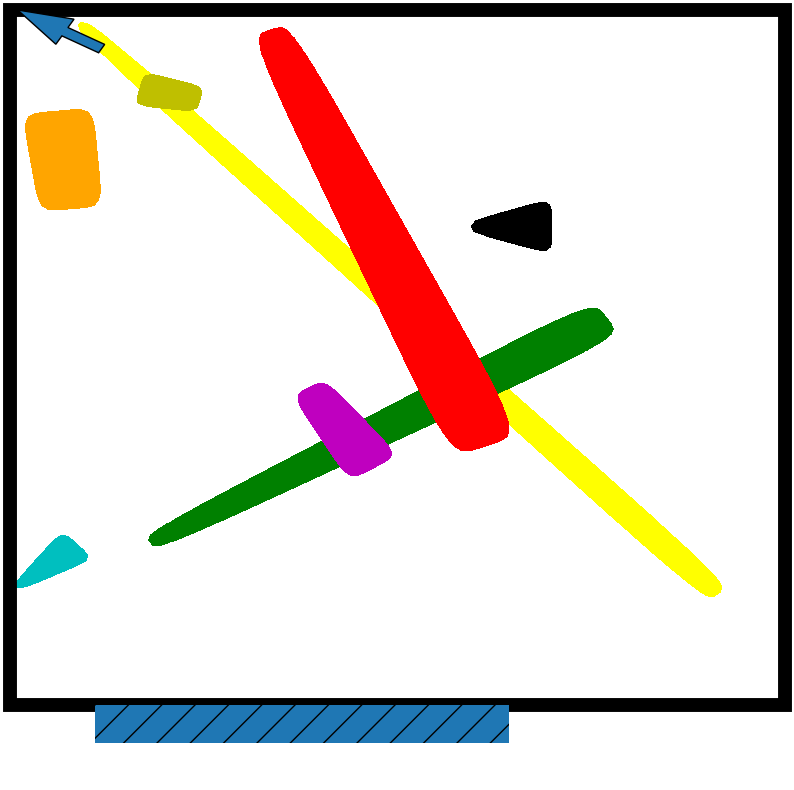

In [8]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

Volume:  0.13674034475775226
Reward  0.0


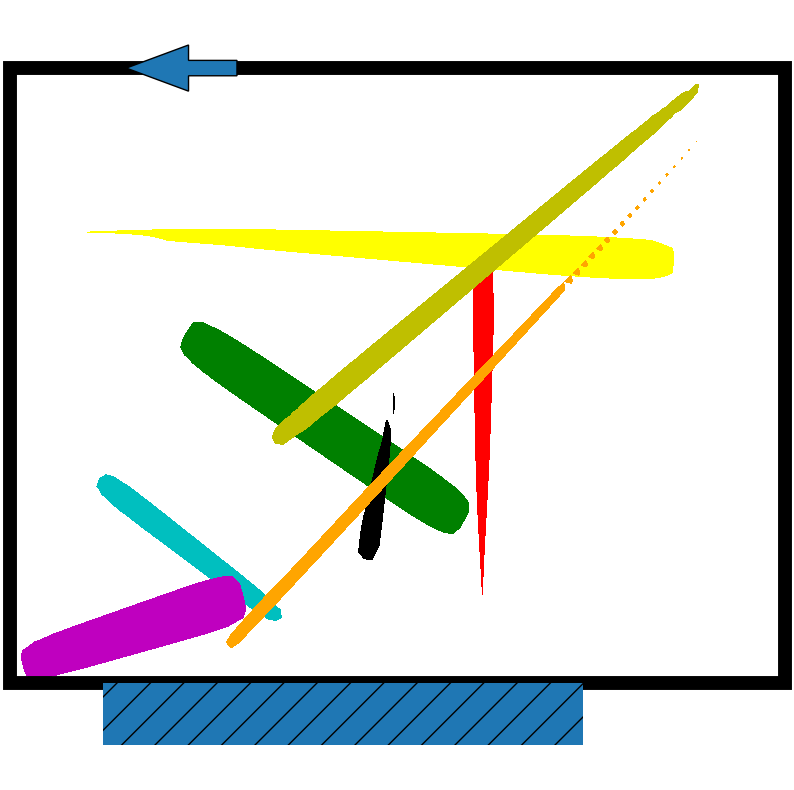

In [5]:
# Let's visualize the eval environment:
obs = eval_env.reset()
done = False
while not done:
    action = eval_env.action_space.sample()
    obs, reward, done, info = eval_env.step(action)
print("Volume: ", eval_env.volume)
print("Reward ",reward)
eval_env.plot()

---
### Multiprocessing

In [9]:
from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')
num_cpu = 64 # Number of processes to use
train_env = sogym(mode='train',observation_type='dense',vol_constraint_type = 'hard',resolution=75)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type='dense',vol_constraint_type='hard',resolution=75)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


In [10]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

eval_callback = EvalCallback(eval_env,log_path='tb_logs',eval_freq=100,deterministic=True,render=False,verbose=0)
callback = CallbackList([eval_callback,
                         FigureRecorderCallback(check_freq=2*8*32)])

--- 
### Defining the model

In [10]:
from sogym.expert_generation import generate_dataset, generate_all, load_all_trajectories
#generate_dataset(num_threads =16, num_samples=5000,dataset_folder = "dataset/topologies/mmc")
trajectories = load_all_trajectories(n_workers=32)

Loading trajectories: 100%|██████████| 43696/43696 [08:32<00:00, 85.30it/s] 


In [88]:
policy_kwargs = dict(
    net_arch=[2048,2048,2048,2048,2048],
)

In [11]:
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.5 * np.ones(n_actions))

model = SAC("MultiInputPolicy",
             env,
             verbose=0,
             #policy_kwargs = policy_kwargs,
             #action_noise= action_noise,
             tensorboard_log="tb_logs",
             learning_starts=4096,
             batch_size=4096,
             #train_freq = (8, "step"),
             gradient_steps= 1,
             device = 'cuda',
               )

In [84]:
from imitation.algorithms import bc
from imitation.algorithms.adversarial.airl import AIRL
from imitation.rewards.reward_nets import BasicShapedRewardNet
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from imitation.util import logger as imit_logger
import numpy as np

custom_logger = imit_logger.configure(
        folder="imit_tensorboard",
        format_strs=["tensorboard", "stdout"],
    )



In [85]:
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet

#learner=learner.load('checkpoints/SEP_28_BC',env=venv)

reward_net = BasicRewardNet(
    env.observation_space, 
    env.action_space,
    #use_next_state=True,
    #use_done=True,
    #hid_sizes=(128,128),
    #potential_hid_sizes=(32, 32),
    #discount_factor=1.0,
    dropout_prob=0.9
)
reward_net = BasicShapedRewardNet(
    observation_space=env.observation_space,
    action_space=env.action_space,
)


gail_trainer = GAIL(
    demonstrations=trajectories,
    demo_batch_size=4096,
    n_disc_updates_per_round=1,
    venv=env,
    log_dir="imit_tensorboard",
    custom_logger= custom_logger,
    gen_algo=model,
    reward_net=reward_net,
   # disc_opt_kwargs={"weight_decay": 3e-4,
    #                } 
)



In [86]:
gail_trainer.train(40000000)  # Note: set to 300000 for better results

round:   0%|          | 0/625000 [00:00<?, ?it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.686    |
|    disc/disc_loss                   | 0.694    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.686    |
|    disc/disc_loss            

round:   0%|          | 1/625000 [00:00<43:09:00,  4.02it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.686    |
|    disc/disc_loss                   | 0.688    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 2        |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.686    |
|    disc/disc_loss            

round:   0%|          | 2/625000 [00:00<30:15:35,  5.74it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.685    |
|    disc/disc_loss                   | 0.687    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 3        |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.685    |
|    disc/disc_loss            

round:   0%|          | 3/625000 [00:00<27:19:57,  6.35it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.685    |
|    disc/disc_loss                   | 0.683    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 4        |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.685    |
|    disc/disc_loss            

round:   0%|          | 4/625000 [00:00<28:40:12,  6.06it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.684    |
|    disc/disc_loss                   | 0.688    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 5        |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.684    |
|    disc/disc_loss            

round:   0%|          | 5/625000 [00:00<27:04:56,  6.41it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.683    |
|    disc/disc_loss                   | 0.683    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 6        |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.683    |
|    disc/disc_loss            

round:   0%|          | 6/625000 [00:00<26:58:03,  6.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.683    |
|    disc/disc_loss                   | 0.68     |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 7        |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.683    |
|    disc/disc_loss            

round:   0%|          | 7/625000 [00:01<27:33:30,  6.30it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 4        |
|    gen/time/fps             | 19       |
|    gen/time/time_elapsed    | 3        |
|    gen/time/total_timesteps | 512      |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 8        |
|    gen/time/fps             | 19       |
|    gen/time/time_elapsed    | 3        |
|    gen/time/total_timesteps | 512      |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 12       |
|    gen/ti

round:   0%|          | 8/625000 [00:04<201:55:36,  1.16s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.684    |
|    disc/disc_loss                   | 0.654    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 9        |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.684    |
|    disc/disc_loss            

round:   0%|          | 9/625000 [00:04<145:21:30,  1.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.683    |
|    disc/disc_loss                   | 0.654    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 10       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.683    |
|    disc/disc_loss            

round:   0%|          | 10/625000 [00:04<106:53:56,  1.62it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.683    |
|    disc/disc_loss                   | 0.655    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 11       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.683    |
|    disc/disc_loss            

round:   0%|          | 11/625000 [00:04<80:32:13,  2.16it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.682    |
|    disc/disc_loss                   | 0.657    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 12       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.682    |
|    disc/disc_loss            

round:   0%|          | 12/625000 [00:04<62:33:38,  2.78it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.68     |
|    disc/disc_loss                   | 0.665    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 13       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.68     |
|    disc/disc_loss            

round:   0%|          | 13/625000 [00:05<50:32:27,  3.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.68     |
|    disc/disc_loss                   | 0.66     |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 14       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.68     |
|    disc/disc_loss            

round:   0%|          | 14/625000 [00:05<42:33:44,  4.08it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.679    |
|    disc/disc_loss                   | 0.661    |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 15       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.679    |
|    disc/disc_loss            

round:   0%|          | 15/625000 [00:05<37:25:03,  4.64it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 2.1e-07  |
|    gen/rollout/ep_rew_wrapped_mean | 6.56     |
|    gen/time/episodes               | 68       |
|    gen/time/fps                    | 24       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 1024     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 2.1e-07  |
|    gen/time/episodes        | 72       |
|    gen/time/fps             | 24       |
|    gen/time/time_elapsed    | 2        |
|    gen/time/total_timesteps | 1024     |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mea

round:   0%|          | 16/625000 [00:08<169:52:23,  1.02it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.517    |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0.0349   |
|    disc/disc_entropy                | 0.68     |
|    disc/disc_loss                   | 0.623    |
|    disc/disc_proportion_expert_pred | 0.982    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 17       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.517    |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0.0349   |
|    disc/disc_entropy                | 0.68     |
|    disc/disc_loss            

round:   0%|          | 17/625000 [00:08<124:57:36,  1.39it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.516    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 0.0342   |
|    disc/disc_entropy                | 0.68     |
|    disc/disc_loss                   | 0.623    |
|    disc/disc_proportion_expert_pred | 0.982    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 18       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.516    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 0.0342   |
|    disc/disc_entropy                | 0.68     |
|    disc/disc_loss            

round:   0%|          | 18/625000 [00:08<93:12:35,  1.86it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.506    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 0.0154   |
|    disc/disc_entropy                | 0.679    |
|    disc/disc_loss                   | 0.625    |
|    disc/disc_proportion_expert_pred | 0.99     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 19       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.506    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 0.0154   |
|    disc/disc_entropy                | 0.679    |
|    disc/disc_loss            

round:   0%|          | 19/625000 [00:08<71:45:01,  2.42it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.499    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.677    |
|    disc/disc_loss                   | 0.63     |
|    disc/disc_proportion_expert_pred | 0.999    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 20       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.499    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.677    |
|    disc/disc_loss            

round:   0%|          | 20/625000 [00:08<56:40:16,  3.06it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.505    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 0.0142   |
|    disc/disc_entropy                | 0.676    |
|    disc/disc_loss                   | 0.635    |
|    disc/disc_proportion_expert_pred | 0.991    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 21       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.505    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 0.0142   |
|    disc/disc_entropy                | 0.676    |
|    disc/disc_loss            

round:   0%|          | 21/625000 [00:08<46:42:32,  3.72it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.52     |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 0.0481   |
|    disc/disc_entropy                | 0.675    |
|    disc/disc_loss                   | 0.636    |
|    disc/disc_proportion_expert_pred | 0.972    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 22       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.52     |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 0.0481   |
|    disc/disc_entropy                | 0.675    |
|    disc/disc_loss            

round:   0%|          | 22/625000 [00:08<40:07:13,  4.33it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.504    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 0.0173   |
|    disc/disc_entropy                | 0.674    |
|    disc/disc_loss                   | 0.635    |
|    disc/disc_proportion_expert_pred | 0.986    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 23       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.504    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 0.0173   |
|    disc/disc_entropy                | 0.674    |
|    disc/disc_loss            

round:   0%|          | 23/625000 [00:09<35:58:24,  4.83it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 6.44     |
|    gen/time/episodes               | 132      |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 1536     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 136      |
|    gen/time/fps             | 23       |
|    gen/time/time_elapsed    | 2        |
|    gen/time/total_timesteps | 1536     |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mea

round:   0%|          | 24/625000 [00:11<173:22:34,  1.00it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.752    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 0.52     |
|    disc/disc_entropy                | 0.674    |
|    disc/disc_loss                   | 0.586    |
|    disc/disc_proportion_expert_pred | 0.731    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 25       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.752    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 0.52     |
|    disc/disc_entropy                | 0.674    |
|    disc/disc_loss            

round:   0%|          | 25/625000 [00:11<127:28:56,  1.36it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.726    |
|    disc/disc_acc_expert             | 0.984    |
|    disc/disc_acc_gen                | 0.468    |
|    disc/disc_entropy                | 0.673    |
|    disc/disc_loss                   | 0.587    |
|    disc/disc_proportion_expert_pred | 0.758    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 26       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.726    |
|    disc/disc_acc_expert             | 0.984    |
|    disc/disc_acc_gen                | 0.468    |
|    disc/disc_entropy                | 0.673    |
|    disc/disc_loss            

Process ForkServerProcess-392:
Process ForkServerProcess-451:
Process ForkServerProcess-449:
Process ForkServerProcess-453:
Process ForkServerProcess-448:
Process ForkServerProcess-452:
Process ForkServerProcess-450:
Process ForkServerProcess-446:
Process ForkServerProcess-447:
Process ForkServerProcess-444:
Process ForkServerProcess-442:
Process ForkServerProcess-437:
Process ForkServerProcess-445:
Process ForkServerProcess-443:
Process ForkServerProcess-440:
Process ForkServerProcess-439:
Process ForkServerProcess-441:
Process ForkServerProcess-435:
Process ForkServerProcess-434:
Process ForkServerProcess-436:
Process ForkServerProcess-433:
Process ForkServerProcess-430:
Process ForkServerProcess-432:
Process ForkServerProcess-438:
Process ForkServerProcess-428:
Process ForkServerProcess-427:
Process ForkServerProcess-429:
Process ForkServerProcess-426:
Process ForkServerProcess-431:
Process ForkServerProcess-424:
Process ForkServerProcess-420:
Process ForkServerProcess-425:
Process 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.6      |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 0.222    |
|    disc/disc_entropy                | 0.671    |
|    disc/disc_loss                   | 0.597    |
|    disc/disc_proportion_expert_pred | 0.879    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 27       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.6      |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 0.222    |
|    disc/disc_entropy                | 0.671    |
|    disc/disc_loss            

round:   0%|          | 27/625000 [00:12<97:49:23,  1.77it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.623    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 0.27     |
|    disc/disc_entropy                | 0.669    |
|    disc/disc_loss                   | 0.593    |
|    disc/disc_proportion_expert_pred | 0.853    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 28       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.623    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 0.27     |
|    disc/disc_entropy                | 0.669    |
|    disc/disc_loss            

round:   0%|          | 28/625000 [00:13<75:24:27,  2.30it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.502    |
|    disc/disc_acc_expert             | 0.972    |
|    disc/disc_acc_gen                | 0.0325   |
|    disc/disc_entropy                | 0.667    |
|    disc/disc_loss                   | 0.613    |
|    disc/disc_proportion_expert_pred | 0.97     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 29       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.502    |
|    disc/disc_acc_expert             | 0.972    |
|    disc/disc_acc_gen                | 0.0325   |
|    disc/disc_entropy                | 0.667    |
|    disc/disc_loss            

round:   0%|          | 29/625000 [00:13<60:32:55,  2.87it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.547    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 0.124    |
|    disc/disc_entropy                | 0.667    |
|    disc/disc_loss                   | 0.609    |
|    disc/disc_proportion_expert_pred | 0.923    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 30       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.547    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 0.124    |
|    disc/disc_entropy                | 0.667    |
|    disc/disc_loss            

round:   0%|          | 30/625000 [00:13<50:41:03,  3.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.501    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 0.0334   |
|    disc/disc_entropy                | 0.663    |
|    disc/disc_loss                   | 0.619    |
|    disc/disc_proportion_expert_pred | 0.967    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 31       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.501    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 0.0334   |
|    disc/disc_entropy                | 0.663    |
|    disc/disc_loss            

round:   0%|          | 31/625000 [00:13<44:16:34,  3.92it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 6.25     |
|    gen/time/episodes               | 196      |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 2048     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 200      |
|    gen/time/fps             | 19       |
|    gen/time/time_elapsed    | 3        |
|    gen/time/total_timesteps | 2048     |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mea

round:   0%|          | 32/625000 [00:16<208:33:43,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.916    |
|    disc/disc_acc_expert             | 0.961    |
|    disc/disc_acc_gen                | 0.871    |
|    disc/disc_entropy                | 0.663    |
|    disc/disc_loss                   | 0.549    |
|    disc/disc_proportion_expert_pred | 0.545    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 33       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.916    |
|    disc/disc_acc_expert             | 0.961    |
|    disc/disc_acc_gen                | 0.871    |
|    disc/disc_entropy                | 0.663    |
|    disc/disc_loss            

round:   0%|          | 33/625000 [00:17<153:06:24,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.927    |
|    disc/disc_acc_expert             | 0.957    |
|    disc/disc_acc_gen                | 0.897    |
|    disc/disc_entropy                | 0.661    |
|    disc/disc_loss                   | 0.546    |
|    disc/disc_proportion_expert_pred | 0.53     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 34       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.927    |
|    disc/disc_acc_expert             | 0.957    |
|    disc/disc_acc_gen                | 0.897    |
|    disc/disc_entropy                | 0.661    |
|    disc/disc_loss            

round:   0%|          | 34/625000 [00:17<113:36:13,  1.53it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.782    |
|    disc/disc_acc_expert             | 0.955    |
|    disc/disc_acc_gen                | 0.609    |
|    disc/disc_entropy                | 0.661    |
|    disc/disc_loss                   | 0.559    |
|    disc/disc_proportion_expert_pred | 0.673    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 35       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.782    |
|    disc/disc_acc_expert             | 0.955    |
|    disc/disc_acc_gen                | 0.609    |
|    disc/disc_entropy                | 0.661    |
|    disc/disc_loss            

round:   0%|          | 35/625000 [00:17<86:48:00,  2.00it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.731    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 0.514    |
|    disc/disc_entropy                | 0.66     |
|    disc/disc_loss                   | 0.565    |
|    disc/disc_proportion_expert_pred | 0.717    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 36       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.731    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 0.514    |
|    disc/disc_entropy                | 0.66     |
|    disc/disc_loss            

round:   0%|          | 36/625000 [00:17<67:37:41,  2.57it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.626    |
|    disc/disc_acc_expert             | 0.953    |
|    disc/disc_acc_gen                | 0.3      |
|    disc/disc_entropy                | 0.657    |
|    disc/disc_loss                   | 0.579    |
|    disc/disc_proportion_expert_pred | 0.827    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 37       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.626    |
|    disc/disc_acc_expert             | 0.953    |
|    disc/disc_acc_gen                | 0.3      |
|    disc/disc_entropy                | 0.657    |
|    disc/disc_loss            

round:   0%|          | 37/625000 [00:17<54:32:25,  3.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.596    |
|    disc/disc_acc_expert             | 0.945    |
|    disc/disc_acc_gen                | 0.247    |
|    disc/disc_entropy                | 0.655    |
|    disc/disc_loss                   | 0.577    |
|    disc/disc_proportion_expert_pred | 0.849    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 38       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.596    |
|    disc/disc_acc_expert             | 0.945    |
|    disc/disc_acc_gen                | 0.247    |
|    disc/disc_entropy                | 0.655    |
|    disc/disc_loss            

round:   0%|          | 38/625000 [00:17<46:18:35,  3.75it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.576    |
|    disc/disc_acc_expert             | 0.942    |
|    disc/disc_acc_gen                | 0.21     |
|    disc/disc_entropy                | 0.653    |
|    disc/disc_loss                   | 0.588    |
|    disc/disc_proportion_expert_pred | 0.866    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 39       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.576    |
|    disc/disc_acc_expert             | 0.942    |
|    disc/disc_acc_gen                | 0.21     |
|    disc/disc_entropy                | 0.653    |
|    disc/disc_loss            

round:   0%|          | 39/625000 [00:17<41:10:20,  4.22it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 6.05     |
|    gen/time/episodes               | 260      |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 2560     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 264      |
|    gen/time/fps             | 21       |
|    gen/time/time_elapsed    | 3        |
|    gen/time/total_timesteps | 2560     |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mea

round:   0%|          | 40/625000 [00:21<192:42:30,  1.11s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.96     |
|    disc/disc_acc_expert             | 0.935    |
|    disc/disc_acc_gen                | 0.986    |
|    disc/disc_entropy                | 0.65     |
|    disc/disc_loss                   | 0.513    |
|    disc/disc_proportion_expert_pred | 0.474    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 41       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.96     |
|    disc/disc_acc_expert             | 0.935    |
|    disc/disc_acc_gen                | 0.986    |
|    disc/disc_entropy                | 0.65     |
|    disc/disc_loss            

round:   0%|          | 41/625000 [00:21<140:39:23,  1.23it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.933    |
|    disc/disc_acc_gen                | 0.963    |
|    disc/disc_entropy                | 0.648    |
|    disc/disc_loss                   | 0.512    |
|    disc/disc_proportion_expert_pred | 0.485    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 42       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.933    |
|    disc/disc_acc_gen                | 0.963    |
|    disc/disc_entropy                | 0.648    |
|    disc/disc_loss            

round:   0%|          | 42/625000 [00:21<104:53:39,  1.65it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.906    |
|    disc/disc_acc_expert             | 0.933    |
|    disc/disc_acc_gen                | 0.879    |
|    disc/disc_entropy                | 0.647    |
|    disc/disc_loss                   | 0.523    |
|    disc/disc_proportion_expert_pred | 0.527    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 43       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.906    |
|    disc/disc_acc_expert             | 0.933    |
|    disc/disc_acc_gen                | 0.879    |
|    disc/disc_entropy                | 0.647    |
|    disc/disc_loss            

round:   0%|          | 43/625000 [00:21<79:49:07,  2.17it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.815    |
|    disc/disc_acc_expert             | 0.938    |
|    disc/disc_acc_gen                | 0.692    |
|    disc/disc_entropy                | 0.643    |
|    disc/disc_loss                   | 0.526    |
|    disc/disc_proportion_expert_pred | 0.623    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 44       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.815    |
|    disc/disc_acc_expert             | 0.938    |
|    disc/disc_acc_gen                | 0.692    |
|    disc/disc_entropy                | 0.643    |
|    disc/disc_loss            

round:   0%|          | 44/625000 [00:21<62:19:10,  2.79it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.727    |
|    disc/disc_acc_expert             | 0.929    |
|    disc/disc_acc_gen                | 0.526    |
|    disc/disc_entropy                | 0.643    |
|    disc/disc_loss                   | 0.549    |
|    disc/disc_proportion_expert_pred | 0.701    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 45       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.727    |
|    disc/disc_acc_expert             | 0.929    |
|    disc/disc_acc_gen                | 0.526    |
|    disc/disc_entropy                | 0.643    |
|    disc/disc_loss            

round:   0%|          | 45/625000 [00:21<50:59:58,  3.40it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.675    |
|    disc/disc_acc_expert             | 0.928    |
|    disc/disc_acc_gen                | 0.422    |
|    disc/disc_entropy                | 0.639    |
|    disc/disc_loss                   | 0.549    |
|    disc/disc_proportion_expert_pred | 0.753    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 46       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.675    |
|    disc/disc_acc_expert             | 0.928    |
|    disc/disc_acc_gen                | 0.422    |
|    disc/disc_entropy                | 0.639    |
|    disc/disc_loss            

round:   0%|          | 46/625000 [00:21<43:18:03,  4.01it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.636    |
|    disc/disc_acc_expert             | 0.927    |
|    disc/disc_acc_gen                | 0.344    |
|    disc/disc_entropy                | 0.636    |
|    disc/disc_loss                   | 0.557    |
|    disc/disc_proportion_expert_pred | 0.792    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 47       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.636    |
|    disc/disc_acc_expert             | 0.927    |
|    disc/disc_acc_gen                | 0.344    |
|    disc/disc_entropy                | 0.636    |
|    disc/disc_loss            

round:   0%|          | 47/625000 [00:21<38:56:20,  4.46it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 5.8      |
|    gen/time/episodes               | 324      |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 3072     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 328      |
|    gen/time/fps             | 21       |
|    gen/time/time_elapsed    | 2        |
|    gen/time/total_timesteps | 3072     |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mea

round:   0%|          | 48/625000 [00:25<185:45:50,  1.07s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.954    |
|    disc/disc_acc_expert             | 0.922    |
|    disc/disc_acc_gen                | 0.987    |
|    disc/disc_entropy                | 0.629    |
|    disc/disc_loss                   | 0.461    |
|    disc/disc_proportion_expert_pred | 0.467    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 49       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.954    |
|    disc/disc_acc_expert             | 0.922    |
|    disc/disc_acc_gen                | 0.987    |
|    disc/disc_entropy                | 0.629    |
|    disc/disc_loss            

round:   0%|          | 49/625000 [00:25<135:54:59,  1.28it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.953    |
|    disc/disc_acc_expert             | 0.923    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.628    |
|    disc/disc_loss                   | 0.464    |
|    disc/disc_proportion_expert_pred | 0.469    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 50       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.953    |
|    disc/disc_acc_expert             | 0.923    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.628    |
|    disc/disc_loss            

round:   0%|          | 50/625000 [00:25<101:16:57,  1.71it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.928    |
|    disc/disc_acc_expert             | 0.922    |
|    disc/disc_acc_gen                | 0.935    |
|    disc/disc_entropy                | 0.629    |
|    disc/disc_loss                   | 0.481    |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 51       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.928    |
|    disc/disc_acc_expert             | 0.922    |
|    disc/disc_acc_gen                | 0.935    |
|    disc/disc_entropy                | 0.629    |
|    disc/disc_loss            

round:   0%|          | 51/625000 [00:25<77:24:28,  2.24it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.912    |
|    disc/disc_acc_expert             | 0.917    |
|    disc/disc_acc_gen                | 0.907    |
|    disc/disc_entropy                | 0.627    |
|    disc/disc_loss                   | 0.48     |
|    disc/disc_proportion_expert_pred | 0.505    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 52       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.912    |
|    disc/disc_acc_expert             | 0.917    |
|    disc/disc_acc_gen                | 0.907    |
|    disc/disc_entropy                | 0.627    |
|    disc/disc_loss            

round:   0%|          | 52/625000 [00:25<61:06:48,  2.84it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.867    |
|    disc/disc_acc_expert             | 0.921    |
|    disc/disc_acc_gen                | 0.812    |
|    disc/disc_entropy                | 0.625    |
|    disc/disc_loss                   | 0.497    |
|    disc/disc_proportion_expert_pred | 0.554    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 53       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.867    |
|    disc/disc_acc_expert             | 0.921    |
|    disc/disc_acc_gen                | 0.812    |
|    disc/disc_entropy                | 0.625    |
|    disc/disc_loss            

round:   0%|          | 53/625000 [00:25<49:58:52,  3.47it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.763    |
|    disc/disc_acc_expert             | 0.912    |
|    disc/disc_acc_gen                | 0.614    |
|    disc/disc_entropy                | 0.624    |
|    disc/disc_loss                   | 0.515    |
|    disc/disc_proportion_expert_pred | 0.649    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 54       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.763    |
|    disc/disc_acc_expert             | 0.912    |
|    disc/disc_acc_gen                | 0.614    |
|    disc/disc_entropy                | 0.624    |
|    disc/disc_loss            

round:   0%|          | 54/625000 [00:25<43:37:38,  3.98it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.785    |
|    disc/disc_acc_expert             | 0.913    |
|    disc/disc_acc_gen                | 0.656    |
|    disc/disc_entropy                | 0.623    |
|    disc/disc_loss                   | 0.506    |
|    disc/disc_proportion_expert_pred | 0.629    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 55       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.785    |
|    disc/disc_acc_expert             | 0.913    |
|    disc/disc_acc_gen                | 0.656    |
|    disc/disc_entropy                | 0.623    |
|    disc/disc_loss            

round:   0%|          | 55/625000 [00:25<39:11:24,  4.43it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 5.55     |
|    gen/time/episodes               | 388      |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 3584     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 392      |
|    gen/time/fps             | 20       |
|    gen/time/time_elapsed    | 3        |
|    gen/time/total_timesteps | 3584     |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mea

round:   0%|          | 56/625000 [00:29<194:57:50,  1.12s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.61     |
|    disc/disc_loss                   | 0.426    |
|    disc/disc_proportion_expert_pred | 0.448    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 57       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.61     |
|    disc/disc_loss            

round:   0%|          | 57/625000 [00:29<142:33:32,  1.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.952    |
|    disc/disc_acc_expert             | 0.904    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.609    |
|    disc/disc_loss                   | 0.43     |
|    disc/disc_proportion_expert_pred | 0.452    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 58       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.952    |
|    disc/disc_acc_expert             | 0.904    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.609    |
|    disc/disc_loss            

round:   0%|          | 58/625000 [00:29<106:17:14,  1.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.954    |
|    disc/disc_acc_expert             | 0.908    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.606    |
|    disc/disc_loss                   | 0.436    |
|    disc/disc_proportion_expert_pred | 0.454    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 59       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.954    |
|    disc/disc_acc_expert             | 0.908    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.606    |
|    disc/disc_loss            

round:   0%|          | 59/625000 [00:29<81:01:59,  2.14it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.926    |
|    disc/disc_acc_expert             | 0.897    |
|    disc/disc_acc_gen                | 0.954    |
|    disc/disc_entropy                | 0.61     |
|    disc/disc_loss                   | 0.459    |
|    disc/disc_proportion_expert_pred | 0.472    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 60       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.926    |
|    disc/disc_acc_expert             | 0.897    |
|    disc/disc_acc_gen                | 0.954    |
|    disc/disc_entropy                | 0.61     |
|    disc/disc_loss            

round:   0%|          | 60/625000 [00:29<76:21:31,  2.27it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.845    |
|    disc/disc_acc_expert             | 0.901    |
|    disc/disc_acc_gen                | 0.789    |
|    disc/disc_entropy                | 0.607    |
|    disc/disc_loss                   | 0.473    |
|    disc/disc_proportion_expert_pred | 0.556    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 61       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.845    |
|    disc/disc_acc_expert             | 0.901    |
|    disc/disc_acc_gen                | 0.789    |
|    disc/disc_entropy                | 0.607    |
|    disc/disc_loss            

round:   0%|          | 61/625000 [00:30<60:52:36,  2.85it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.898    |
|    disc/disc_acc_expert             | 0.899    |
|    disc/disc_acc_gen                | 0.897    |
|    disc/disc_entropy                | 0.607    |
|    disc/disc_loss                   | 0.464    |
|    disc/disc_proportion_expert_pred | 0.501    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 62       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.898    |
|    disc/disc_acc_expert             | 0.899    |
|    disc/disc_acc_gen                | 0.897    |
|    disc/disc_entropy                | 0.607    |
|    disc/disc_loss            

round:   0%|          | 62/625000 [00:30<50:25:21,  3.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.813    |
|    disc/disc_acc_expert             | 0.899    |
|    disc/disc_acc_gen                | 0.727    |
|    disc/disc_entropy                | 0.607    |
|    disc/disc_loss                   | 0.486    |
|    disc/disc_proportion_expert_pred | 0.586    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 63       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.813    |
|    disc/disc_acc_expert             | 0.899    |
|    disc/disc_acc_gen                | 0.727    |
|    disc/disc_entropy                | 0.607    |
|    disc/disc_loss            

round:   0%|          | 63/625000 [00:30<43:52:20,  3.96it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 5.11     |
|    gen/time/episodes               | 452      |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 4096     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes        | 456      |
|    gen/time/fps             | 20       |
|    gen/time/time_elapsed    | 3        |
|    gen/time/total_timesteps | 4096     |
------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mea

round:   0%|          | 64/625000 [00:33<202:55:37,  1.17s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.952    |
|    disc/disc_acc_expert             | 0.904    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.581    |
|    disc/disc_loss                   | 0.379    |
|    disc/disc_proportion_expert_pred | 0.452    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 65       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.952    |
|    disc/disc_acc_expert             | 0.904    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.581    |
|    disc/disc_loss            

round:   0%|          | 65/625000 [00:33<152:50:54,  1.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.586    |
|    disc/disc_loss                   | 0.394    |
|    disc/disc_proportion_expert_pred | 0.448    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 66       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.586    |
|    disc/disc_loss            

round:   0%|          | 66/625000 [00:34<117:04:04,  1.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.937    |
|    disc/disc_acc_expert             | 0.897    |
|    disc/disc_acc_gen                | 0.978    |
|    disc/disc_entropy                | 0.585    |
|    disc/disc_loss                   | 0.405    |
|    disc/disc_proportion_expert_pred | 0.46     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 67       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.937    |
|    disc/disc_acc_expert             | 0.897    |
|    disc/disc_acc_gen                | 0.978    |
|    disc/disc_entropy                | 0.585    |
|    disc/disc_loss            

round:   0%|          | 67/625000 [00:34<94:26:50,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.923    |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 0.95     |
|    disc/disc_entropy                | 0.587    |
|    disc/disc_loss                   | 0.415    |
|    disc/disc_proportion_expert_pred | 0.473    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 68       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.923    |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 0.95     |
|    disc/disc_entropy                | 0.587    |
|    disc/disc_loss            

round:   0%|          | 68/625000 [00:34<76:52:42,  2.26it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.89     |
|    disc/disc_acc_expert             | 0.891    |
|    disc/disc_acc_gen                | 0.889    |
|    disc/disc_entropy                | 0.588    |
|    disc/disc_loss                   | 0.439    |
|    disc/disc_proportion_expert_pred | 0.501    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 69       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.89     |
|    disc/disc_acc_expert             | 0.891    |
|    disc/disc_acc_gen                | 0.889    |
|    disc/disc_entropy                | 0.588    |
|    disc/disc_loss            

round:   0%|          | 69/625000 [00:34<64:59:43,  2.67it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.878    |
|    disc/disc_acc_expert             | 0.9      |
|    disc/disc_acc_gen                | 0.855    |
|    disc/disc_entropy                | 0.587    |
|    disc/disc_loss                   | 0.448    |
|    disc/disc_proportion_expert_pred | 0.523    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 70       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.878    |
|    disc/disc_acc_expert             | 0.9      |
|    disc/disc_acc_gen                | 0.855    |
|    disc/disc_entropy                | 0.587    |
|    disc/disc_loss            

round:   0%|          | 70/625000 [00:35<57:27:05,  3.02it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.831    |
|    disc/disc_acc_expert             | 0.895    |
|    disc/disc_acc_gen                | 0.767    |
|    disc/disc_entropy                | 0.587    |
|    disc/disc_loss                   | 0.455    |
|    disc/disc_proportion_expert_pred | 0.564    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 71       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.831    |
|    disc/disc_acc_expert             | 0.895    |
|    disc/disc_acc_gen                | 0.767    |
|    disc/disc_entropy                | 0.587    |
|    disc/disc_loss            

round:   0%|          | 71/625000 [00:35<53:00:25,  3.27it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 4.69     |
|    gen/time/episodes               | 516      |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 4608     |
|    gen/train/actor_loss            | -8.68    |
|    gen/train/critic_loss           | 2.12     |
|    gen/train/ent_coef              | 0.981    |
|    gen/train/ent_coef_loss         | -0.195   |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 70       |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 72/625000 [00:38<203:21:58,  1.17s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.946    |
|    disc/disc_acc_expert             | 0.893    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.553    |
|    disc/disc_loss                   | 0.343    |
|    disc/disc_proportion_expert_pred | 0.446    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 73       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.946    |
|    disc/disc_acc_expert             | 0.893    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.553    |
|    disc/disc_loss            

round:   0%|          | 73/625000 [00:38<152:45:18,  1.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.944    |
|    disc/disc_acc_expert             | 0.889    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.558    |
|    disc/disc_loss                   | 0.357    |
|    disc/disc_proportion_expert_pred | 0.444    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 74       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.944    |
|    disc/disc_acc_expert             | 0.889    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.558    |
|    disc/disc_loss            

round:   0%|          | 74/625000 [00:38<118:07:27,  1.47it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.937    |
|    disc/disc_acc_expert             | 0.894    |
|    disc/disc_acc_gen                | 0.98     |
|    disc/disc_entropy                | 0.565    |
|    disc/disc_loss                   | 0.374    |
|    disc/disc_proportion_expert_pred | 0.457    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 75       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.937    |
|    disc/disc_acc_expert             | 0.894    |
|    disc/disc_acc_gen                | 0.98     |
|    disc/disc_entropy                | 0.565    |
|    disc/disc_loss            

round:   0%|          | 75/625000 [00:39<93:17:42,  1.86it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.93     |
|    disc/disc_acc_expert             | 0.893    |
|    disc/disc_acc_gen                | 0.968    |
|    disc/disc_entropy                | 0.559    |
|    disc/disc_loss                   | 0.375    |
|    disc/disc_proportion_expert_pred | 0.463    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 76       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.93     |
|    disc/disc_acc_expert             | 0.893    |
|    disc/disc_acc_gen                | 0.968    |
|    disc/disc_entropy                | 0.559    |
|    disc/disc_loss            

round:   0%|          | 76/625000 [00:39<75:40:42,  2.29it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.903    |
|    disc/disc_acc_expert             | 0.887    |
|    disc/disc_acc_gen                | 0.918    |
|    disc/disc_entropy                | 0.561    |
|    disc/disc_loss                   | 0.389    |
|    disc/disc_proportion_expert_pred | 0.484    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 77       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.903    |
|    disc/disc_acc_expert             | 0.887    |
|    disc/disc_acc_gen                | 0.918    |
|    disc/disc_entropy                | 0.561    |
|    disc/disc_loss            

round:   0%|          | 77/625000 [00:39<63:50:48,  2.72it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.904    |
|    disc/disc_acc_expert             | 0.902    |
|    disc/disc_acc_gen                | 0.905    |
|    disc/disc_entropy                | 0.56     |
|    disc/disc_loss                   | 0.394    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 78       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.904    |
|    disc/disc_acc_expert             | 0.902    |
|    disc/disc_acc_gen                | 0.905    |
|    disc/disc_entropy                | 0.56     |
|    disc/disc_loss            

round:   0%|          | 78/625000 [00:39<57:11:40,  3.04it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.904    |
|    disc/disc_acc_expert             | 0.899    |
|    disc/disc_acc_gen                | 0.91     |
|    disc/disc_entropy                | 0.561    |
|    disc/disc_loss                   | 0.395    |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 79       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.904    |
|    disc/disc_acc_expert             | 0.899    |
|    disc/disc_acc_gen                | 0.91     |
|    disc/disc_entropy                | 0.561    |
|    disc/disc_loss            

round:   0%|          | 79/625000 [00:39<52:34:22,  3.30it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 4.26     |
|    gen/time/episodes               | 580      |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 5120     |
|    gen/train/actor_loss            | -9.08    |
|    gen/train/critic_loss           | 1.49     |
|    gen/train/ent_coef              | 0.958    |
|    gen/train/ent_coef_loss         | -0.438   |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 150      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 80/625000 [00:43<212:23:31,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.946    |
|    disc/disc_acc_expert             | 0.892    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.527    |
|    disc/disc_loss                   | 0.32     |
|    disc/disc_proportion_expert_pred | 0.446    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 81       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.946    |
|    disc/disc_acc_expert             | 0.892    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.527    |
|    disc/disc_loss            

round:   0%|          | 81/625000 [00:43<159:03:00,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.951    |
|    disc/disc_acc_expert             | 0.901    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.527    |
|    disc/disc_loss                   | 0.322    |
|    disc/disc_proportion_expert_pred | 0.451    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 82       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.951    |
|    disc/disc_acc_expert             | 0.901    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.527    |
|    disc/disc_loss            

round:   0%|          | 82/625000 [00:43<121:25:05,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.941    |
|    disc/disc_acc_expert             | 0.898    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.536    |
|    disc/disc_loss                   | 0.345    |
|    disc/disc_proportion_expert_pred | 0.457    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 83       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.941    |
|    disc/disc_acc_expert             | 0.898    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.536    |
|    disc/disc_loss            

round:   0%|          | 83/625000 [00:43<95:34:03,  1.82it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.939    |
|    disc/disc_acc_expert             | 0.892    |
|    disc/disc_acc_gen                | 0.987    |
|    disc/disc_entropy                | 0.533    |
|    disc/disc_loss                   | 0.344    |
|    disc/disc_proportion_expert_pred | 0.453    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 84       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.939    |
|    disc/disc_acc_expert             | 0.892    |
|    disc/disc_acc_gen                | 0.987    |
|    disc/disc_entropy                | 0.533    |
|    disc/disc_loss            

round:   0%|          | 84/625000 [00:44<78:20:05,  2.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.947    |
|    disc/disc_acc_expert             | 0.894    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.54     |
|    disc/disc_loss                   | 0.364    |
|    disc/disc_proportion_expert_pred | 0.447    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 85       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.947    |
|    disc/disc_acc_expert             | 0.894    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.54     |
|    disc/disc_loss            

round:   0%|          | 85/625000 [00:44<65:59:10,  2.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.895    |
|    disc/disc_acc_expert             | 0.895    |
|    disc/disc_acc_gen                | 0.895    |
|    disc/disc_entropy                | 0.549    |
|    disc/disc_loss                   | 0.388    |
|    disc/disc_proportion_expert_pred | 0.5      |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 86       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.895    |
|    disc/disc_acc_expert             | 0.895    |
|    disc/disc_acc_gen                | 0.895    |
|    disc/disc_entropy                | 0.549    |
|    disc/disc_loss            

round:   0%|          | 86/625000 [00:44<58:34:05,  2.96it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.856    |
|    disc/disc_acc_expert             | 0.901    |
|    disc/disc_acc_gen                | 0.811    |
|    disc/disc_entropy                | 0.544    |
|    disc/disc_loss                   | 0.403    |
|    disc/disc_proportion_expert_pred | 0.545    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 87       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.856    |
|    disc/disc_acc_expert             | 0.901    |
|    disc/disc_acc_gen                | 0.811    |
|    disc/disc_entropy                | 0.544    |
|    disc/disc_loss            

round:   0%|          | 87/625000 [00:44<53:30:44,  3.24it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 3.75     |
|    gen/time/episodes               | 644      |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 5632     |
|    gen/train/actor_loss            | -9.72    |
|    gen/train/critic_loss           | 1.11     |
|    gen/train/ent_coef              | 0.935    |
|    gen/train/ent_coef_loss         | -0.68    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 230      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 88/625000 [00:48<207:16:39,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.951    |
|    disc/disc_acc_expert             | 0.902    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.492    |
|    disc/disc_loss                   | 0.282    |
|    disc/disc_proportion_expert_pred | 0.451    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 89       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.951    |
|    disc/disc_acc_expert             | 0.902    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.492    |
|    disc/disc_loss            

round:   0%|          | 89/625000 [00:48<154:53:47,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.941    |
|    disc/disc_acc_expert             | 0.883    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.502    |
|    disc/disc_loss                   | 0.3      |
|    disc/disc_proportion_expert_pred | 0.441    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 90       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.941    |
|    disc/disc_acc_expert             | 0.883    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.502    |
|    disc/disc_loss            

round:   0%|          | 90/625000 [00:48<119:02:45,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.947    |
|    disc/disc_acc_expert             | 0.895    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.504    |
|    disc/disc_loss                   | 0.303    |
|    disc/disc_proportion_expert_pred | 0.447    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 91       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.947    |
|    disc/disc_acc_expert             | 0.895    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.504    |
|    disc/disc_loss            

round:   0%|          | 91/625000 [00:48<94:06:03,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.507    |
|    disc/disc_loss                   | 0.31     |
|    disc/disc_proportion_expert_pred | 0.448    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 92       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.507    |
|    disc/disc_loss            

round:   0%|          | 92/625000 [00:48<78:54:40,  2.20it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.94     |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.512    |
|    disc/disc_loss                   | 0.326    |
|    disc/disc_proportion_expert_pred | 0.456    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 93       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.94     |
|    disc/disc_acc_expert             | 0.896    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.512    |
|    disc/disc_loss            

round:   0%|          | 93/625000 [00:49<66:36:23,  2.61it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.907    |
|    disc/disc_acc_expert             | 0.893    |
|    disc/disc_acc_gen                | 0.921    |
|    disc/disc_entropy                | 0.51     |
|    disc/disc_loss                   | 0.334    |
|    disc/disc_proportion_expert_pred | 0.486    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 94       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.907    |
|    disc/disc_acc_expert             | 0.893    |
|    disc/disc_acc_gen                | 0.921    |
|    disc/disc_entropy                | 0.51     |
|    disc/disc_loss            

round:   0%|          | 94/625000 [00:49<73:20:14,  2.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.925    |
|    disc/disc_acc_expert             | 0.906    |
|    disc/disc_acc_gen                | 0.944    |
|    disc/disc_entropy                | 0.513    |
|    disc/disc_loss                   | 0.341    |
|    disc/disc_proportion_expert_pred | 0.481    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 95       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.925    |
|    disc/disc_acc_expert             | 0.906    |
|    disc/disc_acc_gen                | 0.944    |
|    disc/disc_entropy                | 0.513    |
|    disc/disc_loss            

round:   0%|          | 95/625000 [00:49<64:12:58,  2.70it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 3.38     |
|    gen/time/episodes               | 708      |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 6144     |
|    gen/train/actor_loss            | -10.2    |
|    gen/train/critic_loss           | 0.469    |
|    gen/train/ent_coef              | 0.913    |
|    gen/train/ent_coef_loss         | -0.922   |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 310      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 96/625000 [00:52<203:05:07,  1.17s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.947    |
|    disc/disc_acc_expert             | 0.894    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.461    |
|    disc/disc_loss                   | 0.259    |
|    disc/disc_proportion_expert_pred | 0.447    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 97       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.947    |
|    disc/disc_acc_expert             | 0.894    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.461    |
|    disc/disc_loss            

round:   0%|          | 97/625000 [00:53<151:45:22,  1.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.949    |
|    disc/disc_acc_expert             | 0.898    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.47     |
|    disc/disc_loss                   | 0.269    |
|    disc/disc_proportion_expert_pred | 0.449    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 98       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.949    |
|    disc/disc_acc_expert             | 0.898    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.47     |
|    disc/disc_loss            

round:   0%|          | 98/625000 [00:53<116:29:13,  1.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.897    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.481    |
|    disc/disc_loss                   | 0.286    |
|    disc/disc_proportion_expert_pred | 0.448    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 99       |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.948    |
|    disc/disc_acc_expert             | 0.897    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.481    |
|    disc/disc_loss            

round:   0%|          | 99/625000 [00:53<92:01:08,  1.89it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.945    |
|    disc/disc_acc_expert             | 0.891    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.479    |
|    disc/disc_loss                   | 0.287    |
|    disc/disc_proportion_expert_pred | 0.445    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 100      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.945    |
|    disc/disc_acc_expert             | 0.891    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.479    |
|    disc/disc_loss            

round:   0%|          | 100/625000 [00:53<77:37:43,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.944    |
|    disc/disc_acc_expert             | 0.904    |
|    disc/disc_acc_gen                | 0.983    |
|    disc/disc_entropy                | 0.485    |
|    disc/disc_loss                   | 0.3      |
|    disc/disc_proportion_expert_pred | 0.46     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 101      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.944    |
|    disc/disc_acc_expert             | 0.904    |
|    disc/disc_acc_gen                | 0.983    |
|    disc/disc_entropy                | 0.485    |
|    disc/disc_loss            

round:   0%|          | 101/625000 [00:54<65:13:46,  2.66it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.914    |
|    disc/disc_acc_expert             | 0.91     |
|    disc/disc_acc_gen                | 0.917    |
|    disc/disc_entropy                | 0.486    |
|    disc/disc_loss                   | 0.322    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 102      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.914    |
|    disc/disc_acc_expert             | 0.91     |
|    disc/disc_acc_gen                | 0.917    |
|    disc/disc_entropy                | 0.486    |
|    disc/disc_loss            

round:   0%|          | 102/625000 [00:54<57:11:08,  3.04it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.911    |
|    disc/disc_acc_expert             | 0.905    |
|    disc/disc_acc_gen                | 0.917    |
|    disc/disc_entropy                | 0.485    |
|    disc/disc_loss                   | 0.322    |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 103      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.911    |
|    disc/disc_acc_expert             | 0.905    |
|    disc/disc_acc_gen                | 0.917    |
|    disc/disc_entropy                | 0.485    |
|    disc/disc_loss            

round:   0%|          | 103/625000 [00:54<52:26:01,  3.31it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 2.95     |
|    gen/time/episodes               | 772      |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 6656     |
|    gen/train/actor_loss            | -10.9    |
|    gen/train/critic_loss           | 0.263    |
|    gen/train/ent_coef              | 0.891    |
|    gen/train/ent_coef_loss         | -1.16    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 390      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 104/625000 [00:57<201:44:18,  1.16s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.955    |
|    disc/disc_acc_expert             | 0.909    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.44     |
|    disc/disc_loss                   | 0.239    |
|    disc/disc_proportion_expert_pred | 0.455    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 105      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.955    |
|    disc/disc_acc_expert             | 0.909    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.44     |
|    disc/disc_loss            

round:   0%|          | 105/625000 [00:57<151:40:00,  1.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.953    |
|    disc/disc_acc_expert             | 0.905    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.446    |
|    disc/disc_loss                   | 0.25     |
|    disc/disc_proportion_expert_pred | 0.453    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 106      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.953    |
|    disc/disc_acc_expert             | 0.905    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.446    |
|    disc/disc_loss            

round:   0%|          | 106/625000 [00:58<116:51:09,  1.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.955    |
|    disc/disc_acc_expert             | 0.911    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.446    |
|    disc/disc_loss                   | 0.253    |
|    disc/disc_proportion_expert_pred | 0.455    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 107      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.955    |
|    disc/disc_acc_expert             | 0.911    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.446    |
|    disc/disc_loss            

round:   0%|          | 107/625000 [00:58<93:16:11,  1.86it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.951    |
|    disc/disc_acc_expert             | 0.918    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.46     |
|    disc/disc_loss                   | 0.271    |
|    disc/disc_proportion_expert_pred | 0.467    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 108      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.951    |
|    disc/disc_acc_expert             | 0.918    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.46     |
|    disc/disc_loss            

round:   0%|          | 108/625000 [00:58<77:04:17,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.927    |
|    disc/disc_acc_expert             | 0.915    |
|    disc/disc_acc_gen                | 0.938    |
|    disc/disc_entropy                | 0.459    |
|    disc/disc_loss                   | 0.283    |
|    disc/disc_proportion_expert_pred | 0.488    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 109      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.927    |
|    disc/disc_acc_expert             | 0.915    |
|    disc/disc_acc_gen                | 0.938    |
|    disc/disc_entropy                | 0.459    |
|    disc/disc_loss            

round:   0%|          | 109/625000 [00:58<67:17:10,  2.58it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.947    |
|    disc/disc_acc_expert             | 0.916    |
|    disc/disc_acc_gen                | 0.979    |
|    disc/disc_entropy                | 0.464    |
|    disc/disc_loss                   | 0.287    |
|    disc/disc_proportion_expert_pred | 0.469    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 110      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.947    |
|    disc/disc_acc_expert             | 0.916    |
|    disc/disc_acc_gen                | 0.979    |
|    disc/disc_entropy                | 0.464    |
|    disc/disc_loss            

round:   0%|          | 110/625000 [00:59<61:44:37,  2.81it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.933    |
|    disc/disc_acc_expert             | 0.91     |
|    disc/disc_acc_gen                | 0.956    |
|    disc/disc_entropy                | 0.462    |
|    disc/disc_loss                   | 0.288    |
|    disc/disc_proportion_expert_pred | 0.477    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 111      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.933    |
|    disc/disc_acc_expert             | 0.91     |
|    disc/disc_acc_gen                | 0.956    |
|    disc/disc_entropy                | 0.462    |
|    disc/disc_loss            

round:   0%|          | 111/625000 [00:59<55:47:34,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 2.63     |
|    gen/time/episodes               | 836      |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 7168     |
|    gen/train/actor_loss            | -11.4    |
|    gen/train/critic_loss           | 0.251    |
|    gen/train/ent_coef              | 0.87     |
|    gen/train/ent_coef_loss         | -1.41    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 470      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 112/625000 [01:02<212:31:28,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.959    |
|    disc/disc_acc_expert             | 0.917    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.42     |
|    disc/disc_loss                   | 0.225    |
|    disc/disc_proportion_expert_pred | 0.459    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 113      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.959    |
|    disc/disc_acc_expert             | 0.917    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.42     |
|    disc/disc_loss            

round:   0%|          | 113/625000 [01:02<158:25:55,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.956    |
|    disc/disc_acc_expert             | 0.911    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.423    |
|    disc/disc_loss                   | 0.231    |
|    disc/disc_proportion_expert_pred | 0.456    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 114      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.956    |
|    disc/disc_acc_expert             | 0.911    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.423    |
|    disc/disc_loss            

round:   0%|          | 114/625000 [01:02<121:03:35,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.96     |
|    disc/disc_acc_expert             | 0.92     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.438    |
|    disc/disc_loss                   | 0.25     |
|    disc/disc_proportion_expert_pred | 0.46     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 115      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.96     |
|    disc/disc_acc_expert             | 0.92     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.438    |
|    disc/disc_loss            

round:   0%|          | 115/625000 [01:03<94:58:55,  1.83it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.957    |
|    disc/disc_acc_expert             | 0.913    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.423    |
|    disc/disc_loss                   | 0.237    |
|    disc/disc_proportion_expert_pred | 0.457    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 116      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.957    |
|    disc/disc_acc_expert             | 0.913    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.423    |
|    disc/disc_loss            

round:   0%|          | 116/625000 [01:03<77:07:35,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.94     |
|    disc/disc_acc_expert             | 0.928    |
|    disc/disc_acc_gen                | 0.952    |
|    disc/disc_entropy                | 0.433    |
|    disc/disc_loss                   | 0.252    |
|    disc/disc_proportion_expert_pred | 0.488    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 117      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.94     |
|    disc/disc_acc_expert             | 0.928    |
|    disc/disc_acc_gen                | 0.952    |
|    disc/disc_entropy                | 0.433    |
|    disc/disc_loss            

round:   0%|          | 117/625000 [01:03<65:52:46,  2.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.943    |
|    disc/disc_acc_expert             | 0.915    |
|    disc/disc_acc_gen                | 0.971    |
|    disc/disc_entropy                | 0.447    |
|    disc/disc_loss                   | 0.271    |
|    disc/disc_proportion_expert_pred | 0.472    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 118      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.943    |
|    disc/disc_acc_expert             | 0.915    |
|    disc/disc_acc_gen                | 0.971    |
|    disc/disc_entropy                | 0.447    |
|    disc/disc_loss            

round:   0%|          | 118/625000 [01:03<57:48:09,  3.00it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.926    |
|    disc/disc_acc_expert             | 0.926    |
|    disc/disc_acc_gen                | 0.926    |
|    disc/disc_entropy                | 0.448    |
|    disc/disc_loss                   | 0.28     |
|    disc/disc_proportion_expert_pred | 0.5      |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 119      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.926    |
|    disc/disc_acc_expert             | 0.926    |
|    disc/disc_acc_gen                | 0.926    |
|    disc/disc_entropy                | 0.448    |
|    disc/disc_loss            

round:   0%|          | 119/625000 [01:04<52:41:15,  3.29it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 2.4      |
|    gen/time/episodes               | 900      |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 7680     |
|    gen/train/actor_loss            | -11.9    |
|    gen/train/critic_loss           | 0.239    |
|    gen/train/ent_coef              | 0.849    |
|    gen/train/ent_coef_loss         | -1.65    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 550      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 120/625000 [01:07<207:48:18,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.959    |
|    disc/disc_acc_expert             | 0.918    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.39     |
|    disc/disc_loss                   | 0.2      |
|    disc/disc_proportion_expert_pred | 0.459    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 121      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.959    |
|    disc/disc_acc_expert             | 0.918    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.39     |
|    disc/disc_loss            

round:   0%|          | 121/625000 [01:07<155:31:57,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.962    |
|    disc/disc_acc_expert             | 0.924    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.409    |
|    disc/disc_loss                   | 0.221    |
|    disc/disc_proportion_expert_pred | 0.462    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 122      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.962    |
|    disc/disc_acc_expert             | 0.924    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.409    |
|    disc/disc_loss            

round:   0%|          | 122/625000 [01:07<119:40:53,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.967    |
|    disc/disc_acc_expert             | 0.934    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.398    |
|    disc/disc_loss                   | 0.21     |
|    disc/disc_proportion_expert_pred | 0.467    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 123      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.967    |
|    disc/disc_acc_expert             | 0.934    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.398    |
|    disc/disc_loss            

round:   0%|          | 123/625000 [01:07<94:48:12,  1.83it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.961    |
|    disc/disc_acc_expert             | 0.922    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.404    |
|    disc/disc_loss                   | 0.221    |
|    disc/disc_proportion_expert_pred | 0.461    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 124      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.961    |
|    disc/disc_acc_expert             | 0.922    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.404    |
|    disc/disc_loss            

round:   0%|          | 124/625000 [01:08<77:52:57,  2.23it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.949    |
|    disc/disc_acc_expert             | 0.917    |
|    disc/disc_acc_gen                | 0.981    |
|    disc/disc_entropy                | 0.417    |
|    disc/disc_loss                   | 0.248    |
|    disc/disc_proportion_expert_pred | 0.468    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 125      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.949    |
|    disc/disc_acc_expert             | 0.917    |
|    disc/disc_acc_gen                | 0.981    |
|    disc/disc_entropy                | 0.417    |
|    disc/disc_loss            

round:   0%|          | 125/625000 [01:08<66:02:19,  2.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.93     |
|    disc/disc_acc_expert             | 0.926    |
|    disc/disc_acc_gen                | 0.935    |
|    disc/disc_entropy                | 0.419    |
|    disc/disc_loss                   | 0.254    |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 126      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.93     |
|    disc/disc_acc_expert             | 0.926    |
|    disc/disc_acc_gen                | 0.935    |
|    disc/disc_entropy                | 0.419    |
|    disc/disc_loss            

round:   0%|          | 126/625000 [01:08<58:44:41,  2.95it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.95     |
|    disc/disc_acc_expert             | 0.931    |
|    disc/disc_acc_gen                | 0.969    |
|    disc/disc_entropy                | 0.42     |
|    disc/disc_loss                   | 0.251    |
|    disc/disc_proportion_expert_pred | 0.481    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 127      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.95     |
|    disc/disc_acc_expert             | 0.931    |
|    disc/disc_acc_gen                | 0.969    |
|    disc/disc_entropy                | 0.42     |
|    disc/disc_loss            

round:   0%|          | 127/625000 [01:08<55:03:09,  3.15it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 2.2      |
|    gen/time/episodes               | 964      |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 8192     |
|    gen/train/actor_loss            | -12.5    |
|    gen/train/critic_loss           | 0.222    |
|    gen/train/ent_coef              | 0.829    |
|    gen/train/ent_coef_loss         | -1.89    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 630      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 128/625000 [01:12<228:41:16,  1.32s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.962    |
|    disc/disc_acc_expert             | 0.925    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.373    |
|    disc/disc_loss                   | 0.188    |
|    disc/disc_proportion_expert_pred | 0.462    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 129      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.962    |
|    disc/disc_acc_expert             | 0.925    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.373    |
|    disc/disc_loss            

round:   0%|          | 129/625000 [01:12<169:39:20,  1.02it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.962    |
|    disc/disc_acc_expert             | 0.925    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.382    |
|    disc/disc_loss                   | 0.197    |
|    disc/disc_proportion_expert_pred | 0.462    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 130      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.962    |
|    disc/disc_acc_expert             | 0.925    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.382    |
|    disc/disc_loss            

round:   0%|          | 130/625000 [01:12<128:54:08,  1.35it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.964    |
|    disc/disc_acc_expert             | 0.927    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.381    |
|    disc/disc_loss                   | 0.199    |
|    disc/disc_proportion_expert_pred | 0.464    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 131      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.964    |
|    disc/disc_acc_expert             | 0.927    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.381    |
|    disc/disc_loss            

round:   0%|          | 131/625000 [01:13<101:24:24,  1.71it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.96     |
|    disc/disc_acc_expert             | 0.934    |
|    disc/disc_acc_gen                | 0.987    |
|    disc/disc_entropy                | 0.382    |
|    disc/disc_loss                   | 0.201    |
|    disc/disc_proportion_expert_pred | 0.474    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 132      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.96     |
|    disc/disc_acc_expert             | 0.934    |
|    disc/disc_acc_gen                | 0.987    |
|    disc/disc_entropy                | 0.382    |
|    disc/disc_loss            

round:   0%|          | 132/625000 [01:13<82:09:38,  2.11it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.965    |
|    disc/disc_acc_expert             | 0.929    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.4      |
|    disc/disc_loss                   | 0.22     |
|    disc/disc_proportion_expert_pred | 0.465    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 133      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.965    |
|    disc/disc_acc_expert             | 0.929    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.4      |
|    disc/disc_loss            

round:   0%|          | 133/625000 [01:13<69:08:23,  2.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.965    |
|    disc/disc_acc_expert             | 0.93     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.401    |
|    disc/disc_loss                   | 0.221    |
|    disc/disc_proportion_expert_pred | 0.465    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 134      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.965    |
|    disc/disc_acc_expert             | 0.93     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.401    |
|    disc/disc_loss            

round:   0%|          | 134/625000 [01:13<60:16:46,  2.88it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.967    |
|    disc/disc_acc_expert             | 0.934    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.397    |
|    disc/disc_loss                   | 0.22     |
|    disc/disc_proportion_expert_pred | 0.467    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 135      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.967    |
|    disc/disc_acc_expert             | 0.934    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.397    |
|    disc/disc_loss            

round:   0%|          | 135/625000 [01:14<58:00:25,  2.99it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 2.07     |
|    gen/time/episodes               | 1028     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 8704     |
|    gen/train/actor_loss            | -13      |
|    gen/train/critic_loss           | 0.196    |
|    gen/train/ent_coef              | 0.81     |
|    gen/train/ent_coef_loss         | -2.13    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 710      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 136/625000 [01:17<212:57:16,  1.23s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.967    |
|    disc/disc_acc_expert             | 0.934    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.364    |
|    disc/disc_loss                   | 0.181    |
|    disc/disc_proportion_expert_pred | 0.467    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 137      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.967    |
|    disc/disc_acc_expert             | 0.934    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.364    |
|    disc/disc_loss            

round:   0%|          | 137/625000 [01:17<158:47:09,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.972    |
|    disc/disc_acc_expert             | 0.944    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.367    |
|    disc/disc_loss                   | 0.183    |
|    disc/disc_proportion_expert_pred | 0.472    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 138      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.972    |
|    disc/disc_acc_expert             | 0.944    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.367    |
|    disc/disc_loss            

round:   0%|          | 138/625000 [01:17<121:09:01,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.97     |
|    disc/disc_acc_expert             | 0.939    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.363    |
|    disc/disc_loss                   | 0.185    |
|    disc/disc_proportion_expert_pred | 0.47     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 139      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.97     |
|    disc/disc_acc_expert             | 0.939    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.363    |
|    disc/disc_loss            

round:   0%|          | 139/625000 [01:18<95:09:06,  1.82it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.966    |
|    disc/disc_acc_expert             | 0.933    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.367    |
|    disc/disc_loss                   | 0.185    |
|    disc/disc_proportion_expert_pred | 0.466    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 140      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.966    |
|    disc/disc_acc_expert             | 0.933    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.367    |
|    disc/disc_loss            

round:   0%|          | 140/625000 [01:18<78:11:59,  2.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.971    |
|    disc/disc_acc_expert             | 0.942    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.365    |
|    disc/disc_loss                   | 0.188    |
|    disc/disc_proportion_expert_pred | 0.471    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 141      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.971    |
|    disc/disc_acc_expert             | 0.942    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.365    |
|    disc/disc_loss            

round:   0%|          | 141/625000 [01:18<66:25:13,  2.61it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.971    |
|    disc/disc_acc_expert             | 0.943    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.359    |
|    disc/disc_loss                   | 0.182    |
|    disc/disc_proportion_expert_pred | 0.471    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 142      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.971    |
|    disc/disc_acc_expert             | 0.943    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.359    |
|    disc/disc_loss            

round:   0%|          | 142/625000 [01:18<59:18:42,  2.93it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.952    |
|    disc/disc_acc_expert             | 0.938    |
|    disc/disc_acc_gen                | 0.967    |
|    disc/disc_entropy                | 0.377    |
|    disc/disc_loss                   | 0.21     |
|    disc/disc_proportion_expert_pred | 0.486    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 143      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.952    |
|    disc/disc_acc_expert             | 0.938    |
|    disc/disc_acc_gen                | 0.967    |
|    disc/disc_entropy                | 0.377    |
|    disc/disc_loss            

round:   0%|          | 143/625000 [01:18<53:55:28,  3.22it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 1.78     |
|    gen/time/episodes               | 1092     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 9216     |
|    gen/train/actor_loss            | -13.4    |
|    gen/train/critic_loss           | 0.179    |
|    gen/train/ent_coef              | 0.79     |
|    gen/train/ent_coef_loss         | -2.37    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 790      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 144/625000 [01:22<199:00:18,  1.15s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.352    |
|    disc/disc_loss                   | 0.168    |
|    disc/disc_proportion_expert_pred | 0.474    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 145      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.352    |
|    disc/disc_loss            

round:   0%|          | 145/625000 [01:22<148:54:57,  1.17it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.975    |
|    disc/disc_acc_expert             | 0.949    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.346    |
|    disc/disc_loss                   | 0.166    |
|    disc/disc_proportion_expert_pred | 0.475    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 146      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.975    |
|    disc/disc_acc_expert             | 0.949    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.346    |
|    disc/disc_loss            

round:   0%|          | 146/625000 [01:22<114:47:40,  1.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.352    |
|    disc/disc_loss                   | 0.177    |
|    disc/disc_proportion_expert_pred | 0.474    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 147      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.352    |
|    disc/disc_loss            

round:   0%|          | 147/625000 [01:22<91:33:14,  1.90it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.353    |
|    disc/disc_loss                   | 0.182    |
|    disc/disc_proportion_expert_pred | 0.474    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 148      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.353    |
|    disc/disc_loss            

round:   0%|          | 148/625000 [01:22<77:45:48,  2.23it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.973    |
|    disc/disc_acc_expert             | 0.947    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.339    |
|    disc/disc_loss                   | 0.165    |
|    disc/disc_proportion_expert_pred | 0.473    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 149      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.973    |
|    disc/disc_acc_expert             | 0.947    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.339    |
|    disc/disc_loss            

round:   0%|          | 149/625000 [01:23<68:05:35,  2.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.968    |
|    disc/disc_acc_expert             | 0.951    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.349    |
|    disc/disc_loss                   | 0.18     |
|    disc/disc_proportion_expert_pred | 0.484    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 150      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.968    |
|    disc/disc_acc_expert             | 0.951    |
|    disc/disc_acc_gen                | 0.984    |
|    disc/disc_entropy                | 0.349    |
|    disc/disc_loss            

round:   0%|          | 150/625000 [01:23<59:27:55,  2.92it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.373    |
|    disc/disc_loss                   | 0.198    |
|    disc/disc_proportion_expert_pred | 0.474    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 151      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.948    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.373    |
|    disc/disc_loss            

round:   0%|          | 151/625000 [01:23<54:21:06,  3.19it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 1.59     |
|    gen/time/episodes               | 1156     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 9728     |
|    gen/train/actor_loss            | -13.7    |
|    gen/train/critic_loss           | 0.154    |
|    gen/train/ent_coef              | 0.772    |
|    gen/train/ent_coef_loss         | -2.61    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 870      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 152/625000 [01:26<207:18:50,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.978    |
|    disc/disc_acc_expert             | 0.956    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.345    |
|    disc/disc_loss                   | 0.162    |
|    disc/disc_proportion_expert_pred | 0.478    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 153      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.978    |
|    disc/disc_acc_expert             | 0.956    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.345    |
|    disc/disc_loss            

round:   0%|          | 153/625000 [01:27<155:08:39,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.976    |
|    disc/disc_acc_expert             | 0.953    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.342    |
|    disc/disc_loss                   | 0.162    |
|    disc/disc_proportion_expert_pred | 0.476    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 154      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.976    |
|    disc/disc_acc_expert             | 0.953    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.342    |
|    disc/disc_loss            

round:   0%|          | 154/625000 [01:27<119:26:55,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.949    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.339    |
|    disc/disc_loss                   | 0.167    |
|    disc/disc_proportion_expert_pred | 0.474    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 155      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.974    |
|    disc/disc_acc_expert             | 0.949    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.339    |
|    disc/disc_loss            

round:   0%|          | 155/625000 [01:27<94:13:44,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.978    |
|    disc/disc_acc_expert             | 0.957    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.333    |
|    disc/disc_loss                   | 0.16     |
|    disc/disc_proportion_expert_pred | 0.478    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 156      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.978    |
|    disc/disc_acc_expert             | 0.957    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.333    |
|    disc/disc_loss            

round:   0%|          | 156/625000 [01:27<77:02:04,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.98     |
|    disc/disc_acc_expert             | 0.96     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.334    |
|    disc/disc_loss                   | 0.159    |
|    disc/disc_proportion_expert_pred | 0.48     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 157      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.98     |
|    disc/disc_acc_expert             | 0.96     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.334    |
|    disc/disc_loss            

round:   0%|          | 157/625000 [01:27<65:40:33,  2.64it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.973    |
|    disc/disc_acc_expert             | 0.946    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.336    |
|    disc/disc_loss                   | 0.169    |
|    disc/disc_proportion_expert_pred | 0.473    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 158      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.973    |
|    disc/disc_acc_expert             | 0.946    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.336    |
|    disc/disc_loss            

round:   0%|          | 158/625000 [01:28<57:58:38,  2.99it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.976    |
|    disc/disc_acc_expert             | 0.953    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.334    |
|    disc/disc_loss                   | 0.161    |
|    disc/disc_proportion_expert_pred | 0.476    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 159      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.976    |
|    disc/disc_acc_expert             | 0.953    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.334    |
|    disc/disc_loss            

round:   0%|          | 159/625000 [01:28<54:34:35,  3.18it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 1.5      |
|    gen/time/episodes               | 1220     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 10240    |
|    gen/train/actor_loss            | -14      |
|    gen/train/critic_loss           | 0.146    |
|    gen/train/ent_coef              | 0.753    |
|    gen/train/ent_coef_loss         | -2.85    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 950      |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 160/625000 [01:31<223:28:27,  1.29s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.958    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.323    |
|    disc/disc_loss                   | 0.146    |
|    disc/disc_proportion_expert_pred | 0.479    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 161      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.958    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.323    |
|    disc/disc_loss            

round:   0%|          | 161/625000 [01:32<166:56:03,  1.04it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.958    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.317    |
|    disc/disc_loss                   | 0.146    |
|    disc/disc_proportion_expert_pred | 0.479    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 162      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.958    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.317    |
|    disc/disc_loss            

round:   0%|          | 162/625000 [01:32<140:11:22,  1.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.978    |
|    disc/disc_acc_expert             | 0.956    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.303    |
|    disc/disc_loss                   | 0.136    |
|    disc/disc_proportion_expert_pred | 0.478    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 163      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.978    |
|    disc/disc_acc_expert             | 0.956    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.303    |
|    disc/disc_loss            

round:   0%|          | 163/625000 [01:32<108:51:03,  1.59it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.958    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.306    |
|    disc/disc_loss                   | 0.14     |
|    disc/disc_proportion_expert_pred | 0.479    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 164      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.958    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.306    |
|    disc/disc_loss            

round:   0%|          | 164/625000 [01:33<89:50:17,  1.93it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.981    |
|    disc/disc_acc_expert             | 0.963    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.307    |
|    disc/disc_loss                   | 0.139    |
|    disc/disc_proportion_expert_pred | 0.481    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 165      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.981    |
|    disc/disc_acc_expert             | 0.963    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.307    |
|    disc/disc_loss            

round:   0%|          | 165/625000 [01:33<77:12:32,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.958    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.31     |
|    disc/disc_loss                   | 0.142    |
|    disc/disc_proportion_expert_pred | 0.479    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 166      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.958    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.31     |
|    disc/disc_loss            

round:   0%|          | 166/625000 [01:33<65:55:22,  2.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.98     |
|    disc/disc_acc_expert             | 0.96     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.318    |
|    disc/disc_loss                   | 0.153    |
|    disc/disc_proportion_expert_pred | 0.48     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 167      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.98     |
|    disc/disc_acc_expert             | 0.96     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.318    |
|    disc/disc_loss            

round:   0%|          | 167/625000 [01:33<61:30:57,  2.82it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 1.44     |
|    gen/time/episodes               | 1284     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 10752    |
|    gen/train/actor_loss            | -14.3    |
|    gen/train/critic_loss           | 0.139    |
|    gen/train/ent_coef              | 0.736    |
|    gen/train/ent_coef_loss         | -3.09    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1030     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 168/625000 [01:36<196:40:25,  1.13s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.306    |
|    disc/disc_loss                   | 0.133    |
|    disc/disc_proportion_expert_pred | 0.484    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 169      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.306    |
|    disc/disc_loss            

round:   0%|          | 169/625000 [01:37<147:47:26,  1.17it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.983    |
|    disc/disc_acc_expert             | 0.966    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.305    |
|    disc/disc_loss                   | 0.132    |
|    disc/disc_proportion_expert_pred | 0.483    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 170      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.983    |
|    disc/disc_acc_expert             | 0.966    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.305    |
|    disc/disc_loss            

round:   0%|          | 170/625000 [01:37<114:12:39,  1.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.98     |
|    disc/disc_acc_expert             | 0.96     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.288    |
|    disc/disc_loss                   | 0.125    |
|    disc/disc_proportion_expert_pred | 0.48     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 171      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.98     |
|    disc/disc_acc_expert             | 0.96     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.288    |
|    disc/disc_loss            

round:   0%|          | 171/625000 [01:37<91:43:17,  1.89it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.983    |
|    disc/disc_acc_expert             | 0.966    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.284    |
|    disc/disc_loss                   | 0.123    |
|    disc/disc_proportion_expert_pred | 0.483    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 172      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.983    |
|    disc/disc_acc_expert             | 0.966    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.284    |
|    disc/disc_loss            

round:   0%|          | 172/625000 [01:37<75:31:24,  2.30it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.286    |
|    disc/disc_loss                   | 0.126    |
|    disc/disc_proportion_expert_pred | 0.484    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 173      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.286    |
|    disc/disc_loss            

round:   0%|          | 173/625000 [01:37<64:33:20,  2.69it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.983    |
|    disc/disc_acc_expert             | 0.965    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.289    |
|    disc/disc_loss                   | 0.132    |
|    disc/disc_proportion_expert_pred | 0.483    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 174      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.983    |
|    disc/disc_acc_expert             | 0.965    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.289    |
|    disc/disc_loss            

round:   0%|          | 174/625000 [01:38<59:10:18,  2.93it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.969    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.286    |
|    disc/disc_loss                   | 0.127    |
|    disc/disc_proportion_expert_pred | 0.485    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 175      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.969    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.286    |
|    disc/disc_loss            

round:   0%|          | 175/625000 [01:38<54:14:39,  3.20it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 1.24     |
|    gen/time/episodes               | 1348     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 11264    |
|    gen/train/actor_loss            | -14.4    |
|    gen/train/critic_loss           | 0.139    |
|    gen/train/ent_coef              | 0.718    |
|    gen/train/ent_coef_loss         | -3.33    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1110     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 176/625000 [01:41<196:59:19,  1.13s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.982    |
|    disc/disc_acc_expert             | 0.964    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.296    |
|    disc/disc_loss                   | 0.129    |
|    disc/disc_proportion_expert_pred | 0.482    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 177      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.982    |
|    disc/disc_acc_expert             | 0.964    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.296    |
|    disc/disc_loss            

round:   0%|          | 177/625000 [01:41<147:36:36,  1.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.967    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.288    |
|    disc/disc_loss                   | 0.125    |
|    disc/disc_proportion_expert_pred | 0.484    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 178      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.967    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.288    |
|    disc/disc_loss            

round:   0%|          | 178/625000 [01:41<113:37:06,  1.53it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.284    |
|    disc/disc_loss                   | 0.122    |
|    disc/disc_proportion_expert_pred | 0.484    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 179      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.284    |
|    disc/disc_loss            

round:   0%|          | 179/625000 [01:42<90:39:16,  1.91it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.279    |
|    disc/disc_loss                   | 0.121    |
|    disc/disc_proportion_expert_pred | 0.484    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 180      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.279    |
|    disc/disc_loss            

round:   0%|          | 180/625000 [01:42<77:50:45,  2.23it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.275    |
|    disc/disc_loss                   | 0.119    |
|    disc/disc_proportion_expert_pred | 0.485    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 181      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.275    |
|    disc/disc_loss            

round:   0%|          | 181/625000 [01:42<65:41:57,  2.64it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.973    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.285    |
|    disc/disc_loss                   | 0.123    |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 182      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.973    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.285    |
|    disc/disc_loss            

round:   0%|          | 182/625000 [01:42<59:38:41,  2.91it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.281    |
|    disc/disc_loss                   | 0.125    |
|    disc/disc_proportion_expert_pred | 0.485    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 183      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.281    |
|    disc/disc_loss            

round:   0%|          | 183/625000 [01:43<55:58:58,  3.10it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 1.07     |
|    gen/time/episodes               | 1412     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 11776    |
|    gen/train/actor_loss            | -14.4    |
|    gen/train/critic_loss           | 0.136    |
|    gen/train/ent_coef              | 0.701    |
|    gen/train/ent_coef_loss         | -3.57    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1190     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 184/625000 [01:46<199:55:21,  1.15s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.287    |
|    disc/disc_loss                   | 0.121    |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 185      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.287    |
|    disc/disc_loss            

round:   0%|          | 185/625000 [01:46<150:52:11,  1.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.974    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.285    |
|    disc/disc_loss                   | 0.121    |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 186      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.974    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.285    |
|    disc/disc_loss            

round:   0%|          | 186/625000 [01:46<116:16:21,  1.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.276    |
|    disc/disc_loss                   | 0.121    |
|    disc/disc_proportion_expert_pred | 0.485    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 187      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.276    |
|    disc/disc_loss            

round:   0%|          | 187/625000 [01:46<91:22:59,  1.90it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.986    |
|    disc/disc_acc_expert             | 0.972    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.254    |
|    disc/disc_loss                   | 0.105    |
|    disc/disc_proportion_expert_pred | 0.486    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 188      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.986    |
|    disc/disc_acc_expert             | 0.972    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.254    |
|    disc/disc_loss            

round:   0%|          | 188/625000 [01:47<74:23:07,  2.33it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.258    |
|    disc/disc_loss                   | 0.109    |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 189      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.258    |
|    disc/disc_loss            

round:   0%|          | 189/625000 [01:47<63:38:45,  2.73it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.271    |
|    disc/disc_loss                   | 0.119    |
|    disc/disc_proportion_expert_pred | 0.485    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 190      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.97     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.271    |
|    disc/disc_loss            

round:   0%|          | 190/625000 [01:47<56:23:32,  3.08it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.974    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.252    |
|    disc/disc_loss                   | 0.107    |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 191      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.974    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.252    |
|    disc/disc_loss            

round:   0%|          | 191/625000 [01:47<51:40:55,  3.36it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 1.04     |
|    gen/time/episodes               | 1476     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 12288    |
|    gen/train/actor_loss            | -14.5    |
|    gen/train/critic_loss           | 0.134    |
|    gen/train/ent_coef              | 0.685    |
|    gen/train/ent_coef_loss         | -3.82    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1270     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 192/625000 [01:50<205:15:30,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.969    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.272    |
|    disc/disc_loss                   | 0.113    |
|    disc/disc_proportion_expert_pred | 0.485    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 193      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.969    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.272    |
|    disc/disc_loss            

round:   0%|          | 193/625000 [01:51<154:08:23,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.26     |
|    disc/disc_loss                   | 0.105    |
|    disc/disc_proportion_expert_pred | 0.488    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 194      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.26     |
|    disc/disc_loss            

round:   0%|          | 194/625000 [01:51<117:50:33,  1.47it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.971    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.25     |
|    disc/disc_loss                   | 0.103    |
|    disc/disc_proportion_expert_pred | 0.485    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 195      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.985    |
|    disc/disc_acc_expert             | 0.971    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.25     |
|    disc/disc_loss            

round:   0%|          | 195/625000 [01:51<93:00:08,  1.87it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.244    |
|    disc/disc_loss                   | 0.0982   |
|    disc/disc_proportion_expert_pred | 0.488    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 196      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.244    |
|    disc/disc_loss            

round:   0%|          | 196/625000 [01:51<77:01:26,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.986    |
|    disc/disc_acc_expert             | 0.971    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.241    |
|    disc/disc_loss                   | 0.0992   |
|    disc/disc_proportion_expert_pred | 0.486    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 197      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.986    |
|    disc/disc_acc_expert             | 0.971    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.241    |
|    disc/disc_loss            

round:   0%|          | 197/625000 [01:52<78:04:11,  2.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.974    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.241    |
|    disc/disc_loss                   | 0.0993   |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 198      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.974    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.241    |
|    disc/disc_loss            

round:   0%|          | 198/625000 [01:52<68:59:04,  2.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.24     |
|    disc/disc_loss                   | 0.101    |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 199      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.24     |
|    disc/disc_loss            

round:   0%|          | 199/625000 [01:52<61:19:22,  2.83it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.99     |
|    gen/time/episodes               | 1540     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 12800    |
|    gen/train/actor_loss            | -14.3    |
|    gen/train/critic_loss           | 0.132    |
|    gen/train/ent_coef              | 0.668    |
|    gen/train/ent_coef_loss         | -4.06    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1350     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 200/625000 [01:55<208:59:23,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.273    |
|    disc/disc_loss                   | 0.117    |
|    disc/disc_proportion_expert_pred | 0.484    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 201      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.984    |
|    disc/disc_acc_expert             | 0.968    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.273    |
|    disc/disc_loss            

round:   0%|          | 201/625000 [01:56<156:14:10,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.986    |
|    disc/disc_acc_expert             | 0.972    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.256    |
|    disc/disc_loss                   | 0.105    |
|    disc/disc_proportion_expert_pred | 0.486    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 202      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.986    |
|    disc/disc_acc_expert             | 0.972    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.256    |
|    disc/disc_loss            

round:   0%|          | 202/625000 [01:56<119:19:06,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.974    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.234    |
|    disc/disc_loss                   | 0.0928   |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 203      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.974    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.234    |
|    disc/disc_loss            

round:   0%|          | 203/625000 [01:56<96:40:05,  1.80it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.973    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.241    |
|    disc/disc_loss                   | 0.0983   |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 204      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.973    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.241    |
|    disc/disc_loss            

round:   0%|          | 204/625000 [01:56<80:36:19,  2.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.227    |
|    disc/disc_loss                   | 0.0887   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 205      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.227    |
|    disc/disc_loss            

round:   0%|          | 205/625000 [01:57<68:53:49,  2.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.973    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.24     |
|    disc/disc_loss                   | 0.0978   |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 206      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.973    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.24     |
|    disc/disc_loss            

round:   0%|          | 206/625000 [01:57<60:19:06,  2.88it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.24     |
|    disc/disc_loss                   | 0.0968   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 207      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.24     |
|    disc/disc_loss            

round:   0%|          | 207/625000 [01:57<54:33:39,  3.18it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.88     |
|    gen/time/episodes               | 1604     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 13312    |
|    gen/train/actor_loss            | -14.3    |
|    gen/train/critic_loss           | 0.133    |
|    gen/train/ent_coef              | 0.652    |
|    gen/train/ent_coef_loss         | -4.31    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1430     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 208/625000 [02:00<205:54:06,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.249    |
|    disc/disc_loss                   | 0.101    |
|    disc/disc_proportion_expert_pred | 0.487    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 209      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.987    |
|    disc/disc_acc_expert             | 0.975    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.249    |
|    disc/disc_loss            

round:   0%|          | 209/625000 [02:00<154:32:53,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.238    |
|    disc/disc_loss                   | 0.0938   |
|    disc/disc_proportion_expert_pred | 0.489    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 210      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.238    |
|    disc/disc_loss            

round:   0%|          | 210/625000 [02:01<120:25:05,  1.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.217    |
|    disc/disc_loss                   | 0.0845   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 211      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.217    |
|    disc/disc_loss            

round:   0%|          | 211/625000 [02:01<94:54:30,  1.83it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.977    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.221    |
|    disc/disc_loss                   | 0.0884   |
|    disc/disc_proportion_expert_pred | 0.488    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 212      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.977    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.221    |
|    disc/disc_loss            

round:   0%|          | 212/625000 [02:01<77:23:06,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.206    |
|    disc/disc_loss                   | 0.0815   |
|    disc/disc_proportion_expert_pred | 0.488    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 213      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.206    |
|    disc/disc_loss            

round:   0%|          | 213/625000 [02:01<66:55:05,  2.59it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.217    |
|    disc/disc_loss                   | 0.0873   |
|    disc/disc_proportion_expert_pred | 0.488    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 214      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.217    |
|    disc/disc_loss            

round:   0%|          | 214/625000 [02:02<58:33:58,  2.96it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.208    |
|    disc/disc_loss                   | 0.0805   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 215      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.208    |
|    disc/disc_loss            

round:   0%|          | 215/625000 [02:02<55:28:27,  3.13it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.794    |
|    gen/time/episodes               | 1668     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 13824    |
|    gen/train/actor_loss            | -14      |
|    gen/train/critic_loss           | 0.129    |
|    gen/train/ent_coef              | 0.637    |
|    gen/train/ent_coef_loss         | -4.55    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1510     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 216/625000 [02:05<214:16:20,  1.23s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.244    |
|    disc/disc_loss                   | 0.0978   |
|    disc/disc_proportion_expert_pred | 0.488    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 217      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.988    |
|    disc/disc_acc_expert             | 0.976    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.244    |
|    disc/disc_loss            

round:   0%|          | 217/625000 [02:05<159:53:04,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.229    |
|    disc/disc_loss                   | 0.0889   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 218      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.229    |
|    disc/disc_loss            

round:   0%|          | 218/625000 [02:06<121:48:31,  1.42it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.978    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.219    |
|    disc/disc_loss                   | 0.085    |
|    disc/disc_proportion_expert_pred | 0.489    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 219      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.978    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.219    |
|    disc/disc_loss            

round:   0%|          | 219/625000 [02:06<95:37:44,  1.81it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.214    |
|    disc/disc_loss                   | 0.0832   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 220      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.214    |
|    disc/disc_loss            

round:   0%|          | 220/625000 [02:06<79:05:55,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.206    |
|    disc/disc_loss                   | 0.0808   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 221      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.979    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.206    |
|    disc/disc_loss            

round:   0%|          | 221/625000 [02:06<69:41:28,  2.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.978    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.211    |
|    disc/disc_loss                   | 0.0827   |
|    disc/disc_proportion_expert_pred | 0.489    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 222      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.978    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.211    |
|    disc/disc_loss            

round:   0%|          | 222/625000 [02:07<61:17:03,  2.83it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.209    |
|    disc/disc_loss                   | 0.0839   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 223      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.209    |
|    disc/disc_loss            

round:   0%|          | 223/625000 [02:07<55:50:24,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.715    |
|    gen/time/episodes               | 1732     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 14336    |
|    gen/train/actor_loss            | -13.9    |
|    gen/train/critic_loss           | 0.127    |
|    gen/train/ent_coef              | 0.622    |
|    gen/train/ent_coef_loss         | -4.79    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1590     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 224/625000 [02:10<224:25:53,  1.29s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.984    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.244    |
|    disc/disc_loss                   | 0.0946   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 225      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.984    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.244    |
|    disc/disc_loss            

round:   0%|          | 225/625000 [02:11<166:39:30,  1.04it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.223    |
|    disc/disc_loss                   | 0.086    |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 226      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.223    |
|    disc/disc_loss            

round:   0%|          | 226/625000 [02:11<126:35:35,  1.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.204    |
|    disc/disc_loss                   | 0.0758   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 227      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.204    |
|    disc/disc_loss            

round:   0%|          | 227/625000 [02:11<98:46:36,  1.76it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.978    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.197    |
|    disc/disc_loss                   | 0.0757   |
|    disc/disc_proportion_expert_pred | 0.489    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 228      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.978    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.197    |
|    disc/disc_loss            

round:   0%|          | 228/625000 [02:11<80:33:33,  2.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.193    |
|    disc/disc_loss                   | 0.0725   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 229      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.193    |
|    disc/disc_loss            

round:   0%|          | 229/625000 [02:11<70:52:42,  2.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.191    |
|    disc/disc_loss                   | 0.0718   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 230      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.191    |
|    disc/disc_loss            

round:   0%|          | 230/625000 [02:12<75:13:29,  2.31it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.2      |
|    disc/disc_loss                   | 0.077    |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 231      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.2      |
|    disc/disc_loss            

round:   0%|          | 231/625000 [02:12<65:44:32,  2.64it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 3e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.696    |
|    gen/time/episodes               | 1796     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 14848    |
|    gen/train/actor_loss            | -13.6    |
|    gen/train/critic_loss           | 0.123    |
|    gen/train/ent_coef              | 0.607    |
|    gen/train/ent_coef_loss         | -5.04    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1670     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 3e-08    |
|    gen/time/episodes      

round:   0%|          | 232/625000 [02:15<202:33:07,  1.17s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.222    |
|    disc/disc_loss                   | 0.0858   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 233      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.98     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.222    |
|    disc/disc_loss            

round:   0%|          | 233/625000 [02:15<151:34:20,  1.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.201    |
|    disc/disc_loss                   | 0.0751   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 234      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.201    |
|    disc/disc_loss            

round:   0%|          | 234/625000 [02:16<116:25:37,  1.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.197    |
|    disc/disc_loss                   | 0.0738   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 235      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.197    |
|    disc/disc_loss            

round:   0%|          | 235/625000 [02:16<92:12:53,  1.88it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.978    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.176    |
|    disc/disc_loss                   | 0.0663   |
|    disc/disc_proportion_expert_pred | 0.489    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 236      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.989    |
|    disc/disc_acc_expert             | 0.978    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.176    |
|    disc/disc_loss            

round:   0%|          | 236/625000 [02:16<77:37:42,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.186    |
|    disc/disc_loss                   | 0.0711   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 237      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.186    |
|    disc/disc_loss            

round:   0%|          | 237/625000 [02:16<66:47:57,  2.60it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.189    |
|    disc/disc_loss                   | 0.0716   |
|    disc/disc_proportion_expert_pred | 0.49     |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 238      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.99     |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.189    |
|    disc/disc_loss            

round:   0%|          | 238/625000 [02:16<59:12:30,  2.93it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.181    |
|    disc/disc_loss                   | 0.0698   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 239      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.181    |
|    disc/disc_loss            

round:   0%|          | 239/625000 [02:17<55:15:09,  3.14it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.659    |
|    gen/time/episodes               | 1860     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 15360    |
|    gen/train/actor_loss            | -13.3    |
|    gen/train/critic_loss           | 0.119    |
|    gen/train/ent_coef              | 0.593    |
|    gen/train/ent_coef_loss         | -5.28    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1750     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 240/625000 [02:20<196:49:54,  1.13s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.217    |
|    disc/disc_loss                   | 0.0826   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 241      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.217    |
|    disc/disc_loss            

round:   0%|          | 241/625000 [02:20<148:22:48,  1.17it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.2      |
|    disc/disc_loss                   | 0.0756   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 242      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.2      |
|    disc/disc_loss            

round:   0%|          | 242/625000 [02:20<113:59:13,  1.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.18     |
|    disc/disc_loss                   | 0.0656   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 243      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.981    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.18     |
|    disc/disc_loss            

round:   0%|          | 243/625000 [02:20<91:06:20,  1.90it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.179    |
|    disc/disc_loss                   | 0.0649   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 244      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.179    |
|    disc/disc_loss            

round:   0%|          | 244/625000 [02:21<74:29:03,  2.33it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.176    |
|    disc/disc_loss                   | 0.0652   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 245      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.176    |
|    disc/disc_loss            

round:   0%|          | 245/625000 [02:21<63:30:57,  2.73it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.18     |
|    disc/disc_loss                   | 0.0671   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 246      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.18     |
|    disc/disc_loss            

round:   0%|          | 246/625000 [02:21<57:53:33,  3.00it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.17     |
|    disc/disc_loss                   | 0.0608   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 247      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.17     |
|    disc/disc_loss            

round:   0%|          | 247/625000 [02:21<53:09:19,  3.26it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.602    |
|    gen/time/episodes               | 1924     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 15872    |
|    gen/train/actor_loss            | -13.1    |
|    gen/train/critic_loss           | 0.116    |
|    gen/train/ent_coef              | 0.579    |
|    gen/train/ent_coef_loss         | -5.52    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1830     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 248/625000 [02:25<208:35:16,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.984    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.209    |
|    disc/disc_loss                   | 0.0771   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 249      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.984    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.209    |
|    disc/disc_loss            

round:   0%|          | 249/625000 [02:25<155:45:41,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.194    |
|    disc/disc_loss                   | 0.0709   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 250      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.194    |
|    disc/disc_loss            

round:   0%|          | 250/625000 [02:25<118:46:10,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.176    |
|    disc/disc_loss                   | 0.0627   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 251      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.176    |
|    disc/disc_loss            

round:   0%|          | 251/625000 [02:25<94:27:23,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.162    |
|    disc/disc_loss                   | 0.058    |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 252      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.162    |
|    disc/disc_loss            

round:   0%|          | 252/625000 [02:25<77:36:41,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.984    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.173    |
|    disc/disc_loss                   | 0.0632   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 253      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.984    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.173    |
|    disc/disc_loss            

round:   0%|          | 253/625000 [02:26<66:16:30,  2.62it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.169    |
|    disc/disc_loss                   | 0.0614   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 254      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.169    |
|    disc/disc_loss            

round:   0%|          | 254/625000 [02:26<58:32:36,  2.96it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.16     |
|    disc/disc_loss                   | 0.0581   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 255      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.16     |
|    disc/disc_loss            

round:   0%|          | 255/625000 [02:26<53:58:30,  3.22it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.582    |
|    gen/time/episodes               | 1988     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 16384    |
|    gen/train/actor_loss            | -12.8    |
|    gen/train/critic_loss           | 0.112    |
|    gen/train/ent_coef              | 0.565    |
|    gen/train/ent_coef_loss         | -5.77    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1910     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 256/625000 [02:29<203:58:21,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.195    |
|    disc/disc_loss                   | 0.0715   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 257      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.195    |
|    disc/disc_loss            

round:   0%|          | 257/625000 [02:30<153:14:09,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.183    |
|    disc/disc_loss                   | 0.0669   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 258      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.183    |
|    disc/disc_loss            

round:   0%|          | 258/625000 [02:30<117:22:34,  1.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.168    |
|    disc/disc_loss                   | 0.0594   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 259      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.168    |
|    disc/disc_loss            

round:   0%|          | 259/625000 [02:30<92:26:02,  1.88it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.158    |
|    disc/disc_loss                   | 0.058    |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 260      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.982    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.158    |
|    disc/disc_loss            

round:   0%|          | 260/625000 [02:30<76:05:21,  2.28it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.155    |
|    disc/disc_loss                   | 0.0553   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 261      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.155    |
|    disc/disc_loss            

round:   0%|          | 261/625000 [02:30<65:33:18,  2.65it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.152    |
|    disc/disc_loss                   | 0.0539   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 262      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.152    |
|    disc/disc_loss            

round:   0%|          | 262/625000 [02:31<59:34:32,  2.91it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.159    |
|    disc/disc_loss                   | 0.0565   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 263      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.159    |
|    disc/disc_loss            

round:   0%|          | 263/625000 [02:31<67:59:54,  2.55it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.537    |
|    gen/time/episodes               | 2052     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 16896    |
|    gen/train/actor_loss            | -12.5    |
|    gen/train/critic_loss           | 0.11     |
|    gen/train/ent_coef              | 0.551    |
|    gen/train/ent_coef_loss         | -6.01    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 1990     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 264/625000 [02:35<225:03:38,  1.30s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.194    |
|    disc/disc_loss                   | 0.0699   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 265      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.194    |
|    disc/disc_loss            

round:   0%|          | 265/625000 [02:35<168:11:00,  1.03it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.177    |
|    disc/disc_loss                   | 0.0624   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 266      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.177    |
|    disc/disc_loss            

round:   0%|          | 266/625000 [02:35<128:40:09,  1.35it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.158    |
|    disc/disc_loss                   | 0.0547   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 267      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.158    |
|    disc/disc_loss            

round:   0%|          | 267/625000 [02:35<103:28:33,  1.68it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.147    |
|    disc/disc_loss                   | 0.0512   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 268      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.147    |
|    disc/disc_loss            

round:   0%|          | 268/625000 [02:35<85:35:30,  2.03it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.145    |
|    disc/disc_loss                   | 0.049    |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 269      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.145    |
|    disc/disc_loss            

round:   0%|          | 269/625000 [02:36<73:58:29,  2.35it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.154    |
|    disc/disc_loss                   | 0.0537   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 270      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.154    |
|    disc/disc_loss            

round:   0%|          | 270/625000 [02:36<63:58:10,  2.71it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.136    |
|    disc/disc_loss                   | 0.0491   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 271      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.136    |
|    disc/disc_loss            

round:   0%|          | 271/625000 [02:36<57:35:41,  3.01it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.476    |
|    gen/time/episodes               | 2116     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 17408    |
|    gen/train/actor_loss            | -12.2    |
|    gen/train/critic_loss           | 0.108    |
|    gen/train/ent_coef              | 0.538    |
|    gen/train/ent_coef_loss         | -6.25    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2070     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 272/625000 [02:39<195:30:28,  1.13s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.184    |
|    disc/disc_loss                   | 0.0664   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 273      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.184    |
|    disc/disc_loss            

round:   0%|          | 273/625000 [02:39<147:08:21,  1.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.171    |
|    disc/disc_loss                   | 0.0594   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 274      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.171    |
|    disc/disc_loss            

round:   0%|          | 274/625000 [02:40<115:54:54,  1.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.151    |
|    disc/disc_loss                   | 0.0517   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 275      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.151    |
|    disc/disc_loss            

round:   0%|          | 275/625000 [02:40<92:47:05,  1.87it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.14     |
|    disc/disc_loss                   | 0.0512   |
|    disc/disc_proportion_expert_pred | 0.491    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 276      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.991    |
|    disc/disc_acc_expert             | 0.983    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.14     |
|    disc/disc_loss            

round:   0%|          | 276/625000 [02:40<76:33:20,  2.27it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.148    |
|    disc/disc_loss                   | 0.0528   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 277      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.148    |
|    disc/disc_loss            

round:   0%|          | 277/625000 [02:40<65:51:18,  2.64it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.148    |
|    disc/disc_loss                   | 0.0513   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 278      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.148    |
|    disc/disc_loss            

round:   0%|          | 278/625000 [02:41<58:17:31,  2.98it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.145    |
|    disc/disc_loss                   | 0.0506   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 279      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.145    |
|    disc/disc_loss            

round:   0%|          | 279/625000 [02:41<55:19:53,  3.14it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1.81e-06 |
|    gen/rollout/ep_rew_wrapped_mean | 0.458    |
|    gen/time/episodes               | 2180     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 17920    |
|    gen/train/actor_loss            | -11.9    |
|    gen/train/critic_loss           | 0.104    |
|    gen/train/ent_coef              | 0.526    |
|    gen/train/ent_coef_loss         | -6.49    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2150     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1.81e-06 |
|    gen/time/episodes      

round:   0%|          | 280/625000 [02:44<196:46:36,  1.13s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.176    |
|    disc/disc_loss                   | 0.0622   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 281      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.176    |
|    disc/disc_loss            

round:   0%|          | 281/625000 [02:44<147:47:09,  1.17it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.166    |
|    disc/disc_loss                   | 0.0568   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 282      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.166    |
|    disc/disc_loss            

round:   0%|          | 282/625000 [02:44<114:10:42,  1.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.146    |
|    disc/disc_loss                   | 0.0499   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 283      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.146    |
|    disc/disc_loss            

round:   0%|          | 283/625000 [02:45<91:10:34,  1.90it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.143    |
|    disc/disc_loss                   | 0.0508   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 284      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.143    |
|    disc/disc_loss            

round:   0%|          | 284/625000 [02:45<77:22:56,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.141    |
|    disc/disc_loss                   | 0.0495   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 285      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.141    |
|    disc/disc_loss            

round:   0%|          | 285/625000 [02:45<67:41:37,  2.56it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.151    |
|    disc/disc_loss                   | 0.0545   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 286      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.151    |
|    disc/disc_loss            

round:   0%|          | 286/625000 [02:45<60:51:57,  2.85it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.145    |
|    disc/disc_loss                   | 0.0533   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 287      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.145    |
|    disc/disc_loss            

round:   0%|          | 287/625000 [02:46<56:36:26,  3.07it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.432    |
|    gen/time/episodes               | 2244     |
|    gen/time/fps                    | 18       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 18432    |
|    gen/train/actor_loss            | -11.6    |
|    gen/train/critic_loss           | 0.103    |
|    gen/train/ent_coef              | 0.513    |
|    gen/train/ent_coef_loss         | -6.73    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2230     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 288/625000 [02:49<236:16:30,  1.36s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.163    |
|    disc/disc_loss                   | 0.0558   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 289      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.163    |
|    disc/disc_loss            

round:   0%|          | 289/625000 [02:50<176:09:04,  1.02s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.148    |
|    disc/disc_loss                   | 0.0495   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 290      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.148    |
|    disc/disc_loss            

round:   0%|          | 290/625000 [02:50<133:33:27,  1.30it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.134    |
|    disc/disc_loss                   | 0.0469   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 291      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.134    |
|    disc/disc_loss            

round:   0%|          | 291/625000 [02:50<104:01:06,  1.67it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.137    |
|    disc/disc_loss                   | 0.0496   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 292      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.137    |
|    disc/disc_loss            

round:   0%|          | 292/625000 [02:50<84:16:37,  2.06it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.125    |
|    disc/disc_loss                   | 0.0435   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 293      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.125    |
|    disc/disc_loss            

round:   0%|          | 293/625000 [02:50<70:27:40,  2.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.13     |
|    disc/disc_loss                   | 0.0448   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 294      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.13     |
|    disc/disc_loss            

round:   0%|          | 294/625000 [02:51<60:55:34,  2.85it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.128    |
|    disc/disc_loss                   | 0.0462   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 295      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.128    |
|    disc/disc_loss            

round:   0%|          | 295/625000 [02:51<55:48:13,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.449    |
|    gen/time/episodes               | 2308     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 18944    |
|    gen/train/actor_loss            | -11.3    |
|    gen/train/critic_loss           | 0.0986   |
|    gen/train/ent_coef              | 0.501    |
|    gen/train/ent_coef_loss         | -6.98    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2310     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 296/625000 [02:54<206:23:18,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.158    |
|    disc/disc_loss                   | 0.0552   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 297      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.158    |
|    disc/disc_loss            

round:   0%|          | 297/625000 [02:55<168:26:05,  1.03it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.144    |
|    disc/disc_loss                   | 0.0497   |
|    disc/disc_proportion_expert_pred | 0.492    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 298      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.992    |
|    disc/disc_acc_expert             | 0.985    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.144    |
|    disc/disc_loss            

round:   0%|          | 298/625000 [02:55<128:02:15,  1.36it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.13     |
|    disc/disc_loss                   | 0.0443   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 299      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.13     |
|    disc/disc_loss            

round:   0%|          | 299/625000 [02:55<99:53:44,  1.74it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.122    |
|    disc/disc_loss                   | 0.0437   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 300      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.122    |
|    disc/disc_loss            

round:   0%|          | 300/625000 [02:55<81:14:24,  2.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.117    |
|    disc/disc_loss                   | 0.0403   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 301      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.117    |
|    disc/disc_loss            

round:   0%|          | 301/625000 [02:55<69:20:17,  2.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.123    |
|    disc/disc_loss                   | 0.0428   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 302      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.123    |
|    disc/disc_loss            

round:   0%|          | 302/625000 [02:56<60:55:44,  2.85it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.124    |
|    disc/disc_loss                   | 0.0426   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 303      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.124    |
|    disc/disc_loss            

round:   0%|          | 303/625000 [02:56<55:31:10,  3.13it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.398    |
|    gen/time/episodes               | 2372     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 19456    |
|    gen/train/actor_loss            | -11      |
|    gen/train/critic_loss           | 0.0967   |
|    gen/train/ent_coef              | 0.489    |
|    gen/train/ent_coef_loss         | -7.22    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2390     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 304/625000 [02:59<209:11:28,  1.21s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.156    |
|    disc/disc_loss                   | 0.0539   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 305      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.156    |
|    disc/disc_loss            

round:   0%|          | 305/625000 [02:59<156:28:18,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.141    |
|    disc/disc_loss                   | 0.0477   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 306      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.141    |
|    disc/disc_loss            

round:   0%|          | 306/625000 [03:00<119:40:02,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.12     |
|    disc/disc_loss                   | 0.0396   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 307      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.12     |
|    disc/disc_loss            

round:   0%|          | 307/625000 [03:00<94:14:16,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.117    |
|    disc/disc_loss                   | 0.0389   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 308      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.117    |
|    disc/disc_loss            

round:   0%|          | 308/625000 [03:00<76:58:17,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss                   | 0.0399   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 309      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss            

round:   0%|          | 309/625000 [03:00<65:48:28,  2.64it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.125    |
|    disc/disc_loss                   | 0.0427   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 310      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.125    |
|    disc/disc_loss            

round:   0%|          | 310/625000 [03:00<57:54:31,  3.00it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.122    |
|    disc/disc_loss                   | 0.0416   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 311      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.122    |
|    disc/disc_loss            

round:   0%|          | 311/625000 [03:01<52:59:19,  3.27it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.355    |
|    gen/time/episodes               | 2436     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 19968    |
|    gen/train/actor_loss            | -10.8    |
|    gen/train/critic_loss           | 0.0942   |
|    gen/train/ent_coef              | 0.477    |
|    gen/train/ent_coef_loss         | -7.46    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2470     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 312/625000 [03:04<194:11:35,  1.12s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.149    |
|    disc/disc_loss                   | 0.0511   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 313      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.149    |
|    disc/disc_loss            

round:   0%|          | 313/625000 [03:04<146:33:47,  1.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.139    |
|    disc/disc_loss                   | 0.0469   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 314      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.139    |
|    disc/disc_loss            

round:   0%|          | 314/625000 [03:04<113:41:04,  1.53it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.122    |
|    disc/disc_loss                   | 0.0417   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 315      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.122    |
|    disc/disc_loss            

round:   0%|          | 315/625000 [03:04<92:04:49,  1.88it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.121    |
|    disc/disc_loss                   | 0.0414   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 316      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.121    |
|    disc/disc_loss            

round:   0%|          | 316/625000 [03:05<76:08:59,  2.28it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss                   | 0.0391   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 317      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss            

round:   0%|          | 317/625000 [03:05<65:50:26,  2.64it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss                   | 0.0415   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 318      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss            

round:   0%|          | 318/625000 [03:05<57:43:23,  3.01it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.121    |
|    disc/disc_loss                   | 0.0436   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 319      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.121    |
|    disc/disc_loss            

round:   0%|          | 319/625000 [03:05<52:59:30,  3.27it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.329    |
|    gen/time/episodes               | 2500     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 20480    |
|    gen/train/actor_loss            | -10.5    |
|    gen/train/critic_loss           | 0.0915   |
|    gen/train/ent_coef              | 0.466    |
|    gen/train/ent_coef_loss         | -7.7     |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2550     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 320/625000 [03:09<215:02:50,  1.24s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.149    |
|    disc/disc_loss                   | 0.05     |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 321      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.149    |
|    disc/disc_loss            

round:   0%|          | 321/625000 [03:09<161:10:14,  1.08it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.139    |
|    disc/disc_loss                   | 0.0455   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 322      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.139    |
|    disc/disc_loss            

round:   0%|          | 322/625000 [03:09<125:46:09,  1.38it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.115    |
|    disc/disc_loss                   | 0.0374   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 323      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.115    |
|    disc/disc_loss            

round:   0%|          | 323/625000 [03:09<99:05:54,  1.75it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.109    |
|    disc/disc_loss                   | 0.0351   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 324      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.109    |
|    disc/disc_loss            

round:   0%|          | 324/625000 [03:10<80:24:01,  2.16it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss                   | 0.0378   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 325      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss            

round:   0%|          | 325/625000 [03:10<70:34:05,  2.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.118    |
|    disc/disc_loss                   | 0.0394   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 326      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.118    |
|    disc/disc_loss            

round:   0%|          | 326/625000 [03:10<62:18:48,  2.78it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.111    |
|    disc/disc_loss                   | 0.0382   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 327      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.111    |
|    disc/disc_loss            

round:   0%|          | 327/625000 [03:10<56:51:37,  3.05it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.33     |
|    gen/time/episodes               | 2564     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 20992    |
|    gen/train/actor_loss            | -10.2    |
|    gen/train/critic_loss           | 0.0915   |
|    gen/train/ent_coef              | 0.455    |
|    gen/train/ent_coef_loss         | -7.94    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2630     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 328/625000 [03:14<221:42:50,  1.28s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.145    |
|    disc/disc_loss                   | 0.0503   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 329      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.986    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.145    |
|    disc/disc_loss            

round:   0%|          | 329/625000 [03:14<167:30:06,  1.04it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.126    |
|    disc/disc_loss                   | 0.0393   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 330      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.126    |
|    disc/disc_loss            

round:   0%|          | 330/625000 [03:15<141:48:44,  1.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss                   | 0.0362   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 331      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.116    |
|    disc/disc_loss            

round:   0%|          | 331/625000 [03:15<110:35:36,  1.57it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.115    |
|    disc/disc_loss                   | 0.0398   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 332      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.115    |
|    disc/disc_loss            

round:   0%|          | 332/625000 [03:15<88:53:46,  1.95it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.121    |
|    disc/disc_loss                   | 0.0406   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 333      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.121    |
|    disc/disc_loss            

round:   0%|          | 333/625000 [03:15<74:09:35,  2.34it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.108    |
|    disc/disc_loss                   | 0.035    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 334      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.108    |
|    disc/disc_loss            

round:   0%|          | 334/625000 [03:15<64:39:38,  2.68it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.109    |
|    disc/disc_loss                   | 0.037    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 335      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.109    |
|    disc/disc_loss            

round:   0%|          | 335/625000 [03:16<60:48:29,  2.85it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.327    |
|    gen/time/episodes               | 2628     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 21504    |
|    gen/train/actor_loss            | -9.97    |
|    gen/train/critic_loss           | 0.0894   |
|    gen/train/ent_coef              | 0.444    |
|    gen/train/ent_coef_loss         | -8.18    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2710     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 336/625000 [03:19<216:46:53,  1.25s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.147    |
|    disc/disc_loss                   | 0.0499   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 337      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.147    |
|    disc/disc_loss            

round:   0%|          | 337/625000 [03:19<162:28:44,  1.07it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.127    |
|    disc/disc_loss                   | 0.042    |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 338      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.127    |
|    disc/disc_loss            

round:   0%|          | 338/625000 [03:20<124:41:11,  1.39it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.114    |
|    disc/disc_loss                   | 0.0365   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 339      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.114    |
|    disc/disc_loss            

round:   0%|          | 339/625000 [03:20<98:24:05,  1.76it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.109    |
|    disc/disc_loss                   | 0.035    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 340      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.109    |
|    disc/disc_loss            

round:   0%|          | 340/625000 [03:20<79:53:28,  2.17it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.11     |
|    disc/disc_loss                   | 0.0385   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 341      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.11     |
|    disc/disc_loss            

round:   0%|          | 341/625000 [03:20<69:17:17,  2.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.111    |
|    disc/disc_loss                   | 0.0372   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 342      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.111    |
|    disc/disc_loss            

round:   0%|          | 342/625000 [03:20<60:41:54,  2.86it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.118    |
|    disc/disc_loss                   | 0.0421   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 343      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.118    |
|    disc/disc_loss            

round:   0%|          | 343/625000 [03:21<55:24:27,  3.13it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.315    |
|    gen/time/episodes               | 2692     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 22016    |
|    gen/train/actor_loss            | -9.76    |
|    gen/train/critic_loss           | 0.0864   |
|    gen/train/ent_coef              | 0.434    |
|    gen/train/ent_coef_loss         | -8.43    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2790     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 344/625000 [03:24<216:59:02,  1.25s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.134    |
|    disc/disc_loss                   | 0.0437   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 345      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.134    |
|    disc/disc_loss            

round:   0%|          | 345/625000 [03:24<161:57:11,  1.07it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.12     |
|    disc/disc_loss                   | 0.0396   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 346      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.12     |
|    disc/disc_loss            

round:   0%|          | 346/625000 [03:24<123:26:23,  1.41it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.111    |
|    disc/disc_loss                   | 0.0362   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 347      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.111    |
|    disc/disc_loss            

round:   0%|          | 347/625000 [03:25<96:42:31,  1.79it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0978   |
|    disc/disc_loss                   | 0.0351   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 348      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0978   |
|    disc/disc_loss            

round:   0%|          | 348/625000 [03:25<79:28:13,  2.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0979   |
|    disc/disc_loss                   | 0.0335   |
|    disc/disc_proportion_expert_pred | 0.493    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 349      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.993    |
|    disc/disc_acc_expert             | 0.987    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0979   |
|    disc/disc_loss            

round:   0%|          | 349/625000 [03:25<69:16:30,  2.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.117    |
|    disc/disc_loss                   | 0.0392   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 350      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.117    |
|    disc/disc_loss            

round:   0%|          | 350/625000 [03:25<63:17:48,  2.74it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.106    |
|    disc/disc_loss                   | 0.0382   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 351      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.106    |
|    disc/disc_loss            

round:   0%|          | 351/625000 [03:26<58:37:17,  2.96it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.315    |
|    gen/time/episodes               | 2756     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 22528    |
|    gen/train/actor_loss            | -9.49    |
|    gen/train/critic_loss           | 0.086    |
|    gen/train/ent_coef              | 0.423    |
|    gen/train/ent_coef_loss         | -8.67    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2870     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 352/625000 [03:29<205:42:23,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.136    |
|    disc/disc_loss                   | 0.0449   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 353      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.136    |
|    disc/disc_loss            

round:   0%|          | 353/625000 [03:29<154:42:29,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.112    |
|    disc/disc_loss                   | 0.0382   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 354      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.112    |
|    disc/disc_loss            

round:   0%|          | 354/625000 [03:29<118:57:35,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.102    |
|    disc/disc_loss                   | 0.0343   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 355      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.102    |
|    disc/disc_loss            

round:   0%|          | 355/625000 [03:30<94:17:34,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.101    |
|    disc/disc_loss                   | 0.0343   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 356      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.101    |
|    disc/disc_loss            

round:   0%|          | 356/625000 [03:30<78:03:19,  2.22it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0996   |
|    disc/disc_loss                   | 0.0333   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 357      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0996   |
|    disc/disc_loss            

round:   0%|          | 357/625000 [03:30<66:39:46,  2.60it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.102    |
|    disc/disc_loss                   | 0.0353   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 358      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.102    |
|    disc/disc_loss            

round:   0%|          | 358/625000 [03:30<58:32:36,  2.96it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0899   |
|    disc/disc_loss                   | 0.0292   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 359      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0899   |
|    disc/disc_loss            

round:   0%|          | 359/625000 [03:30<53:41:33,  3.23it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.297    |
|    gen/time/episodes               | 2820     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 23040    |
|    gen/train/actor_loss            | -9.25    |
|    gen/train/critic_loss           | 0.0854   |
|    gen/train/ent_coef              | 0.413    |
|    gen/train/ent_coef_loss         | -8.91    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 2950     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 360/625000 [03:34<211:38:35,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.129    |
|    disc/disc_loss                   | 0.0435   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 361      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.129    |
|    disc/disc_loss            

round:   0%|          | 361/625000 [03:34<159:14:19,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.114    |
|    disc/disc_loss                   | 0.0369   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 362      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.114    |
|    disc/disc_loss            

round:   0%|          | 362/625000 [03:34<121:41:00,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.101    |
|    disc/disc_loss                   | 0.0331   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 363      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.101    |
|    disc/disc_loss            

round:   0%|          | 363/625000 [03:34<96:27:20,  1.80it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.095    |
|    disc/disc_loss                   | 0.0318   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 364      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.095    |
|    disc/disc_loss            

round:   0%|          | 364/625000 [03:35<91:30:15,  1.90it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0916   |
|    disc/disc_loss                   | 0.0328   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 365      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0916   |
|    disc/disc_loss            

round:   0%|          | 365/625000 [03:35<76:13:46,  2.28it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.101    |
|    disc/disc_loss                   | 0.0335   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 366      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.101    |
|    disc/disc_loss            

round:   0%|          | 366/625000 [03:35<65:41:49,  2.64it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0987   |
|    disc/disc_loss                   | 0.0327   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 367      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0987   |
|    disc/disc_loss            

round:   0%|          | 367/625000 [03:36<58:45:41,  2.95it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 5e-07    |
|    gen/rollout/ep_rew_wrapped_mean | 0.269    |
|    gen/time/episodes               | 2884     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 23552    |
|    gen/train/actor_loss            | -9.04    |
|    gen/train/critic_loss           | 0.0837   |
|    gen/train/ent_coef              | 0.404    |
|    gen/train/ent_coef_loss         | -9.15    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3030     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 5e-07    |
|    gen/time/episodes      

round:   0%|          | 368/625000 [03:39<222:26:18,  1.28s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.129    |
|    disc/disc_loss                   | 0.0404   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 369      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.129    |
|    disc/disc_loss            

round:   0%|          | 369/625000 [03:39<165:52:34,  1.05it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.112    |
|    disc/disc_loss                   | 0.036    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 370      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.112    |
|    disc/disc_loss            

round:   0%|          | 370/625000 [03:39<126:40:30,  1.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0997   |
|    disc/disc_loss                   | 0.0343   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 371      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0997   |
|    disc/disc_loss            

round:   0%|          | 371/625000 [03:40<100:31:04,  1.73it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.101    |
|    disc/disc_loss                   | 0.0344   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 372      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.101    |
|    disc/disc_loss            

round:   0%|          | 372/625000 [03:40<81:42:00,  2.12it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0939   |
|    disc/disc_loss                   | 0.0314   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 373      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0939   |
|    disc/disc_loss            

round:   0%|          | 373/625000 [03:40<69:26:34,  2.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.102    |
|    disc/disc_loss                   | 0.0356   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 374      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.102    |
|    disc/disc_loss            

round:   0%|          | 374/625000 [03:40<60:50:57,  2.85it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.103    |
|    disc/disc_loss                   | 0.0341   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 375      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.103    |
|    disc/disc_loss            

round:   0%|          | 375/625000 [03:41<55:05:56,  3.15it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 5e-07    |
|    gen/rollout/ep_rew_wrapped_mean | 0.262    |
|    gen/time/episodes               | 2948     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 24064    |
|    gen/train/actor_loss            | -8.86    |
|    gen/train/critic_loss           | 0.0831   |
|    gen/train/ent_coef              | 0.394    |
|    gen/train/ent_coef_loss         | -9.4     |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3110     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 5e-07    |
|    gen/time/episodes      

round:   0%|          | 376/625000 [03:44<209:23:24,  1.21s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.125    |
|    disc/disc_loss                   | 0.041    |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 377      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.125    |
|    disc/disc_loss            

round:   0%|          | 377/625000 [03:44<157:18:06,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.103    |
|    disc/disc_loss                   | 0.032    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 378      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.103    |
|    disc/disc_loss            

round:   0%|          | 378/625000 [03:44<120:49:32,  1.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0924   |
|    disc/disc_loss                   | 0.0297   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 379      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0924   |
|    disc/disc_loss            

round:   0%|          | 379/625000 [03:45<96:40:55,  1.79it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0899   |
|    disc/disc_loss                   | 0.0304   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 380      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0899   |
|    disc/disc_loss            

round:   0%|          | 380/625000 [03:45<79:11:28,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.088    |
|    disc/disc_loss                   | 0.03     |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 381      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.088    |
|    disc/disc_loss            

round:   0%|          | 381/625000 [03:45<69:04:45,  2.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0921   |
|    disc/disc_loss                   | 0.0314   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 382      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0921   |
|    disc/disc_loss            

round:   0%|          | 382/625000 [03:45<60:50:46,  2.85it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0894   |
|    disc/disc_loss                   | 0.0314   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 383      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0894   |
|    disc/disc_loss            

round:   0%|          | 383/625000 [03:46<55:49:36,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 8e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.273    |
|    gen/time/episodes               | 3012     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 24576    |
|    gen/train/actor_loss            | -8.62    |
|    gen/train/critic_loss           | 0.0813   |
|    gen/train/ent_coef              | 0.385    |
|    gen/train/ent_coef_loss         | -9.64    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3190     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 8e-08    |
|    gen/time/episodes      

round:   0%|          | 384/625000 [03:49<207:07:05,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.117    |
|    disc/disc_loss                   | 0.0376   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 385      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.117    |
|    disc/disc_loss            

round:   0%|          | 385/625000 [03:49<154:59:49,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0987   |
|    disc/disc_loss                   | 0.0302   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 386      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0987   |
|    disc/disc_loss            

round:   0%|          | 386/625000 [03:49<118:48:48,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0911   |
|    disc/disc_loss                   | 0.0295   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 387      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0911   |
|    disc/disc_loss            

round:   0%|          | 387/625000 [03:49<94:02:12,  1.85it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0839   |
|    disc/disc_loss                   | 0.0273   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 388      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0839   |
|    disc/disc_loss            

round:   0%|          | 388/625000 [03:50<77:00:25,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0803   |
|    disc/disc_loss                   | 0.0271   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 389      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0803   |
|    disc/disc_loss            

round:   0%|          | 389/625000 [03:50<66:54:51,  2.59it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0865   |
|    disc/disc_loss                   | 0.0311   |
|    disc/disc_proportion_expert_pred | 0.494    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 390      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.994    |
|    disc/disc_acc_expert             | 0.988    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0865   |
|    disc/disc_loss            

round:   0%|          | 390/625000 [03:50<61:08:22,  2.84it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0871   |
|    disc/disc_loss                   | 0.0296   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 391      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0871   |
|    disc/disc_loss            

round:   0%|          | 391/625000 [03:50<56:03:54,  3.09it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 8e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.24     |
|    gen/time/episodes               | 3076     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 25088    |
|    gen/train/actor_loss            | -8.43    |
|    gen/train/critic_loss           | 0.0792   |
|    gen/train/ent_coef              | 0.376    |
|    gen/train/ent_coef_loss         | -9.88    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3270     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 8e-08    |
|    gen/time/episodes      

round:   0%|          | 392/625000 [03:54<206:27:54,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.113    |
|    disc/disc_loss                   | 0.0361   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 393      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.113    |
|    disc/disc_loss            

round:   0%|          | 393/625000 [03:54<155:08:43,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0942   |
|    disc/disc_loss                   | 0.0301   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 394      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0942   |
|    disc/disc_loss            

round:   0%|          | 394/625000 [03:54<118:44:03,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0856   |
|    disc/disc_loss                   | 0.0292   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 395      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0856   |
|    disc/disc_loss            

round:   0%|          | 395/625000 [03:54<94:29:13,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0792   |
|    disc/disc_loss                   | 0.0245   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 396      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0792   |
|    disc/disc_loss            

round:   0%|          | 396/625000 [03:54<77:52:00,  2.23it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.084    |
|    disc/disc_loss                   | 0.0282   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 397      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.084    |
|    disc/disc_loss            

round:   0%|          | 397/625000 [03:55<66:46:43,  2.60it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0806   |
|    disc/disc_loss                   | 0.0275   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 398      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0806   |
|    disc/disc_loss            

round:   0%|          | 398/625000 [03:55<73:05:49,  2.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0831   |
|    disc/disc_loss                   | 0.0282   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 399      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0831   |
|    disc/disc_loss            

round:   0%|          | 399/625000 [03:55<63:37:05,  2.73it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.218    |
|    gen/time/episodes               | 3140     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 25600    |
|    gen/train/actor_loss            | -8.24    |
|    gen/train/critic_loss           | 0.079    |
|    gen/train/ent_coef              | 0.367    |
|    gen/train/ent_coef_loss         | -10.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3350     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 400/625000 [03:59<223:24:46,  1.29s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.122    |
|    disc/disc_loss                   | 0.0401   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 401      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.122    |
|    disc/disc_loss            

round:   0%|          | 401/625000 [03:59<166:33:19,  1.04it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0996   |
|    disc/disc_loss                   | 0.0316   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 402      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0996   |
|    disc/disc_loss            

round:   0%|          | 402/625000 [03:59<126:50:44,  1.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0867   |
|    disc/disc_loss                   | 0.027    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 403      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0867   |
|    disc/disc_loss            

round:   0%|          | 403/625000 [03:59<98:59:15,  1.75it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0863   |
|    disc/disc_loss                   | 0.0297   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 404      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0863   |
|    disc/disc_loss            

round:   0%|          | 404/625000 [04:00<82:23:30,  2.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0807   |
|    disc/disc_loss                   | 0.0268   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 405      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0807   |
|    disc/disc_loss            

round:   0%|          | 405/625000 [04:00<70:04:30,  2.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0852   |
|    disc/disc_loss                   | 0.0289   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 406      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0852   |
|    disc/disc_loss            

round:   0%|          | 406/625000 [04:00<61:05:44,  2.84it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0831   |
|    disc/disc_loss                   | 0.0283   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 407      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0831   |
|    disc/disc_loss            

round:   0%|          | 407/625000 [04:00<55:44:24,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.209    |
|    gen/time/episodes               | 3204     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 26112    |
|    gen/train/actor_loss            | -8.04    |
|    gen/train/critic_loss           | 0.0777   |
|    gen/train/ent_coef              | 0.358    |
|    gen/train/ent_coef_loss         | -10.4    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3430     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 408/625000 [04:04<205:54:56,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.107    |
|    disc/disc_loss                   | 0.0335   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 409      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.107    |
|    disc/disc_loss            

round:   0%|          | 409/625000 [04:04<153:55:24,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0977   |
|    disc/disc_loss                   | 0.0301   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 410      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0977   |
|    disc/disc_loss            

round:   0%|          | 410/625000 [04:04<118:26:46,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0805   |
|    disc/disc_loss                   | 0.0247   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 411      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0805   |
|    disc/disc_loss            

round:   0%|          | 411/625000 [04:04<93:33:14,  1.85it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.077    |
|    disc/disc_loss                   | 0.0252   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 412      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.077    |
|    disc/disc_loss            

round:   0%|          | 412/625000 [04:04<78:49:09,  2.20it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0822   |
|    disc/disc_loss                   | 0.0256   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 413      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0822   |
|    disc/disc_loss            

round:   0%|          | 413/625000 [04:05<67:12:20,  2.58it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0918   |
|    disc/disc_loss                   | 0.0302   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 414      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0918   |
|    disc/disc_loss            

round:   0%|          | 414/625000 [04:05<59:10:41,  2.93it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0852   |
|    disc/disc_loss                   | 0.0275   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 415      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0852   |
|    disc/disc_loss            

round:   0%|          | 415/625000 [04:05<55:49:00,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.225    |
|    gen/time/episodes               | 3268     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 26624    |
|    gen/train/actor_loss            | -7.83    |
|    gen/train/critic_loss           | 0.0771   |
|    gen/train/ent_coef              | 0.349    |
|    gen/train/ent_coef_loss         | -10.6    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3510     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 416/625000 [04:09<216:40:03,  1.25s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.113    |
|    disc/disc_loss                   | 0.036    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 417      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.113    |
|    disc/disc_loss            

round:   0%|          | 417/625000 [04:09<161:21:42,  1.08it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0921   |
|    disc/disc_loss                   | 0.0295   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 418      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0921   |
|    disc/disc_loss            

round:   0%|          | 418/625000 [04:09<123:51:36,  1.40it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0795   |
|    disc/disc_loss                   | 0.0242   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 419      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0795   |
|    disc/disc_loss            

round:   0%|          | 419/625000 [04:09<97:44:10,  1.78it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0784   |
|    disc/disc_loss                   | 0.0253   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 420      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0784   |
|    disc/disc_loss            

round:   0%|          | 420/625000 [04:09<82:12:15,  2.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0744   |
|    disc/disc_loss                   | 0.0231   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 421      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0744   |
|    disc/disc_loss            

round:   0%|          | 421/625000 [04:10<69:36:29,  2.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0771   |
|    disc/disc_loss                   | 0.0269   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 422      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0771   |
|    disc/disc_loss            

round:   0%|          | 422/625000 [04:10<60:36:01,  2.86it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0785   |
|    disc/disc_loss                   | 0.0246   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 423      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0785   |
|    disc/disc_loss            

round:   0%|          | 423/625000 [04:10<54:31:30,  3.18it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.237    |
|    gen/time/episodes               | 3332     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 27136    |
|    gen/train/actor_loss            | -7.62    |
|    gen/train/critic_loss           | 0.0752   |
|    gen/train/ent_coef              | 0.341    |
|    gen/train/ent_coef_loss         | -10.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3590     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 424/625000 [04:13<197:25:55,  1.14s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.108    |
|    disc/disc_loss                   | 0.0334   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 425      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.108    |
|    disc/disc_loss            

round:   0%|          | 425/625000 [04:13<148:01:46,  1.17it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.094    |
|    disc/disc_loss                   | 0.0309   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 426      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.094    |
|    disc/disc_loss            

round:   0%|          | 426/625000 [04:14<114:37:22,  1.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0794   |
|    disc/disc_loss                   | 0.0256   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 427      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0794   |
|    disc/disc_loss            

round:   0%|          | 427/625000 [04:14<91:37:18,  1.89it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0777   |
|    disc/disc_loss                   | 0.0256   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 428      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0777   |
|    disc/disc_loss            

round:   0%|          | 428/625000 [04:14<77:47:20,  2.23it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0769   |
|    disc/disc_loss                   | 0.026    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 429      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0769   |
|    disc/disc_loss            

round:   0%|          | 429/625000 [04:14<65:45:26,  2.64it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0833   |
|    disc/disc_loss                   | 0.027    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 430      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0833   |
|    disc/disc_loss            

round:   0%|          | 430/625000 [04:15<59:36:49,  2.91it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0771   |
|    disc/disc_loss                   | 0.0258   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 431      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0771   |
|    disc/disc_loss            

round:   0%|          | 431/625000 [04:15<54:41:56,  3.17it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.217    |
|    gen/time/episodes               | 3396     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 27648    |
|    gen/train/actor_loss            | -7.47    |
|    gen/train/critic_loss           | 0.0755   |
|    gen/train/ent_coef              | 0.333    |
|    gen/train/ent_coef_loss         | -11.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3670     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 432/625000 [04:18<225:42:57,  1.30s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.11     |
|    disc/disc_loss                   | 0.0342   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 433      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.11     |
|    disc/disc_loss            

round:   0%|          | 433/625000 [04:19<169:41:49,  1.02it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0867   |
|    disc/disc_loss                   | 0.0254   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 434      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0867   |
|    disc/disc_loss            

round:   0%|          | 434/625000 [04:19<129:43:10,  1.34it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0808   |
|    disc/disc_loss                   | 0.027    |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 435      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0808   |
|    disc/disc_loss            

round:   0%|          | 435/625000 [04:19<102:31:23,  1.69it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0788   |
|    disc/disc_loss                   | 0.0242   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 436      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0788   |
|    disc/disc_loss            

round:   0%|          | 436/625000 [04:19<83:35:08,  2.08it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0837   |
|    disc/disc_loss                   | 0.0286   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 437      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0837   |
|    disc/disc_loss            

round:   0%|          | 437/625000 [04:20<70:25:32,  2.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0774   |
|    disc/disc_loss                   | 0.0253   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 438      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0774   |
|    disc/disc_loss            

round:   0%|          | 438/625000 [04:20<62:08:47,  2.79it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0755   |
|    disc/disc_loss                   | 0.0245   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 439      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0755   |
|    disc/disc_loss            

round:   0%|          | 439/625000 [04:20<56:30:34,  3.07it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.209    |
|    gen/time/episodes               | 3460     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 28160    |
|    gen/train/actor_loss            | -7.32    |
|    gen/train/critic_loss           | 0.0737   |
|    gen/train/ent_coef              | 0.325    |
|    gen/train/ent_coef_loss         | -11.3    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3750     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 440/625000 [04:24<219:23:32,  1.26s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0983   |
|    disc/disc_loss                   | 0.0307   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 441      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0983   |
|    disc/disc_loss            

/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))
round:   0%|          | 441/625000 [04:24<163:19:07,  1.06it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0867   |
|    disc/disc_loss                   | 0.0287   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 442      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.99     |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0867   |
|    disc/disc_loss            

round:   0%|          | 442/625000 [04:24<124:59:29,  1.39it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0706   |
|    disc/disc_loss                   | 0.0227   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 443      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0706   |
|    disc/disc_loss            

round:   0%|          | 443/625000 [04:24<98:33:02,  1.76it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0714   |
|    disc/disc_loss                   | 0.0244   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 444      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0714   |
|    disc/disc_loss            

round:   0%|          | 444/625000 [04:24<80:16:30,  2.16it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.076    |
|    disc/disc_loss                   | 0.0247   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 445      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.076    |
|    disc/disc_loss            

round:   0%|          | 445/625000 [04:25<67:52:29,  2.56it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.077    |
|    disc/disc_loss                   | 0.0247   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 446      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.077    |
|    disc/disc_loss            

round:   0%|          | 446/625000 [04:25<59:28:55,  2.92it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.072    |
|    disc/disc_loss                   | 0.0221   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 447      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.072    |
|    disc/disc_loss            

round:   0%|          | 447/625000 [04:25<54:24:52,  3.19it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.203    |
|    gen/time/episodes               | 3524     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 28672    |
|    gen/train/actor_loss            | -7.1     |
|    gen/train/critic_loss           | 0.0729   |
|    gen/train/ent_coef              | 0.317    |
|    gen/train/ent_coef_loss         | -11.6    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3830     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 448/625000 [04:28<204:08:58,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.1      |
|    disc/disc_loss                   | 0.0322   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 449      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.1      |
|    disc/disc_loss            

round:   0%|          | 449/625000 [04:28<153:16:43,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0842   |
|    disc/disc_loss                   | 0.0255   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 450      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0842   |
|    disc/disc_loss            

round:   0%|          | 450/625000 [04:29<118:16:19,  1.47it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0728   |
|    disc/disc_loss                   | 0.0247   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 451      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0728   |
|    disc/disc_loss            

round:   0%|          | 451/625000 [04:29<94:30:16,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0692   |
|    disc/disc_loss                   | 0.022    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 452      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0692   |
|    disc/disc_loss            

round:   0%|          | 452/625000 [04:29<78:11:21,  2.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0778   |
|    disc/disc_loss                   | 0.0257   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 453      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0778   |
|    disc/disc_loss            

round:   0%|          | 453/625000 [04:29<66:30:38,  2.61it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.079    |
|    disc/disc_loss                   | 0.0244   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 454      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.079    |
|    disc/disc_loss            

round:   0%|          | 454/625000 [04:30<58:23:50,  2.97it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0737   |
|    disc/disc_loss                   | 0.0241   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 455      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0737   |
|    disc/disc_loss            

round:   0%|          | 455/625000 [04:30<54:11:30,  3.20it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.193    |
|    gen/time/episodes               | 3588     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 29184    |
|    gen/train/actor_loss            | -6.95    |
|    gen/train/critic_loss           | 0.0719   |
|    gen/train/ent_coef              | 0.31     |
|    gen/train/ent_coef_loss         | -11.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3910     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 456/625000 [04:33<208:38:21,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.105    |
|    disc/disc_loss                   | 0.0341   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 457      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.105    |
|    disc/disc_loss            

round:   0%|          | 457/625000 [04:33<156:02:38,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0832   |
|    disc/disc_loss                   | 0.0264   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 458      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0832   |
|    disc/disc_loss            

round:   0%|          | 458/625000 [04:33<119:26:51,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0715   |
|    disc/disc_loss                   | 0.023    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 459      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0715   |
|    disc/disc_loss            

round:   0%|          | 459/625000 [04:34<95:13:31,  1.82it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0706   |
|    disc/disc_loss                   | 0.0217   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 460      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0706   |
|    disc/disc_loss            

round:   0%|          | 460/625000 [04:34<79:08:42,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0699   |
|    disc/disc_loss                   | 0.0226   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 461      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0699   |
|    disc/disc_loss            

round:   0%|          | 461/625000 [04:34<67:22:29,  2.57it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0819   |
|    disc/disc_loss                   | 0.0272   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 462      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0819   |
|    disc/disc_loss            

round:   0%|          | 462/625000 [04:34<61:04:12,  2.84it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0664   |
|    disc/disc_loss                   | 0.0247   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 463      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.989    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0664   |
|    disc/disc_loss            

round:   0%|          | 463/625000 [04:35<55:37:26,  3.12it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.185    |
|    gen/time/episodes               | 3652     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 29696    |
|    gen/train/actor_loss            | -6.79    |
|    gen/train/critic_loss           | 0.0708   |
|    gen/train/ent_coef              | 0.303    |
|    gen/train/ent_coef_loss         | -12.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 3990     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 464/625000 [04:38<211:34:43,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0936   |
|    disc/disc_loss                   | 0.0295   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 465      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0936   |
|    disc/disc_loss            

round:   0%|          | 465/625000 [04:38<159:05:23,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0788   |
|    disc/disc_loss                   | 0.0253   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 466      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0788   |
|    disc/disc_loss            

round:   0%|          | 466/625000 [04:39<135:43:11,  1.28it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0647   |
|    disc/disc_loss                   | 0.0196   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 467      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0647   |
|    disc/disc_loss            

round:   0%|          | 467/625000 [04:39<106:29:51,  1.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0631   |
|    disc/disc_loss                   | 0.0212   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 468      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0631   |
|    disc/disc_loss            

round:   0%|          | 468/625000 [04:39<86:37:56,  2.00it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0678   |
|    disc/disc_loss                   | 0.0229   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 469      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0678   |
|    disc/disc_loss            

round:   0%|          | 469/625000 [04:39<74:19:53,  2.33it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0738   |
|    disc/disc_loss                   | 0.0241   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 470      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0738   |
|    disc/disc_loss            

round:   0%|          | 470/625000 [04:40<64:35:48,  2.69it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.061    |
|    disc/disc_loss                   | 0.0215   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 471      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.061    |
|    disc/disc_loss            

round:   0%|          | 471/625000 [04:40<59:47:12,  2.90it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 4e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.185    |
|    gen/time/episodes               | 3716     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 30208    |
|    gen/train/actor_loss            | -6.62    |
|    gen/train/critic_loss           | 0.0701   |
|    gen/train/ent_coef              | 0.295    |
|    gen/train/ent_coef_loss         | -12.3    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4070     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 4e-08    |
|    gen/time/episodes      

round:   0%|          | 472/625000 [04:43<208:19:50,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0982   |
|    disc/disc_loss                   | 0.031    |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 473      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0982   |
|    disc/disc_loss            

round:   0%|          | 473/625000 [04:43<156:20:48,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0785   |
|    disc/disc_loss                   | 0.0236   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 474      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0785   |
|    disc/disc_loss            

round:   0%|          | 474/625000 [04:43<119:31:41,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0708   |
|    disc/disc_loss                   | 0.0218   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 475      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0708   |
|    disc/disc_loss            

round:   0%|          | 475/625000 [04:44<94:39:25,  1.83it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0736   |
|    disc/disc_loss                   | 0.0226   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 476      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0736   |
|    disc/disc_loss            

round:   0%|          | 476/625000 [04:44<78:03:05,  2.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0741   |
|    disc/disc_loss                   | 0.0227   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 477      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0741   |
|    disc/disc_loss            

round:   0%|          | 477/625000 [04:44<66:34:35,  2.61it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0782   |
|    disc/disc_loss                   | 0.0255   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 478      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0782   |
|    disc/disc_loss            

round:   0%|          | 478/625000 [04:44<61:07:53,  2.84it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0659   |
|    disc/disc_loss                   | 0.0208   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 479      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0659   |
|    disc/disc_loss            

round:   0%|          | 479/625000 [04:45<55:38:42,  3.12it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 4e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.164    |
|    gen/time/episodes               | 3780     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 30720    |
|    gen/train/actor_loss            | -6.43    |
|    gen/train/critic_loss           | 0.0696   |
|    gen/train/ent_coef              | 0.288    |
|    gen/train/ent_coef_loss         | -12.5    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4150     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 4e-08    |
|    gen/time/episodes      

round:   0%|          | 480/625000 [04:48<215:07:32,  1.24s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0922   |
|    disc/disc_loss                   | 0.0291   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 481      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0922   |
|    disc/disc_loss            

round:   0%|          | 481/625000 [04:48<160:30:30,  1.08it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0745   |
|    disc/disc_loss                   | 0.0222   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 482      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0745   |
|    disc/disc_loss            

round:   0%|          | 482/625000 [04:48<122:42:14,  1.41it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0638   |
|    disc/disc_loss                   | 0.0205   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 483      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0638   |
|    disc/disc_loss            

round:   0%|          | 483/625000 [04:49<96:34:59,  1.80it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0606   |
|    disc/disc_loss                   | 0.0196   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 484      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0606   |
|    disc/disc_loss            

round:   0%|          | 484/625000 [04:49<79:14:27,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0648   |
|    disc/disc_loss                   | 0.0224   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 485      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0648   |
|    disc/disc_loss            

round:   0%|          | 485/625000 [04:49<68:12:57,  2.54it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0614   |
|    disc/disc_loss                   | 0.0204   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 486      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0614   |
|    disc/disc_loss            

round:   0%|          | 486/625000 [04:49<60:37:26,  2.86it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0644   |
|    disc/disc_loss                   | 0.0214   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 487      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0644   |
|    disc/disc_loss            

round:   0%|          | 487/625000 [04:50<56:00:46,  3.10it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 7e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.176    |
|    gen/time/episodes               | 3844     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 31232    |
|    gen/train/actor_loss            | -6.34    |
|    gen/train/critic_loss           | 0.0692   |
|    gen/train/ent_coef              | 0.282    |
|    gen/train/ent_coef_loss         | -12.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4230     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 7e-08    |
|    gen/time/episodes      

round:   0%|          | 488/625000 [04:53<202:05:06,  1.16s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0865   |
|    disc/disc_loss                   | 0.0253   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 489      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0865   |
|    disc/disc_loss            

round:   0%|          | 489/625000 [04:53<152:10:10,  1.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0751   |
|    disc/disc_loss                   | 0.0207   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 490      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0751   |
|    disc/disc_loss            

round:   0%|          | 490/625000 [04:53<117:23:25,  1.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.062    |
|    disc/disc_loss                   | 0.0178   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 491      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.062    |
|    disc/disc_loss            

round:   0%|          | 491/625000 [04:53<93:42:59,  1.85it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0597   |
|    disc/disc_loss                   | 0.0193   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 492      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0597   |
|    disc/disc_loss            

round:   0%|          | 492/625000 [04:54<77:26:19,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0617   |
|    disc/disc_loss                   | 0.0206   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 493      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0617   |
|    disc/disc_loss            

round:   0%|          | 493/625000 [04:54<65:21:44,  2.65it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0612   |
|    disc/disc_loss                   | 0.0202   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 494      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0612   |
|    disc/disc_loss            

round:   0%|          | 494/625000 [04:54<57:33:30,  3.01it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0569   |
|    disc/disc_loss                   | 0.0191   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 495      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0569   |
|    disc/disc_loss            

round:   0%|          | 495/625000 [04:54<53:12:20,  3.26it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.17     |
|    gen/time/episodes               | 3908     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 31744    |
|    gen/train/actor_loss            | -6.17    |
|    gen/train/critic_loss           | 0.0678   |
|    gen/train/ent_coef              | 0.275    |
|    gen/train/ent_coef_loss         | -13      |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4310     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 496/625000 [04:57<192:01:04,  1.11s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0982   |
|    disc/disc_loss                   | 0.0304   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 497      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0982   |
|    disc/disc_loss            

round:   0%|          | 497/625000 [04:58<144:43:37,  1.20it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.081    |
|    disc/disc_loss                   | 0.026    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 498      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.081    |
|    disc/disc_loss            

round:   0%|          | 498/625000 [04:58<112:19:34,  1.54it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0664   |
|    disc/disc_loss                   | 0.0224   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 499      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0664   |
|    disc/disc_loss            

round:   0%|          | 499/625000 [04:58<88:58:11,  1.95it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0658   |
|    disc/disc_loss                   | 0.0209   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 500      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0658   |
|    disc/disc_loss            

round:   0%|          | 500/625000 [04:58<86:24:36,  2.01it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0632   |
|    disc/disc_loss                   | 0.0199   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 501      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0632   |
|    disc/disc_loss            

round:   0%|          | 501/625000 [04:59<71:42:06,  2.42it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0675   |
|    disc/disc_loss                   | 0.0207   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 502      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0675   |
|    disc/disc_loss            

round:   0%|          | 502/625000 [04:59<61:56:44,  2.80it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0671   |
|    disc/disc_loss                   | 0.0219   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 503      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0671   |
|    disc/disc_loss            

round:   0%|          | 503/625000 [04:59<55:50:00,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.146    |
|    gen/time/episodes               | 3972     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 32256    |
|    gen/train/actor_loss            | -6.05    |
|    gen/train/critic_loss           | 0.0667   |
|    gen/train/ent_coef              | 0.268    |
|    gen/train/ent_coef_loss         | -13.3    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4390     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 504/625000 [05:02<194:57:13,  1.12s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0859   |
|    disc/disc_loss                   | 0.0254   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 505      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0859   |
|    disc/disc_loss            

round:   0%|          | 505/625000 [05:02<146:16:54,  1.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0729   |
|    disc/disc_loss                   | 0.0225   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 506      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0729   |
|    disc/disc_loss            

round:   0%|          | 506/625000 [05:02<113:14:26,  1.53it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0662   |
|    disc/disc_loss                   | 0.0204   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 507      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0662   |
|    disc/disc_loss            

round:   0%|          | 507/625000 [05:03<90:26:39,  1.92it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0593   |
|    disc/disc_loss                   | 0.0188   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 508      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0593   |
|    disc/disc_loss            

round:   0%|          | 508/625000 [05:03<75:01:40,  2.31it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0653   |
|    disc/disc_loss                   | 0.0207   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 509      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0653   |
|    disc/disc_loss            

round:   0%|          | 509/625000 [05:03<64:37:30,  2.68it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.067    |
|    disc/disc_loss                   | 0.0224   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 510      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.067    |
|    disc/disc_loss            

round:   0%|          | 510/625000 [05:03<57:47:04,  3.00it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0673   |
|    disc/disc_loss                   | 0.0217   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 511      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0673   |
|    disc/disc_loss            

round:   0%|          | 511/625000 [05:04<53:46:09,  3.23it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.163    |
|    gen/time/episodes               | 4036     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 32768    |
|    gen/train/actor_loss            | -5.9     |
|    gen/train/critic_loss           | 0.0665   |
|    gen/train/ent_coef              | 0.262    |
|    gen/train/ent_coef_loss         | -13.5    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4470     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 512/625000 [05:07<205:09:36,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0886   |
|    disc/disc_loss                   | 0.0269   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 513      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0886   |
|    disc/disc_loss            

round:   0%|          | 513/625000 [05:07<154:12:05,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0679   |
|    disc/disc_loss                   | 0.0212   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 514      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0679   |
|    disc/disc_loss            

round:   0%|          | 514/625000 [05:07<118:58:56,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0578   |
|    disc/disc_loss                   | 0.0187   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 515      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0578   |
|    disc/disc_loss            

round:   0%|          | 515/625000 [05:07<94:41:47,  1.83it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0566   |
|    disc/disc_loss                   | 0.0171   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 516      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0566   |
|    disc/disc_loss            

round:   0%|          | 516/625000 [05:08<78:00:44,  2.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0631   |
|    disc/disc_loss                   | 0.0188   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 517      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0631   |
|    disc/disc_loss            

round:   0%|          | 517/625000 [05:08<69:45:07,  2.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0641   |
|    disc/disc_loss                   | 0.0193   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 518      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0641   |
|    disc/disc_loss            

round:   0%|          | 518/625000 [05:08<62:57:44,  2.76it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0559   |
|    disc/disc_loss                   | 0.0185   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 519      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0559   |
|    disc/disc_loss            

round:   0%|          | 519/625000 [05:09<57:26:24,  3.02it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.178    |
|    gen/time/episodes               | 4100     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 33280    |
|    gen/train/actor_loss            | -5.74    |
|    gen/train/critic_loss           | 0.0658   |
|    gen/train/ent_coef              | 0.256    |
|    gen/train/ent_coef_loss         | -13.7    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4550     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 520/625000 [05:12<209:33:26,  1.21s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0872   |
|    disc/disc_loss                   | 0.0263   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 521      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0872   |
|    disc/disc_loss            

round:   0%|          | 521/625000 [05:12<156:57:59,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0662   |
|    disc/disc_loss                   | 0.0193   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 522      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0662   |
|    disc/disc_loss            

round:   0%|          | 522/625000 [05:12<119:54:53,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0593   |
|    disc/disc_loss                   | 0.0201   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 523      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0593   |
|    disc/disc_loss            

round:   0%|          | 523/625000 [05:12<94:12:56,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.055    |
|    disc/disc_loss                   | 0.0169   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 524      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.055    |
|    disc/disc_loss            

round:   0%|          | 524/625000 [05:13<77:17:44,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0592   |
|    disc/disc_loss                   | 0.0182   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 525      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0592   |
|    disc/disc_loss            

round:   0%|          | 525/625000 [05:13<66:08:39,  2.62it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0595   |
|    disc/disc_loss                   | 0.0195   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 526      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0595   |
|    disc/disc_loss            

round:   0%|          | 526/625000 [05:13<58:01:54,  2.99it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0576   |
|    disc/disc_loss                   | 0.0198   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 527      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0576   |
|    disc/disc_loss            

round:   0%|          | 527/625000 [05:13<53:08:13,  3.26it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.161    |
|    gen/time/episodes               | 4164     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 33792    |
|    gen/train/actor_loss            | -5.64    |
|    gen/train/critic_loss           | 0.0649   |
|    gen/train/ent_coef              | 0.25     |
|    gen/train/ent_coef_loss         | -14      |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4630     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 528/625000 [05:16<195:01:36,  1.12s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0822   |
|    disc/disc_loss                   | 0.0235   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 529      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0822   |
|    disc/disc_loss            

round:   0%|          | 529/625000 [05:16<146:27:50,  1.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0669   |
|    disc/disc_loss                   | 0.0206   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 530      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0669   |
|    disc/disc_loss            

round:   0%|          | 530/625000 [05:17<113:15:38,  1.53it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0541   |
|    disc/disc_loss                   | 0.017    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 531      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0541   |
|    disc/disc_loss            

round:   0%|          | 531/625000 [05:17<90:47:49,  1.91it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0549   |
|    disc/disc_loss                   | 0.018    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 532      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0549   |
|    disc/disc_loss            

round:   0%|          | 532/625000 [05:17<76:21:22,  2.27it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0646   |
|    disc/disc_loss                   | 0.02     |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 533      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0646   |
|    disc/disc_loss            

round:   0%|          | 533/625000 [05:17<64:47:00,  2.68it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0604   |
|    disc/disc_loss                   | 0.0199   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 534      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0604   |
|    disc/disc_loss            

round:   0%|          | 534/625000 [05:18<72:26:45,  2.39it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0546   |
|    disc/disc_loss                   | 0.0174   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 535      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0546   |
|    disc/disc_loss            

round:   0%|          | 535/625000 [05:18<63:37:51,  2.73it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.141    |
|    gen/time/episodes               | 4228     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 34304    |
|    gen/train/actor_loss            | -5.52    |
|    gen/train/critic_loss           | 0.0644   |
|    gen/train/ent_coef              | 0.244    |
|    gen/train/ent_coef_loss         | -14.2    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4710     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 536/625000 [05:22<220:40:18,  1.27s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0852   |
|    disc/disc_loss                   | 0.0263   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 537      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0852   |
|    disc/disc_loss            

round:   0%|          | 537/625000 [05:22<164:34:39,  1.05it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0654   |
|    disc/disc_loss                   | 0.0196   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 538      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0654   |
|    disc/disc_loss            

round:   0%|          | 538/625000 [05:22<126:07:03,  1.38it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0617   |
|    disc/disc_loss                   | 0.0187   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 539      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0617   |
|    disc/disc_loss            

round:   0%|          | 539/625000 [05:22<99:37:30,  1.74it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0567   |
|    disc/disc_loss                   | 0.0178   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 540      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0567   |
|    disc/disc_loss            

round:   0%|          | 540/625000 [05:22<80:40:20,  2.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0564   |
|    disc/disc_loss                   | 0.0177   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 541      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0564   |
|    disc/disc_loss            

round:   0%|          | 541/625000 [05:23<68:04:45,  2.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0575   |
|    disc/disc_loss                   | 0.0178   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 542      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0575   |
|    disc/disc_loss            

round:   0%|          | 542/625000 [05:23<62:20:43,  2.78it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0621   |
|    disc/disc_loss                   | 0.0197   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 543      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0621   |
|    disc/disc_loss            

round:   0%|          | 543/625000 [05:23<56:02:49,  3.09it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 2e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.137    |
|    gen/time/episodes               | 4292     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 34816    |
|    gen/train/actor_loss            | -5.36    |
|    gen/train/critic_loss           | 0.0632   |
|    gen/train/ent_coef              | 0.238    |
|    gen/train/ent_coef_loss         | -14.5    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4790     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 2e-08    |
|    gen/time/episodes      

round:   0%|          | 544/625000 [05:26<202:25:43,  1.17s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0796   |
|    disc/disc_loss                   | 0.0235   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 545      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0796   |
|    disc/disc_loss            

round:   0%|          | 545/625000 [05:26<151:53:19,  1.14it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0609   |
|    disc/disc_loss                   | 0.0217   |
|    disc/disc_proportion_expert_pred | 0.495    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 546      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.995    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0609   |
|    disc/disc_loss            

round:   0%|          | 546/625000 [05:27<117:17:46,  1.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0509   |
|    disc/disc_loss                   | 0.0155   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 547      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0509   |
|    disc/disc_loss            

round:   0%|          | 547/625000 [05:27<94:23:18,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.052    |
|    disc/disc_loss                   | 0.0193   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 548      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.992    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.052    |
|    disc/disc_loss            

round:   0%|          | 548/625000 [05:27<77:36:21,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0526   |
|    disc/disc_loss                   | 0.0166   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 549      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0526   |
|    disc/disc_loss            

round:   0%|          | 549/625000 [05:27<67:01:42,  2.59it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0598   |
|    disc/disc_loss                   | 0.0192   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 550      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0598   |
|    disc/disc_loss            

round:   0%|          | 550/625000 [05:28<59:37:07,  2.91it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0522   |
|    disc/disc_loss                   | 0.0178   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 551      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0522   |
|    disc/disc_loss            

round:   0%|          | 551/625000 [05:28<54:15:12,  3.20it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 2e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.143    |
|    gen/time/episodes               | 4356     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 35328    |
|    gen/train/actor_loss            | -5.25    |
|    gen/train/critic_loss           | 0.0626   |
|    gen/train/ent_coef              | 0.232    |
|    gen/train/ent_coef_loss         | -14.7    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4870     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 2e-08    |
|    gen/time/episodes      

round:   0%|          | 552/625000 [05:31<204:56:44,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0764   |
|    disc/disc_loss                   | 0.0228   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 553      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0764   |
|    disc/disc_loss            

round:   0%|          | 553/625000 [05:31<153:56:36,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0627   |
|    disc/disc_loss                   | 0.018    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 554      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0627   |
|    disc/disc_loss            

round:   0%|          | 554/625000 [05:31<118:40:19,  1.46it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0521   |
|    disc/disc_loss                   | 0.0166   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 555      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0521   |
|    disc/disc_loss            

round:   0%|          | 555/625000 [05:32<94:09:08,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0528   |
|    disc/disc_loss                   | 0.0183   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 556      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0528   |
|    disc/disc_loss            

round:   0%|          | 556/625000 [05:32<77:20:45,  2.24it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0519   |
|    disc/disc_loss                   | 0.0172   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 557      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0519   |
|    disc/disc_loss            

round:   0%|          | 557/625000 [05:32<66:31:56,  2.61it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0581   |
|    disc/disc_loss                   | 0.0195   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 558      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0581   |
|    disc/disc_loss            

round:   0%|          | 558/625000 [05:32<60:08:10,  2.88it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.056    |
|    disc/disc_loss                   | 0.0186   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 559      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.056    |
|    disc/disc_loss            

round:   0%|          | 559/625000 [05:33<55:46:27,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.14     |
|    gen/time/episodes               | 4420     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 35840    |
|    gen/train/actor_loss            | -5.13    |
|    gen/train/critic_loss           | 0.0625   |
|    gen/train/ent_coef              | 0.227    |
|    gen/train/ent_coef_loss         | -14.9    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 4950     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 560/625000 [05:36<208:49:54,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.081    |
|    disc/disc_loss                   | 0.0237   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 561      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.081    |
|    disc/disc_loss            

round:   0%|          | 561/625000 [05:36<157:37:27,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0611   |
|    disc/disc_loss                   | 0.0181   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 562      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0611   |
|    disc/disc_loss            

round:   0%|          | 562/625000 [05:36<121:14:53,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0509   |
|    disc/disc_loss                   | 0.0159   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 563      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0509   |
|    disc/disc_loss            

round:   0%|          | 563/625000 [05:37<96:03:10,  1.81it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.051    |
|    disc/disc_loss                   | 0.0161   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 564      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.051    |
|    disc/disc_loss            

round:   0%|          | 564/625000 [05:37<78:24:09,  2.21it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0538   |
|    disc/disc_loss                   | 0.0165   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 565      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0538   |
|    disc/disc_loss            

round:   0%|          | 565/625000 [05:37<66:39:15,  2.60it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.054    |
|    disc/disc_loss                   | 0.0176   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 566      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.054    |
|    disc/disc_loss            

round:   0%|          | 566/625000 [05:37<59:13:38,  2.93it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.052    |
|    disc/disc_loss                   | 0.0171   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 567      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.052    |
|    disc/disc_loss            

round:   0%|          | 567/625000 [05:38<68:09:17,  2.54it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.131    |
|    gen/time/episodes               | 4484     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 36352    |
|    gen/train/actor_loss            | -5       |
|    gen/train/critic_loss           | 0.0618   |
|    gen/train/ent_coef              | 0.222    |
|    gen/train/ent_coef_loss         | -15.2    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5030     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 568/625000 [05:41<219:18:18,  1.26s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.075    |
|    disc/disc_loss                   | 0.0237   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 569      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.075    |
|    disc/disc_loss            

round:   0%|          | 569/625000 [05:41<163:41:35,  1.06it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0567   |
|    disc/disc_loss                   | 0.0166   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 570      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0567   |
|    disc/disc_loss            

round:   0%|          | 570/625000 [05:41<125:19:28,  1.38it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0497   |
|    disc/disc_loss                   | 0.0138   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 571      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0497   |
|    disc/disc_loss            

round:   0%|          | 571/625000 [05:42<99:27:41,  1.74it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0495   |
|    disc/disc_loss                   | 0.0166   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 572      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0495   |
|    disc/disc_loss            

round:   0%|          | 572/625000 [05:42<82:30:37,  2.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0547   |
|    disc/disc_loss                   | 0.0164   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 573      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0547   |
|    disc/disc_loss            

round:   0%|          | 573/625000 [05:42<69:56:20,  2.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0521   |
|    disc/disc_loss                   | 0.0163   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 574      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0521   |
|    disc/disc_loss            

round:   0%|          | 574/625000 [05:42<61:31:14,  2.82it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0454   |
|    disc/disc_loss                   | 0.0149   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 575      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0454   |
|    disc/disc_loss            

round:   0%|          | 575/625000 [05:43<56:50:48,  3.05it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.131    |
|    gen/time/episodes               | 4548     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 36864    |
|    gen/train/actor_loss            | -4.9     |
|    gen/train/critic_loss           | 0.06     |
|    gen/train/ent_coef              | 0.216    |
|    gen/train/ent_coef_loss         | -15.4    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5110     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 576/625000 [05:46<210:46:15,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.074    |
|    disc/disc_loss                   | 0.023    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 577      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.074    |
|    disc/disc_loss            

round:   0%|          | 577/625000 [05:46<158:10:00,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0554   |
|    disc/disc_loss                   | 0.0151   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 578      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0554   |
|    disc/disc_loss            

round:   0%|          | 578/625000 [05:46<121:44:37,  1.42it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0478   |
|    disc/disc_loss                   | 0.0152   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 579      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0478   |
|    disc/disc_loss            

round:   0%|          | 579/625000 [05:47<96:34:07,  1.80it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0521   |
|    disc/disc_loss                   | 0.0189   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 580      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.991    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0521   |
|    disc/disc_loss            

round:   0%|          | 580/625000 [05:47<79:14:04,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0592   |
|    disc/disc_loss                   | 0.0181   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 581      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0592   |
|    disc/disc_loss            

round:   0%|          | 581/625000 [05:47<68:02:54,  2.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0567   |
|    disc/disc_loss                   | 0.0151   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 582      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0567   |
|    disc/disc_loss            

round:   0%|          | 582/625000 [05:47<60:42:36,  2.86it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.052    |
|    disc/disc_loss                   | 0.015    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 583      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.052    |
|    disc/disc_loss            

round:   0%|          | 583/625000 [05:48<57:37:11,  3.01it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.126    |
|    gen/time/episodes               | 4612     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 37376    |
|    gen/train/actor_loss            | -4.8     |
|    gen/train/critic_loss           | 0.0604   |
|    gen/train/ent_coef              | 0.211    |
|    gen/train/ent_coef_loss         | -15.7    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5190     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 584/625000 [05:51<220:46:19,  1.27s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0713   |
|    disc/disc_loss                   | 0.0209   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 585      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0713   |
|    disc/disc_loss            

round:   0%|          | 585/625000 [05:51<165:10:23,  1.05it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0516   |
|    disc/disc_loss                   | 0.0155   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 586      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0516   |
|    disc/disc_loss            

round:   0%|          | 586/625000 [05:51<127:02:50,  1.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0454   |
|    disc/disc_loss                   | 0.0142   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 587      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0454   |
|    disc/disc_loss            

round:   0%|          | 587/625000 [05:52<100:11:34,  1.73it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0428   |
|    disc/disc_loss                   | 0.0125   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 588      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0428   |
|    disc/disc_loss            

round:   0%|          | 588/625000 [05:52<82:29:02,  2.10it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0476   |
|    disc/disc_loss                   | 0.0151   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 589      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0476   |
|    disc/disc_loss            

round:   0%|          | 589/625000 [05:52<69:03:16,  2.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0523   |
|    disc/disc_loss                   | 0.0179   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 590      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0523   |
|    disc/disc_loss            

round:   0%|          | 590/625000 [05:52<61:37:05,  2.81it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0453   |
|    disc/disc_loss                   | 0.0132   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 591      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0453   |
|    disc/disc_loss            

round:   0%|          | 591/625000 [05:53<56:09:29,  3.09it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.125    |
|    gen/time/episodes               | 4676     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 37888    |
|    gen/train/actor_loss            | -4.68    |
|    gen/train/critic_loss           | 0.0596   |
|    gen/train/ent_coef              | 0.206    |
|    gen/train/ent_coef_loss         | -15.9    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5270     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 592/625000 [05:56<205:28:18,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0789   |
|    disc/disc_loss                   | 0.0232   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 593      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0789   |
|    disc/disc_loss            

round:   0%|          | 593/625000 [05:56<154:39:52,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0571   |
|    disc/disc_loss                   | 0.0154   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 594      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0571   |
|    disc/disc_loss            

round:   0%|          | 594/625000 [05:56<118:46:35,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0474   |
|    disc/disc_loss                   | 0.0151   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 595      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0474   |
|    disc/disc_loss            

round:   0%|          | 595/625000 [05:56<93:30:41,  1.85it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0454   |
|    disc/disc_loss                   | 0.0144   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 596      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0454   |
|    disc/disc_loss            

round:   0%|          | 596/625000 [05:57<76:42:16,  2.26it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0541   |
|    disc/disc_loss                   | 0.0168   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 597      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0541   |
|    disc/disc_loss            

round:   0%|          | 597/625000 [05:57<67:14:07,  2.58it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0484   |
|    disc/disc_loss                   | 0.0141   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 598      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0484   |
|    disc/disc_loss            

round:   0%|          | 598/625000 [05:57<58:59:38,  2.94it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0455   |
|    disc/disc_loss                   | 0.0132   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 599      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0455   |
|    disc/disc_loss            

round:   0%|          | 599/625000 [05:57<53:52:56,  3.22it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 6e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.117    |
|    gen/time/episodes               | 4740     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 38400    |
|    gen/train/actor_loss            | -4.55    |
|    gen/train/critic_loss           | 0.059    |
|    gen/train/ent_coef              | 0.201    |
|    gen/train/ent_coef_loss         | -16.2    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5350     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 6e-08    |
|    gen/time/episodes      

round:   0%|          | 600/625000 [06:01<209:20:04,  1.21s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.076    |
|    disc/disc_loss                   | 0.0224   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 601      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.076    |
|    disc/disc_loss            

round:   0%|          | 601/625000 [06:01<169:32:31,  1.02it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0561   |
|    disc/disc_loss                   | 0.0165   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 602      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0561   |
|    disc/disc_loss            

round:   0%|          | 602/625000 [06:01<128:42:33,  1.35it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0492   |
|    disc/disc_loss                   | 0.0145   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 603      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0492   |
|    disc/disc_loss            

round:   0%|          | 603/625000 [06:02<101:04:41,  1.72it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0448   |
|    disc/disc_loss                   | 0.0125   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 604      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0448   |
|    disc/disc_loss            

round:   0%|          | 604/625000 [06:02<83:46:36,  2.07it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0443   |
|    disc/disc_loss                   | 0.013    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 605      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0443   |
|    disc/disc_loss            

round:   0%|          | 605/625000 [06:02<70:19:17,  2.47it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0468   |
|    disc/disc_loss                   | 0.015    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 606      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0468   |
|    disc/disc_loss            

round:   0%|          | 606/625000 [06:02<61:30:20,  2.82it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0406   |
|    disc/disc_loss                   | 0.012    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 607      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0406   |
|    disc/disc_loss            

round:   0%|          | 607/625000 [06:03<55:49:41,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.114    |
|    gen/time/episodes               | 4804     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 38912    |
|    gen/train/actor_loss            | -4.45    |
|    gen/train/critic_loss           | 0.0581   |
|    gen/train/ent_coef              | 0.196    |
|    gen/train/ent_coef_loss         | -16.4    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5430     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 608/625000 [06:06<209:13:23,  1.21s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0757   |
|    disc/disc_loss                   | 0.0218   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 609      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0757   |
|    disc/disc_loss            

round:   0%|          | 609/625000 [06:06<156:13:11,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0544   |
|    disc/disc_loss                   | 0.0168   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 610      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0544   |
|    disc/disc_loss            

round:   0%|          | 610/625000 [06:06<119:53:16,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0499   |
|    disc/disc_loss                   | 0.015    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 611      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0499   |
|    disc/disc_loss            

round:   0%|          | 611/625000 [06:06<94:26:17,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0466   |
|    disc/disc_loss                   | 0.0141   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 612      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0466   |
|    disc/disc_loss            

round:   0%|          | 612/625000 [06:07<76:58:33,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0493   |
|    disc/disc_loss                   | 0.0147   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 613      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0493   |
|    disc/disc_loss            

round:   0%|          | 613/625000 [06:07<66:04:23,  2.62it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0483   |
|    disc/disc_loss                   | 0.0131   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 614      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0483   |
|    disc/disc_loss            

round:   0%|          | 614/625000 [06:07<58:48:27,  2.95it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0455   |
|    disc/disc_loss                   | 0.0155   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 615      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0455   |
|    disc/disc_loss            

round:   0%|          | 615/625000 [06:07<53:53:01,  3.22it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.115    |
|    gen/time/episodes               | 4868     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 39424    |
|    gen/train/actor_loss            | -4.36    |
|    gen/train/critic_loss           | 0.0585   |
|    gen/train/ent_coef              | 0.192    |
|    gen/train/ent_coef_loss         | -16.6    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5510     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 616/625000 [06:10<196:13:34,  1.13s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0634   |
|    disc/disc_loss                   | 0.0181   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 617      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0634   |
|    disc/disc_loss            

round:   0%|          | 617/625000 [06:11<147:06:38,  1.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.053    |
|    disc/disc_loss                   | 0.0143   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 618      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.053    |
|    disc/disc_loss            

round:   0%|          | 618/625000 [06:11<113:24:39,  1.53it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0404   |
|    disc/disc_loss                   | 0.0126   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 619      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0404   |
|    disc/disc_loss            

round:   0%|          | 619/625000 [06:11<89:55:23,  1.93it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0436   |
|    disc/disc_loss                   | 0.0137   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 620      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0436   |
|    disc/disc_loss            

round:   0%|          | 620/625000 [06:11<76:14:19,  2.27it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0406   |
|    disc/disc_loss                   | 0.0131   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 621      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0406   |
|    disc/disc_loss            

round:   0%|          | 621/625000 [06:11<66:03:21,  2.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0486   |
|    disc/disc_loss                   | 0.0153   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 622      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0486   |
|    disc/disc_loss            

round:   0%|          | 622/625000 [06:12<58:15:13,  2.98it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0452   |
|    disc/disc_loss                   | 0.0153   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 623      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0452   |
|    disc/disc_loss            

round:   0%|          | 623/625000 [06:12<53:43:57,  3.23it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.122    |
|    gen/time/episodes               | 4932     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 39936    |
|    gen/train/actor_loss            | -4.24    |
|    gen/train/critic_loss           | 0.0571   |
|    gen/train/ent_coef              | 0.187    |
|    gen/train/ent_coef_loss         | -16.9    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5590     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 624/625000 [06:15<222:34:07,  1.28s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0741   |
|    disc/disc_loss                   | 0.0208   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 625      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0741   |
|    disc/disc_loss            

round:   0%|          | 625/625000 [06:16<166:35:27,  1.04it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.052    |
|    disc/disc_loss                   | 0.0141   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 626      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.052    |
|    disc/disc_loss            

round:   0%|          | 626/625000 [06:16<126:56:50,  1.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0461   |
|    disc/disc_loss                   | 0.0136   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 627      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0461   |
|    disc/disc_loss            

round:   0%|          | 627/625000 [06:16<100:49:09,  1.72it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.046    |
|    disc/disc_loss                   | 0.0132   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 628      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.046    |
|    disc/disc_loss            

round:   0%|          | 628/625000 [06:16<81:27:03,  2.13it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0395   |
|    disc/disc_loss                   | 0.0117   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 629      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0395   |
|    disc/disc_loss            

round:   0%|          | 629/625000 [06:17<69:08:11,  2.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0435   |
|    disc/disc_loss                   | 0.0132   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 630      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0435   |
|    disc/disc_loss            

round:   0%|          | 630/625000 [06:17<61:12:31,  2.83it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.041    |
|    disc/disc_loss                   | 0.0124   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 631      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.041    |
|    disc/disc_loss            

round:   0%|          | 631/625000 [06:17<57:17:20,  3.03it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.107    |
|    gen/time/episodes               | 4996     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 40448    |
|    gen/train/actor_loss            | -4.15    |
|    gen/train/critic_loss           | 0.0566   |
|    gen/train/ent_coef              | 0.183    |
|    gen/train/ent_coef_loss         | -17.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5670     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 632/625000 [06:20<210:56:50,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0718   |
|    disc/disc_loss                   | 0.021    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 633      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0718   |
|    disc/disc_loss            

round:   0%|          | 633/625000 [06:21<157:35:34,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0572   |
|    disc/disc_loss                   | 0.0179   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 634      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0572   |
|    disc/disc_loss            

round:   0%|          | 634/625000 [06:21<120:38:25,  1.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0443   |
|    disc/disc_loss                   | 0.0125   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 635      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0443   |
|    disc/disc_loss            

round:   0%|          | 635/625000 [06:21<95:33:00,  1.82it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0462   |
|    disc/disc_loss                   | 0.0139   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 636      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0462   |
|    disc/disc_loss            

round:   0%|          | 636/625000 [06:21<91:00:00,  1.91it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0451   |
|    disc/disc_loss                   | 0.0128   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 637      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0451   |
|    disc/disc_loss            

round:   0%|          | 637/625000 [06:22<76:59:57,  2.25it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0467   |
|    disc/disc_loss                   | 0.0145   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 638      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0467   |
|    disc/disc_loss            

round:   0%|          | 638/625000 [06:22<65:48:24,  2.64it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0511   |
|    disc/disc_loss                   | 0.0163   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 639      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0511   |
|    disc/disc_loss            

round:   0%|          | 639/625000 [06:22<59:03:23,  2.94it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.102    |
|    gen/time/episodes               | 5060     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 40960    |
|    gen/train/actor_loss            | -4.05    |
|    gen/train/critic_loss           | 0.0561   |
|    gen/train/ent_coef              | 0.179    |
|    gen/train/ent_coef_loss         | -17.3    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5750     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 640/625000 [06:25<210:09:48,  1.21s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0653   |
|    disc/disc_loss                   | 0.0198   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 641      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0653   |
|    disc/disc_loss            

round:   0%|          | 641/625000 [06:26<157:53:29,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0482   |
|    disc/disc_loss                   | 0.0142   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 642      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0482   |
|    disc/disc_loss            

round:   0%|          | 642/625000 [06:26<121:48:37,  1.42it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0407   |
|    disc/disc_loss                   | 0.0139   |
|    disc/disc_proportion_expert_pred | 0.496    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 643      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.996    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0407   |
|    disc/disc_loss            

round:   0%|          | 643/625000 [06:26<96:29:38,  1.80it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0411   |
|    disc/disc_loss                   | 0.0137   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 644      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0411   |
|    disc/disc_loss            

round:   0%|          | 644/625000 [06:26<79:38:30,  2.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.044    |
|    disc/disc_loss                   | 0.0137   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 645      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.044    |
|    disc/disc_loss            

round:   0%|          | 645/625000 [06:27<67:56:37,  2.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0415   |
|    disc/disc_loss                   | 0.013    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 646      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0415   |
|    disc/disc_loss            

round:   0%|          | 646/625000 [06:27<60:21:25,  2.87it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0377   |
|    disc/disc_loss                   | 0.0113   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 647      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0377   |
|    disc/disc_loss            

round:   0%|          | 647/625000 [06:27<55:51:46,  3.10it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.116    |
|    gen/time/episodes               | 5124     |
|    gen/time/fps                    | 18       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 41472    |
|    gen/train/actor_loss            | -3.96    |
|    gen/train/critic_loss           | 0.0562   |
|    gen/train/ent_coef              | 0.174    |
|    gen/train/ent_coef_loss         | -17.6    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5830     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 648/625000 [06:31<225:49:31,  1.30s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0617   |
|    disc/disc_loss                   | 0.0191   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 649      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0617   |
|    disc/disc_loss            

round:   0%|          | 649/625000 [06:31<168:29:59,  1.03it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.048    |
|    disc/disc_loss                   | 0.016    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 650      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.048    |
|    disc/disc_loss            

round:   0%|          | 650/625000 [06:31<128:45:07,  1.35it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0425   |
|    disc/disc_loss                   | 0.0123   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 651      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0425   |
|    disc/disc_loss            

round:   0%|          | 651/625000 [06:31<101:01:51,  1.72it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0407   |
|    disc/disc_loss                   | 0.0137   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 652      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0407   |
|    disc/disc_loss            

round:   0%|          | 652/625000 [06:32<85:01:24,  2.04it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0464   |
|    disc/disc_loss                   | 0.015    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 653      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0464   |
|    disc/disc_loss            

round:   0%|          | 653/625000 [06:32<71:54:02,  2.41it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0407   |
|    disc/disc_loss                   | 0.0142   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 654      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0407   |
|    disc/disc_loss            

round:   0%|          | 654/625000 [06:32<64:48:30,  2.68it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0408   |
|    disc/disc_loss                   | 0.0122   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 655      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0408   |
|    disc/disc_loss            

round:   0%|          | 655/625000 [06:32<58:14:33,  2.98it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.102    |
|    gen/time/episodes               | 5188     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 41984    |
|    gen/train/actor_loss            | -3.9     |
|    gen/train/critic_loss           | 0.0548   |
|    gen/train/ent_coef              | 0.17     |
|    gen/train/ent_coef_loss         | -17.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5910     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 656/625000 [06:36<215:54:33,  1.24s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0713   |
|    disc/disc_loss                   | 0.0207   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 657      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0713   |
|    disc/disc_loss            

round:   0%|          | 657/625000 [06:36<160:49:51,  1.08it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0493   |
|    disc/disc_loss                   | 0.0143   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 658      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0493   |
|    disc/disc_loss            

round:   0%|          | 658/625000 [06:36<123:13:02,  1.41it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0432   |
|    disc/disc_loss                   | 0.0128   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 659      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0432   |
|    disc/disc_loss            

round:   0%|          | 659/625000 [06:36<97:11:47,  1.78it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0442   |
|    disc/disc_loss                   | 0.0135   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 660      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0442   |
|    disc/disc_loss            

round:   0%|          | 660/625000 [06:36<78:48:30,  2.20it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0466   |
|    disc/disc_loss                   | 0.0139   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 661      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0466   |
|    disc/disc_loss            

round:   0%|          | 661/625000 [06:37<66:05:23,  2.62it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0486   |
|    disc/disc_loss                   | 0.0138   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 662      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0486   |
|    disc/disc_loss            

round:   0%|          | 662/625000 [06:37<57:57:50,  2.99it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.045    |
|    disc/disc_loss                   | 0.0149   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 663      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.045    |
|    disc/disc_loss            

round:   0%|          | 663/625000 [06:37<52:59:36,  3.27it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0933   |
|    gen/time/episodes               | 5252     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 42496    |
|    gen/train/actor_loss            | -3.8     |
|    gen/train/critic_loss           | 0.0556   |
|    gen/train/ent_coef              | 0.166    |
|    gen/train/ent_coef_loss         | -18.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 5990     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 664/625000 [06:40<198:26:43,  1.14s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.06     |
|    disc/disc_loss                   | 0.016    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 665      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.06     |
|    disc/disc_loss            

round:   0%|          | 665/625000 [06:40<149:05:19,  1.16it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0468   |
|    disc/disc_loss                   | 0.0133   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 666      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0468   |
|    disc/disc_loss            

round:   0%|          | 666/625000 [06:41<115:22:13,  1.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0367   |
|    disc/disc_loss                   | 0.0117   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 667      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0367   |
|    disc/disc_loss            

round:   0%|          | 667/625000 [06:41<91:16:49,  1.90it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0396   |
|    disc/disc_loss                   | 0.0133   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 668      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0396   |
|    disc/disc_loss            

round:   0%|          | 668/625000 [06:41<75:20:01,  2.30it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0396   |
|    disc/disc_loss                   | 0.0128   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 669      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0396   |
|    disc/disc_loss            

round:   0%|          | 669/625000 [06:41<64:30:25,  2.69it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0398   |
|    disc/disc_loss                   | 0.0127   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 670      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0398   |
|    disc/disc_loss            

round:   0%|          | 670/625000 [06:42<70:52:24,  2.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0379   |
|    disc/disc_loss                   | 0.0128   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 671      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0379   |
|    disc/disc_loss            

round:   0%|          | 671/625000 [06:42<61:46:11,  2.81it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.106    |
|    gen/time/episodes               | 5316     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 43008    |
|    gen/train/actor_loss            | -3.69    |
|    gen/train/critic_loss           | 0.0532   |
|    gen/train/ent_coef              | 0.162    |
|    gen/train/ent_coef_loss         | -18.3    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6070     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 672/625000 [06:45<199:32:19,  1.15s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.064    |
|    disc/disc_loss                   | 0.0185   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 673      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.064    |
|    disc/disc_loss            

round:   0%|          | 673/625000 [06:45<150:20:52,  1.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0434   |
|    disc/disc_loss                   | 0.0115   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 674      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0434   |
|    disc/disc_loss            

round:   0%|          | 674/625000 [06:45<115:42:13,  1.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0402   |
|    disc/disc_loss                   | 0.0119   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 675      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0402   |
|    disc/disc_loss            

round:   0%|          | 675/625000 [06:46<92:14:15,  1.88it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0375   |
|    disc/disc_loss                   | 0.0118   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 676      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0375   |
|    disc/disc_loss            

round:   0%|          | 676/625000 [06:46<76:32:42,  2.27it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0384   |
|    disc/disc_loss                   | 0.0121   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 677      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0384   |
|    disc/disc_loss            

round:   0%|          | 677/625000 [06:46<67:20:35,  2.58it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0448   |
|    disc/disc_loss                   | 0.0142   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 678      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0448   |
|    disc/disc_loss            

round:   0%|          | 678/625000 [06:46<59:18:18,  2.92it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0408   |
|    disc/disc_loss                   | 0.0136   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 679      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0408   |
|    disc/disc_loss            

round:   0%|          | 679/625000 [06:47<54:52:33,  3.16it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0947   |
|    gen/time/episodes               | 5380     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 43520    |
|    gen/train/actor_loss            | -3.63    |
|    gen/train/critic_loss           | 0.0547   |
|    gen/train/ent_coef              | 0.158    |
|    gen/train/ent_coef_loss         | -18.6    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6150     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 680/625000 [06:50<210:37:49,  1.21s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0691   |
|    disc/disc_loss                   | 0.0188   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 681      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0691   |
|    disc/disc_loss            

round:   0%|          | 681/625000 [06:50<159:02:30,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0497   |
|    disc/disc_loss                   | 0.0137   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 682      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0497   |
|    disc/disc_loss            

round:   0%|          | 682/625000 [06:50<121:32:42,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.042    |
|    disc/disc_loss                   | 0.014    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 683      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.042    |
|    disc/disc_loss            

round:   0%|          | 683/625000 [06:51<95:49:01,  1.81it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0433   |
|    disc/disc_loss                   | 0.014    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 684      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0433   |
|    disc/disc_loss            

round:   0%|          | 684/625000 [06:51<80:40:15,  2.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0511   |
|    disc/disc_loss                   | 0.0162   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 685      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0511   |
|    disc/disc_loss            

round:   0%|          | 685/625000 [06:51<68:44:16,  2.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0381   |
|    disc/disc_loss                   | 0.0124   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 686      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0381   |
|    disc/disc_loss            

round:   0%|          | 686/625000 [06:51<60:52:30,  2.85it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0431   |
|    disc/disc_loss                   | 0.0138   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 687      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0431   |
|    disc/disc_loss            

round:   0%|          | 687/625000 [06:52<55:40:19,  3.12it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.097    |
|    gen/time/episodes               | 5444     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 44032    |
|    gen/train/actor_loss            | -3.56    |
|    gen/train/critic_loss           | 0.0537   |
|    gen/train/ent_coef              | 0.155    |
|    gen/train/ent_coef_loss         | -18.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6230     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 688/625000 [06:55<215:52:52,  1.24s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0623   |
|    disc/disc_loss                   | 0.0192   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 689      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0623   |
|    disc/disc_loss            

round:   0%|          | 689/625000 [06:55<161:43:34,  1.07it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.045    |
|    disc/disc_loss                   | 0.0133   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 690      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.045    |
|    disc/disc_loss            

round:   0%|          | 690/625000 [06:55<123:34:05,  1.40it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0382   |
|    disc/disc_loss                   | 0.0131   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 691      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0382   |
|    disc/disc_loss            

round:   0%|          | 691/625000 [06:56<97:40:38,  1.78it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0384   |
|    disc/disc_loss                   | 0.0135   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 692      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.993    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0384   |
|    disc/disc_loss            

round:   0%|          | 692/625000 [06:56<82:00:36,  2.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0417   |
|    disc/disc_loss                   | 0.0132   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 693      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0417   |
|    disc/disc_loss            

round:   0%|          | 693/625000 [06:56<69:11:24,  2.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0376   |
|    disc/disc_loss                   | 0.0106   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 694      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0376   |
|    disc/disc_loss            

round:   0%|          | 694/625000 [06:56<62:11:15,  2.79it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0408   |
|    disc/disc_loss                   | 0.0123   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 695      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0408   |
|    disc/disc_loss            

round:   0%|          | 695/625000 [06:57<56:39:34,  3.06it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0991   |
|    gen/time/episodes               | 5508     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 44544    |
|    gen/train/actor_loss            | -3.47    |
|    gen/train/critic_loss           | 0.0525   |
|    gen/train/ent_coef              | 0.151    |
|    gen/train/ent_coef_loss         | -19      |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6310     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 696/625000 [07:00<194:31:46,  1.12s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0634   |
|    disc/disc_loss                   | 0.0174   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 697      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0634   |
|    disc/disc_loss            

round:   0%|          | 697/625000 [07:00<147:01:33,  1.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0437   |
|    disc/disc_loss                   | 0.0129   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 698      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0437   |
|    disc/disc_loss            

round:   0%|          | 698/625000 [07:00<113:55:00,  1.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0372   |
|    disc/disc_loss                   | 0.0108   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 699      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0372   |
|    disc/disc_loss            

round:   0%|          | 699/625000 [07:00<91:20:51,  1.90it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0369   |
|    disc/disc_loss                   | 0.0118   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 700      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0369   |
|    disc/disc_loss            

round:   0%|          | 700/625000 [07:00<74:51:17,  2.32it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.041    |
|    disc/disc_loss                   | 0.0108   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 701      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.041    |
|    disc/disc_loss            

round:   0%|          | 701/625000 [07:01<63:51:22,  2.72it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0424   |
|    disc/disc_loss                   | 0.0138   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 702      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0424   |
|    disc/disc_loss            

round:   0%|          | 702/625000 [07:01<56:18:59,  3.08it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0363   |
|    disc/disc_loss                   | 0.0118   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 703      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0363   |
|    disc/disc_loss            

round:   0%|          | 703/625000 [07:01<65:06:18,  2.66it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0957   |
|    gen/time/episodes               | 5572     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 45056    |
|    gen/train/actor_loss            | -3.38    |
|    gen/train/critic_loss           | 0.0519   |
|    gen/train/ent_coef              | 0.147    |
|    gen/train/ent_coef_loss         | -19.3    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6390     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 704/625000 [07:05<211:35:11,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0608   |
|    disc/disc_loss                   | 0.0178   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 705      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0608   |
|    disc/disc_loss            

round:   0%|          | 705/625000 [07:05<158:24:00,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0456   |
|    disc/disc_loss                   | 0.0127   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 706      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0456   |
|    disc/disc_loss            

round:   0%|          | 706/625000 [07:05<121:00:05,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0387   |
|    disc/disc_loss                   | 0.013    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 707      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0387   |
|    disc/disc_loss            

round:   0%|          | 707/625000 [07:05<95:23:44,  1.82it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0384   |
|    disc/disc_loss                   | 0.013    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 708      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0384   |
|    disc/disc_loss            

round:   0%|          | 708/625000 [07:05<78:20:02,  2.21it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0394   |
|    disc/disc_loss                   | 0.0117   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 709      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0394   |
|    disc/disc_loss            

round:   0%|          | 709/625000 [07:06<69:03:46,  2.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0383   |
|    disc/disc_loss                   | 0.0129   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 710      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0383   |
|    disc/disc_loss            

round:   0%|          | 710/625000 [07:06<63:23:46,  2.74it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0423   |
|    disc/disc_loss                   | 0.0139   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 711      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0423   |
|    disc/disc_loss            

round:   0%|          | 711/625000 [07:06<58:41:19,  2.95it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0931   |
|    gen/time/episodes               | 5636     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 45568    |
|    gen/train/actor_loss            | -3.3     |
|    gen/train/critic_loss           | 0.051    |
|    gen/train/ent_coef              | 0.144    |
|    gen/train/ent_coef_loss         | -19.5    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6470     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 712/625000 [07:10<214:05:56,  1.23s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0586   |
|    disc/disc_loss                   | 0.016    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 713      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0586   |
|    disc/disc_loss            

round:   0%|          | 713/625000 [07:10<159:48:39,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0468   |
|    disc/disc_loss                   | 0.014    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 714      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0468   |
|    disc/disc_loss            

round:   0%|          | 714/625000 [07:10<122:21:53,  1.42it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0392   |
|    disc/disc_loss                   | 0.0115   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 715      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0392   |
|    disc/disc_loss            

round:   0%|          | 715/625000 [07:10<96:07:26,  1.80it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0391   |
|    disc/disc_loss                   | 0.0122   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 716      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0391   |
|    disc/disc_loss            

round:   0%|          | 716/625000 [07:10<78:10:26,  2.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0378   |
|    disc/disc_loss                   | 0.013    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 717      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0378   |
|    disc/disc_loss            

round:   0%|          | 717/625000 [07:11<66:23:17,  2.61it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0391   |
|    disc/disc_loss                   | 0.0133   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 718      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0391   |
|    disc/disc_loss            

round:   0%|          | 718/625000 [07:11<57:51:45,  3.00it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0322   |
|    disc/disc_loss                   | 0.00901  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 719      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0322   |
|    disc/disc_loss            

round:   0%|          | 719/625000 [07:11<53:19:33,  3.25it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0876   |
|    gen/time/episodes               | 5700     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 46080    |
|    gen/train/actor_loss            | -3.26    |
|    gen/train/critic_loss           | 0.0521   |
|    gen/train/ent_coef              | 0.14     |
|    gen/train/ent_coef_loss         | -19.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6550     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 720/625000 [07:14<206:15:08,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0601   |
|    disc/disc_loss                   | 0.0166   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 721      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0601   |
|    disc/disc_loss            

round:   0%|          | 721/625000 [07:14<155:01:29,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0424   |
|    disc/disc_loss                   | 0.012    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 722      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0424   |
|    disc/disc_loss            

round:   0%|          | 722/625000 [07:15<119:26:34,  1.45it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0363   |
|    disc/disc_loss                   | 0.0118   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 723      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0363   |
|    disc/disc_loss            

round:   0%|          | 723/625000 [07:15<95:09:50,  1.82it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0325   |
|    disc/disc_loss                   | 0.00981  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 724      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0325   |
|    disc/disc_loss            

round:   0%|          | 724/625000 [07:15<77:29:50,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0357   |
|    disc/disc_loss                   | 0.0103   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 725      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0357   |
|    disc/disc_loss            

round:   0%|          | 725/625000 [07:15<66:13:39,  2.62it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0399   |
|    disc/disc_loss                   | 0.0134   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 726      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0399   |
|    disc/disc_loss            

round:   0%|          | 726/625000 [07:16<59:18:40,  2.92it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0363   |
|    disc/disc_loss                   | 0.0111   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 727      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0363   |
|    disc/disc_loss            

round:   0%|          | 727/625000 [07:16<54:27:06,  3.18it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0868   |
|    gen/time/episodes               | 5764     |
|    gen/time/fps                    | 19       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 46592    |
|    gen/train/actor_loss            | -3.18    |
|    gen/train/critic_loss           | 0.0507   |
|    gen/train/ent_coef              | 0.137    |
|    gen/train/ent_coef_loss         | -20      |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6630     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 728/625000 [07:19<218:18:13,  1.26s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0603   |
|    disc/disc_loss                   | 0.0173   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 729      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0603   |
|    disc/disc_loss            

round:   0%|          | 729/625000 [07:20<165:39:44,  1.05it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0438   |
|    disc/disc_loss                   | 0.013    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 730      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0438   |
|    disc/disc_loss            

round:   0%|          | 730/625000 [07:20<127:39:45,  1.36it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0367   |
|    disc/disc_loss                   | 0.0105   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 731      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0367   |
|    disc/disc_loss            

round:   0%|          | 731/625000 [07:20<101:11:05,  1.71it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0378   |
|    disc/disc_loss                   | 0.0112   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 732      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0378   |
|    disc/disc_loss            

round:   0%|          | 732/625000 [07:20<84:55:31,  2.04it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0435   |
|    disc/disc_loss                   | 0.0127   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 733      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0435   |
|    disc/disc_loss            

round:   0%|          | 733/625000 [07:20<71:35:30,  2.42it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0316   |
|    disc/disc_loss                   | 0.0103   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 734      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0316   |
|    disc/disc_loss            

round:   0%|          | 734/625000 [07:21<62:58:21,  2.75it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0338   |
|    disc/disc_loss                   | 0.0101   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 735      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0338   |
|    disc/disc_loss            

round:   0%|          | 735/625000 [07:21<56:58:39,  3.04it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1.3e-07  |
|    gen/rollout/ep_rew_wrapped_mean | 0.0849   |
|    gen/time/episodes               | 5828     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 47104    |
|    gen/train/actor_loss            | -3.08    |
|    gen/train/critic_loss           | 0.0506   |
|    gen/train/ent_coef              | 0.134    |
|    gen/train/ent_coef_loss         | -20.2    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6710     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1.3e-07  |
|    gen/time/episodes      

round:   0%|          | 736/625000 [07:24<211:57:36,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0574   |
|    disc/disc_loss                   | 0.0161   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 737      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0574   |
|    disc/disc_loss            

round:   0%|          | 737/625000 [07:24<158:03:22,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0409   |
|    disc/disc_loss                   | 0.0115   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 738      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0409   |
|    disc/disc_loss            

round:   0%|          | 738/625000 [07:25<133:38:49,  1.30it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0364   |
|    disc/disc_loss                   | 0.0115   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 739      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0364   |
|    disc/disc_loss            

round:   0%|          | 739/625000 [07:25<104:52:58,  1.65it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.037    |
|    disc/disc_loss                   | 0.0116   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 740      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.037    |
|    disc/disc_loss            

round:   0%|          | 740/625000 [07:25<85:07:34,  2.04it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0395   |
|    disc/disc_loss                   | 0.0116   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 741      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0395   |
|    disc/disc_loss            

round:   0%|          | 741/625000 [07:26<70:57:46,  2.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0334   |
|    disc/disc_loss                   | 0.00865  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 742      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0334   |
|    disc/disc_loss            

round:   0%|          | 742/625000 [07:26<61:38:27,  2.81it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0352   |
|    disc/disc_loss                   | 0.0114   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 743      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0352   |
|    disc/disc_loss            

round:   0%|          | 743/625000 [07:26<55:48:15,  3.11it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0873   |
|    gen/time/episodes               | 5892     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 47616    |
|    gen/train/actor_loss            | -3.01    |
|    gen/train/critic_loss           | 0.0497   |
|    gen/train/ent_coef              | 0.131    |
|    gen/train/ent_coef_loss         | -20.5    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6790     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 744/625000 [07:29<203:58:56,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0579   |
|    disc/disc_loss                   | 0.0172   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 745      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0579   |
|    disc/disc_loss            

round:   0%|          | 745/625000 [07:29<153:08:14,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0413   |
|    disc/disc_loss                   | 0.0112   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 746      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0413   |
|    disc/disc_loss            

round:   0%|          | 746/625000 [07:30<117:37:47,  1.47it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0354   |
|    disc/disc_loss                   | 0.0101   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 747      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0354   |
|    disc/disc_loss            

round:   0%|          | 747/625000 [07:30<93:41:26,  1.85it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0362   |
|    disc/disc_loss                   | 0.0107   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 748      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0362   |
|    disc/disc_loss            

round:   0%|          | 748/625000 [07:30<76:33:39,  2.26it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0372   |
|    disc/disc_loss                   | 0.0114   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 749      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0372   |
|    disc/disc_loss            

round:   0%|          | 749/625000 [07:30<65:46:20,  2.64it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0334   |
|    disc/disc_loss                   | 0.0104   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 750      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0334   |
|    disc/disc_loss            

round:   0%|          | 750/625000 [07:31<58:44:43,  2.95it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0344   |
|    disc/disc_loss                   | 0.0105   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 751      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0344   |
|    disc/disc_loss            

round:   0%|          | 751/625000 [07:31<53:33:49,  3.24it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 8e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.0813   |
|    gen/time/episodes               | 5956     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 48128    |
|    gen/train/actor_loss            | -2.96    |
|    gen/train/critic_loss           | 0.0498   |
|    gen/train/ent_coef              | 0.128    |
|    gen/train/ent_coef_loss         | -20.7    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6870     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 8e-08    |
|    gen/time/episodes      

round:   0%|          | 752/625000 [07:34<200:04:57,  1.15s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.051    |
|    disc/disc_loss                   | 0.0136   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 753      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.051    |
|    disc/disc_loss            

round:   0%|          | 753/625000 [07:34<149:51:51,  1.16it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0394   |
|    disc/disc_loss                   | 0.0113   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 754      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0394   |
|    disc/disc_loss            

round:   0%|          | 754/625000 [07:34<114:57:00,  1.51it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0315   |
|    disc/disc_loss                   | 0.00863  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 755      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0315   |
|    disc/disc_loss            

round:   0%|          | 755/625000 [07:35<91:48:33,  1.89it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0344   |
|    disc/disc_loss                   | 0.0101   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 756      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0344   |
|    disc/disc_loss            

round:   0%|          | 756/625000 [07:35<75:00:09,  2.31it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0335   |
|    disc/disc_loss                   | 0.0101   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 757      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0335   |
|    disc/disc_loss            

round:   0%|          | 757/625000 [07:35<64:26:25,  2.69it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0389   |
|    disc/disc_loss                   | 0.0104   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 758      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0389   |
|    disc/disc_loss            

round:   0%|          | 758/625000 [07:35<57:37:50,  3.01it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0313   |
|    disc/disc_loss                   | 0.00882  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 759      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0313   |
|    disc/disc_loss            

round:   0%|          | 759/625000 [07:35<53:46:47,  3.22it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1.6e-06  |
|    gen/rollout/ep_rew_wrapped_mean | 0.0784   |
|    gen/time/episodes               | 6020     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 48640    |
|    gen/train/actor_loss            | -2.89    |
|    gen/train/critic_loss           | 0.0506   |
|    gen/train/ent_coef              | 0.125    |
|    gen/train/ent_coef_loss         | -20.9    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 6950     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1.6e-06  |
|    gen/time/episodes      

round:   0%|          | 760/625000 [07:38<193:32:21,  1.12s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0553   |
|    disc/disc_loss                   | 0.0148   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 761      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0553   |
|    disc/disc_loss            

round:   0%|          | 761/625000 [07:39<145:26:15,  1.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0424   |
|    disc/disc_loss                   | 0.0114   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 762      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0424   |
|    disc/disc_loss            

round:   0%|          | 762/625000 [07:39<111:57:47,  1.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0363   |
|    disc/disc_loss                   | 0.0121   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 763      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0363   |
|    disc/disc_loss            

round:   0%|          | 763/625000 [07:39<89:17:17,  1.94it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0335   |
|    disc/disc_loss                   | 0.01     |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 764      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0335   |
|    disc/disc_loss            

round:   0%|          | 764/625000 [07:39<75:50:13,  2.29it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0388   |
|    disc/disc_loss                   | 0.0103   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 765      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0388   |
|    disc/disc_loss            

round:   0%|          | 765/625000 [07:40<64:50:05,  2.67it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0395   |
|    disc/disc_loss                   | 0.0137   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 766      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0395   |
|    disc/disc_loss            

round:   0%|          | 766/625000 [07:40<57:56:32,  2.99it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0382   |
|    disc/disc_loss                   | 0.0113   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 767      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0382   |
|    disc/disc_loss            

round:   0%|          | 767/625000 [07:40<53:42:17,  3.23it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1.6e-06  |
|    gen/rollout/ep_rew_wrapped_mean | 0.0794   |
|    gen/time/episodes               | 6084     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 49152    |
|    gen/train/actor_loss            | -2.83    |
|    gen/train/critic_loss           | 0.0496   |
|    gen/train/ent_coef              | 0.122    |
|    gen/train/ent_coef_loss         | -21.2    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7030     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1.6e-06  |
|    gen/time/episodes      

round:   0%|          | 768/625000 [07:43<207:20:19,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0488   |
|    disc/disc_loss                   | 0.0128   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 769      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0488   |
|    disc/disc_loss            

round:   0%|          | 769/625000 [07:43<156:09:53,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0355   |
|    disc/disc_loss                   | 0.0104   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 770      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0355   |
|    disc/disc_loss            

round:   0%|          | 770/625000 [07:44<120:33:12,  1.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0299   |
|    disc/disc_loss                   | 0.00917  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 771      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0299   |
|    disc/disc_loss            

round:   0%|          | 771/625000 [07:44<109:10:06,  1.59it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0284   |
|    disc/disc_loss                   | 0.0078   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 772      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0284   |
|    disc/disc_loss            

round:   0%|          | 772/625000 [07:44<87:36:17,  1.98it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0326   |
|    disc/disc_loss                   | 0.0105   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 773      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0326   |
|    disc/disc_loss            

round:   0%|          | 773/625000 [07:45<73:18:13,  2.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0318   |
|    disc/disc_loss                   | 0.0107   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 774      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0318   |
|    disc/disc_loss            

round:   0%|          | 774/625000 [07:45<64:28:09,  2.69it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.029    |
|    disc/disc_loss                   | 0.00791  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 775      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.029    |
|    disc/disc_loss            

round:   0%|          | 775/625000 [07:45<58:12:32,  2.98it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0871   |
|    gen/time/episodes               | 6148     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 49664    |
|    gen/train/actor_loss            | -2.76    |
|    gen/train/critic_loss           | 0.0496   |
|    gen/train/ent_coef              | 0.119    |
|    gen/train/ent_coef_loss         | -21.4    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7110     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 776/625000 [07:48<210:50:40,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0569   |
|    disc/disc_loss                   | 0.016    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 777      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0569   |
|    disc/disc_loss            

round:   0%|          | 777/625000 [07:49<157:42:33,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0369   |
|    disc/disc_loss                   | 0.0104   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 778      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0369   |
|    disc/disc_loss            

round:   0%|          | 778/625000 [07:49<121:18:39,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0322   |
|    disc/disc_loss                   | 0.00903  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 779      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0322   |
|    disc/disc_loss            

round:   0%|          | 779/625000 [07:49<96:22:15,  1.80it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0348   |
|    disc/disc_loss                   | 0.011    |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 780      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0348   |
|    disc/disc_loss            

round:   0%|          | 780/625000 [07:49<78:43:57,  2.20it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0337   |
|    disc/disc_loss                   | 0.0102   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 781      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0337   |
|    disc/disc_loss            

round:   0%|          | 781/625000 [07:49<67:09:01,  2.58it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0369   |
|    disc/disc_loss                   | 0.0107   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 782      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0369   |
|    disc/disc_loss            

round:   0%|          | 782/625000 [07:50<61:00:28,  2.84it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.034    |
|    disc/disc_loss                   | 0.0105   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 783      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.034    |
|    disc/disc_loss            

round:   0%|          | 783/625000 [07:50<56:19:02,  3.08it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0758   |
|    gen/time/episodes               | 6212     |
|    gen/time/fps                    | 18       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 50176    |
|    gen/train/actor_loss            | -2.71    |
|    gen/train/critic_loss           | 0.0483   |
|    gen/train/ent_coef              | 0.116    |
|    gen/train/ent_coef_loss         | -21.7    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7190     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 784/625000 [07:54<229:12:20,  1.32s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0452   |
|    disc/disc_loss                   | 0.0122   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 785      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0452   |
|    disc/disc_loss            

round:   0%|          | 785/625000 [07:54<170:25:16,  1.02it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0376   |
|    disc/disc_loss                   | 0.0111   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 786      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0376   |
|    disc/disc_loss            

round:   0%|          | 786/625000 [07:54<130:10:17,  1.33it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0297   |
|    disc/disc_loss                   | 0.00985  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 787      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0297   |
|    disc/disc_loss            

round:   0%|          | 787/625000 [07:54<101:43:40,  1.70it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0268   |
|    disc/disc_loss                   | 0.00849  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 788      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0268   |
|    disc/disc_loss            

round:   0%|          | 788/625000 [07:54<81:54:46,  2.12it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0346   |
|    disc/disc_loss                   | 0.0119   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 789      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0346   |
|    disc/disc_loss            

round:   0%|          | 789/625000 [07:55<68:54:24,  2.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0344   |
|    disc/disc_loss                   | 0.0108   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 790      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0344   |
|    disc/disc_loss            

round:   0%|          | 790/625000 [07:55<60:49:09,  2.85it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0299   |
|    disc/disc_loss                   | 0.00887  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 791      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0299   |
|    disc/disc_loss            

round:   0%|          | 791/625000 [07:55<54:38:36,  3.17it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.0746   |
|    gen/time/episodes               | 6276     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 50688    |
|    gen/train/actor_loss            | -2.66    |
|    gen/train/critic_loss           | 0.0483   |
|    gen/train/ent_coef              | 0.113    |
|    gen/train/ent_coef_loss         | -21.9    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7270     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 792/625000 [07:58<192:26:41,  1.11s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0462   |
|    disc/disc_loss                   | 0.0122   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 793      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0462   |
|    disc/disc_loss            

round:   0%|          | 793/625000 [07:58<145:11:23,  1.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0334   |
|    disc/disc_loss                   | 0.00933  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 794      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0334   |
|    disc/disc_loss            

round:   0%|          | 794/625000 [07:59<112:03:18,  1.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0285   |
|    disc/disc_loss                   | 0.00796  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 795      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0285   |
|    disc/disc_loss            

round:   0%|          | 795/625000 [07:59<88:49:54,  1.95it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0283   |
|    disc/disc_loss                   | 0.00798  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 796      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0283   |
|    disc/disc_loss            

round:   0%|          | 796/625000 [07:59<74:04:54,  2.34it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0342   |
|    disc/disc_loss                   | 0.0112   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 797      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0342   |
|    disc/disc_loss            

round:   0%|          | 797/625000 [07:59<63:42:35,  2.72it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0311   |
|    disc/disc_loss                   | 0.0103   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 798      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0311   |
|    disc/disc_loss            

round:   0%|          | 798/625000 [07:59<57:02:55,  3.04it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.03     |
|    disc/disc_loss                   | 0.00889  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 799      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.03     |
|    disc/disc_loss            

round:   0%|          | 799/625000 [08:00<52:52:04,  3.28it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.0692   |
|    gen/time/episodes               | 6340     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 51200    |
|    gen/train/actor_loss            | -2.58    |
|    gen/train/critic_loss           | 0.048    |
|    gen/train/ent_coef              | 0.111    |
|    gen/train/ent_coef_loss         | -22.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7350     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 800/625000 [08:03<208:11:07,  1.20s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0535   |
|    disc/disc_loss                   | 0.0147   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 801      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0535   |
|    disc/disc_loss            

round:   0%|          | 801/625000 [08:03<155:50:37,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0392   |
|    disc/disc_loss                   | 0.0101   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 802      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0392   |
|    disc/disc_loss            

round:   0%|          | 802/625000 [08:03<120:23:08,  1.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0297   |
|    disc/disc_loss                   | 0.00813  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 803      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0297   |
|    disc/disc_loss            

round:   0%|          | 803/625000 [08:04<94:47:10,  1.83it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0287   |
|    disc/disc_loss                   | 0.00774  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 804      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0287   |
|    disc/disc_loss            

round:   0%|          | 804/625000 [08:04<77:32:33,  2.24it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.031    |
|    disc/disc_loss                   | 0.0094   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 805      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.031    |
|    disc/disc_loss            

round:   0%|          | 805/625000 [08:04<80:51:13,  2.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0368   |
|    disc/disc_loss                   | 0.0112   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 806      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0368   |
|    disc/disc_loss            

round:   0%|          | 806/625000 [08:05<69:17:46,  2.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0415   |
|    disc/disc_loss                   | 0.0126   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 807      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0415   |
|    disc/disc_loss            

round:   0%|          | 807/625000 [08:05<61:17:11,  2.83it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0662   |
|    gen/time/episodes               | 6404     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 51712    |
|    gen/train/actor_loss            | -2.54    |
|    gen/train/critic_loss           | 0.0473   |
|    gen/train/ent_coef              | 0.108    |
|    gen/train/ent_coef_loss         | -22.4    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7430     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 808/625000 [08:08<211:09:57,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0523   |
|    disc/disc_loss                   | 0.0143   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 809      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0523   |
|    disc/disc_loss            

round:   0%|          | 809/625000 [08:08<158:53:11,  1.09it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0387   |
|    disc/disc_loss                   | 0.0106   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 810      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0387   |
|    disc/disc_loss            

round:   0%|          | 810/625000 [08:08<122:07:39,  1.42it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0306   |
|    disc/disc_loss                   | 0.0083   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 811      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0306   |
|    disc/disc_loss            

round:   0%|          | 811/625000 [08:09<96:45:06,  1.79it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0304   |
|    disc/disc_loss                   | 0.0102   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 812      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0304   |
|    disc/disc_loss            

round:   0%|          | 812/625000 [08:09<79:39:00,  2.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0318   |
|    disc/disc_loss                   | 0.0091   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 813      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0318   |
|    disc/disc_loss            

round:   0%|          | 813/625000 [08:09<67:43:42,  2.56it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0301   |
|    disc/disc_loss                   | 0.0105   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 814      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0301   |
|    disc/disc_loss            

round:   0%|          | 814/625000 [08:09<59:45:57,  2.90it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0315   |
|    disc/disc_loss                   | 0.0101   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 815      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0315   |
|    disc/disc_loss            

round:   0%|          | 815/625000 [08:10<54:42:18,  3.17it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0722   |
|    gen/time/episodes               | 6468     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 52224    |
|    gen/train/actor_loss            | -2.48    |
|    gen/train/critic_loss           | 0.0475   |
|    gen/train/ent_coef              | 0.105    |
|    gen/train/ent_coef_loss         | -22.6    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7510     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 816/625000 [08:13<206:30:55,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0505   |
|    disc/disc_loss                   | 0.0139   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 817      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0505   |
|    disc/disc_loss            

round:   0%|          | 817/625000 [08:13<155:02:27,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0357   |
|    disc/disc_loss                   | 0.0101   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 818      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0357   |
|    disc/disc_loss            

round:   0%|          | 818/625000 [08:13<119:27:20,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0318   |
|    disc/disc_loss                   | 0.00935  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 819      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0318   |
|    disc/disc_loss            

round:   0%|          | 819/625000 [08:14<97:02:16,  1.79it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0322   |
|    disc/disc_loss                   | 0.01     |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 820      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0322   |
|    disc/disc_loss            

round:   0%|          | 820/625000 [08:14<79:12:25,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0329   |
|    disc/disc_loss                   | 0.00988  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 821      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0329   |
|    disc/disc_loss            

round:   0%|          | 821/625000 [08:14<67:29:24,  2.57it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0374   |
|    disc/disc_loss                   | 0.0117   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 822      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0374   |
|    disc/disc_loss            

round:   0%|          | 822/625000 [08:14<60:11:50,  2.88it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0349   |
|    disc/disc_loss                   | 0.0114   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 823      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0349   |
|    disc/disc_loss            

round:   0%|          | 823/625000 [08:14<54:14:34,  3.20it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 1e-08    |
|    gen/rollout/ep_rew_wrapped_mean | 0.0719   |
|    gen/time/episodes               | 6532     |
|    gen/time/fps                    | 23       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 52736    |
|    gen/train/actor_loss            | -2.41    |
|    gen/train/critic_loss           | 0.046    |
|    gen/train/ent_coef              | 0.103    |
|    gen/train/ent_coef_loss         | -22.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7590     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 1e-08    |
|    gen/time/episodes      

round:   0%|          | 824/625000 [08:17<194:24:49,  1.12s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.048    |
|    disc/disc_loss                   | 0.0144   |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 825      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.048    |
|    disc/disc_loss            

round:   0%|          | 825/625000 [08:18<146:35:17,  1.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0336   |
|    disc/disc_loss                   | 0.00948  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 826      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0336   |
|    disc/disc_loss            

round:   0%|          | 826/625000 [08:18<112:50:32,  1.54it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0282   |
|    disc/disc_loss                   | 0.00849  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 827      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0282   |
|    disc/disc_loss            

round:   0%|          | 827/625000 [08:18<90:03:05,  1.93it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0285   |
|    disc/disc_loss                   | 0.00895  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 828      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0285   |
|    disc/disc_loss            

round:   0%|          | 828/625000 [08:18<74:03:33,  2.34it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0271   |
|    disc/disc_loss                   | 0.00904  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 829      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0271   |
|    disc/disc_loss            

round:   0%|          | 829/625000 [08:18<63:15:33,  2.74it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0282   |
|    disc/disc_loss                   | 0.00839  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 830      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0282   |
|    disc/disc_loss            

round:   0%|          | 830/625000 [08:19<56:21:33,  3.08it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0242   |
|    disc/disc_loss                   | 0.0092   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 831      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0242   |
|    disc/disc_loss            

round:   0%|          | 831/625000 [08:19<52:35:05,  3.30it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0782   |
|    gen/time/episodes               | 6596     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 53248    |
|    gen/train/actor_loss            | -2.36    |
|    gen/train/critic_loss           | 0.0468   |
|    gen/train/ent_coef              | 0.1      |
|    gen/train/ent_coef_loss         | -23.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7670     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 832/625000 [08:22<201:04:39,  1.16s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0524   |
|    disc/disc_loss                   | 0.0135   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 833      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0524   |
|    disc/disc_loss            

round:   0%|          | 833/625000 [08:22<151:21:18,  1.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0341   |
|    disc/disc_loss                   | 0.00991  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 834      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0341   |
|    disc/disc_loss            

round:   0%|          | 834/625000 [08:23<116:55:00,  1.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0305   |
|    disc/disc_loss                   | 0.0092   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 835      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0305   |
|    disc/disc_loss            

round:   0%|          | 835/625000 [08:23<92:23:34,  1.88it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0306   |
|    disc/disc_loss                   | 0.00846  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 836      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0306   |
|    disc/disc_loss            

round:   0%|          | 836/625000 [08:23<75:57:45,  2.28it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0329   |
|    disc/disc_loss                   | 0.0094   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 837      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0329   |
|    disc/disc_loss            

round:   0%|          | 837/625000 [08:23<64:44:56,  2.68it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0322   |
|    disc/disc_loss                   | 0.0108   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 838      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0322   |
|    disc/disc_loss            

round:   0%|          | 838/625000 [08:23<58:01:14,  2.99it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0308   |
|    disc/disc_loss                   | 0.0106   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 839      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0308   |
|    disc/disc_loss            

round:   0%|          | 839/625000 [08:24<66:18:06,  2.61it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0691   |
|    gen/time/episodes               | 6660     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 53760    |
|    gen/train/actor_loss            | -2.31    |
|    gen/train/critic_loss           | 0.0457   |
|    gen/train/ent_coef              | 0.098    |
|    gen/train/ent_coef_loss         | -23.3    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7750     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 840/625000 [08:27<211:02:52,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0533   |
|    disc/disc_loss                   | 0.0144   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 841      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0533   |
|    disc/disc_loss            

/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))
round:   0%|          | 841/625000 [08:27<157:44:43,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0374   |
|    disc/disc_loss                   | 0.00905  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 842      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0374   |
|    disc/disc_loss            

round:   0%|          | 842/625000 [08:27<120:53:58,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0301   |
|    disc/disc_loss                   | 0.00811  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 843      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0301   |
|    disc/disc_loss            

round:   0%|          | 843/625000 [08:28<95:58:25,  1.81it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0299   |
|    disc/disc_loss                   | 0.00841  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 844      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0299   |
|    disc/disc_loss            

round:   0%|          | 844/625000 [08:28<79:13:08,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.035    |
|    disc/disc_loss                   | 0.0109   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 845      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.035    |
|    disc/disc_loss            

round:   0%|          | 845/625000 [08:28<67:55:40,  2.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0342   |
|    disc/disc_loss                   | 0.01     |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 846      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0342   |
|    disc/disc_loss            

round:   0%|          | 846/625000 [08:28<59:40:22,  2.91it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0286   |
|    disc/disc_loss                   | 0.00944  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 847      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0286   |
|    disc/disc_loss            

round:   0%|          | 847/625000 [08:29<54:51:15,  3.16it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0688   |
|    gen/time/episodes               | 6724     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 54272    |
|    gen/train/actor_loss            | -2.26    |
|    gen/train/critic_loss           | 0.0458   |
|    gen/train/ent_coef              | 0.0957   |
|    gen/train/ent_coef_loss         | -23.6    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7830     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 848/625000 [08:32<209:21:55,  1.21s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0467   |
|    disc/disc_loss                   | 0.0129   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 849      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0467   |
|    disc/disc_loss            

round:   0%|          | 849/625000 [08:32<156:32:43,  1.11it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0335   |
|    disc/disc_loss                   | 0.00877  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 850      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0335   |
|    disc/disc_loss            

round:   0%|          | 850/625000 [08:32<119:51:33,  1.45it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0275   |
|    disc/disc_loss                   | 0.00787  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 851      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0275   |
|    disc/disc_loss            

round:   0%|          | 851/625000 [08:33<95:44:04,  1.81it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0255   |
|    disc/disc_loss                   | 0.00818  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 852      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0255   |
|    disc/disc_loss            

round:   0%|          | 852/625000 [08:33<78:38:31,  2.20it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0274   |
|    disc/disc_loss                   | 0.00751  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 853      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0274   |
|    disc/disc_loss            

round:   0%|          | 853/625000 [08:33<68:41:23,  2.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0283   |
|    disc/disc_loss                   | 0.00967  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 854      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0283   |
|    disc/disc_loss            

round:   0%|          | 854/625000 [08:34<73:35:21,  2.36it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0244   |
|    disc/disc_loss                   | 0.0091   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 855      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0244   |
|    disc/disc_loss            

round:   0%|          | 855/625000 [08:34<66:46:17,  2.60it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0773   |
|    gen/time/episodes               | 6788     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 54784    |
|    gen/train/actor_loss            | -2.21    |
|    gen/train/critic_loss           | 0.0446   |
|    gen/train/ent_coef              | 0.0934   |
|    gen/train/ent_coef_loss         | -23.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7910     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 856/625000 [08:37<219:10:31,  1.26s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0478   |
|    disc/disc_loss                   | 0.0122   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 857      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0478   |
|    disc/disc_loss            

round:   0%|          | 857/625000 [08:37<163:20:18,  1.06it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0354   |
|    disc/disc_loss                   | 0.0103   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 858      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0354   |
|    disc/disc_loss            

round:   0%|          | 858/625000 [08:38<124:38:32,  1.39it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0289   |
|    disc/disc_loss                   | 0.00912  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 859      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0289   |
|    disc/disc_loss            

round:   0%|          | 859/625000 [08:38<98:49:33,  1.75it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0315   |
|    disc/disc_loss                   | 0.00866  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 860      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0315   |
|    disc/disc_loss            

round:   0%|          | 860/625000 [08:38<80:35:15,  2.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0325   |
|    disc/disc_loss                   | 0.0106   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 861      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0325   |
|    disc/disc_loss            

round:   0%|          | 861/625000 [08:38<68:17:56,  2.54it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.03     |
|    disc/disc_loss                   | 0.00959  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 862      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.03     |
|    disc/disc_loss            

round:   0%|          | 862/625000 [08:38<62:17:01,  2.78it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0264   |
|    disc/disc_loss                   | 0.00706  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 863      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0264   |
|    disc/disc_loss            

round:   0%|          | 863/625000 [08:39<58:31:20,  2.96it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.066    |
|    gen/time/episodes               | 6852     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 55296    |
|    gen/train/actor_loss            | -2.17    |
|    gen/train/critic_loss           | 0.0457   |
|    gen/train/ent_coef              | 0.0912   |
|    gen/train/ent_coef_loss         | -24      |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 7990     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 864/625000 [08:42<206:11:15,  1.19s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0501   |
|    disc/disc_loss                   | 0.0138   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 865      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0501   |
|    disc/disc_loss            

round:   0%|          | 865/625000 [08:42<154:51:07,  1.12it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0359   |
|    disc/disc_loss                   | 0.00912  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 866      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0359   |
|    disc/disc_loss            

round:   0%|          | 866/625000 [08:42<118:31:02,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0296   |
|    disc/disc_loss                   | 0.00864  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 867      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0296   |
|    disc/disc_loss            

round:   0%|          | 867/625000 [08:43<94:07:11,  1.84it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0347   |
|    disc/disc_loss                   | 0.0104   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 868      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0347   |
|    disc/disc_loss            

round:   0%|          | 868/625000 [08:43<79:06:31,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0338   |
|    disc/disc_loss                   | 0.00912  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 869      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0338   |
|    disc/disc_loss            

round:   0%|          | 869/625000 [08:43<69:48:58,  2.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0339   |
|    disc/disc_loss                   | 0.00983  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 870      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0339   |
|    disc/disc_loss            

round:   0%|          | 870/625000 [08:43<63:04:55,  2.75it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0298   |
|    disc/disc_loss                   | 0.00776  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 871      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0298   |
|    disc/disc_loss            

round:   0%|          | 871/625000 [08:44<58:29:39,  2.96it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0658   |
|    gen/time/episodes               | 6916     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 55808    |
|    gen/train/actor_loss            | -2.12    |
|    gen/train/critic_loss           | 0.0441   |
|    gen/train/ent_coef              | 0.0891   |
|    gen/train/ent_coef_loss         | -24.3    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8070     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 872/625000 [08:47<199:41:59,  1.15s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0463   |
|    disc/disc_loss                   | 0.0117   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 873      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0463   |
|    disc/disc_loss            

round:   0%|          | 873/625000 [08:47<150:45:50,  1.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0334   |
|    disc/disc_loss                   | 0.00852  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 874      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0334   |
|    disc/disc_loss            

round:   0%|          | 874/625000 [08:47<129:09:48,  1.34it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0254   |
|    disc/disc_loss                   | 0.00668  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 875      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0254   |
|    disc/disc_loss            

round:   0%|          | 875/625000 [08:48<101:11:41,  1.71it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0267   |
|    disc/disc_loss                   | 0.007    |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 876      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0267   |
|    disc/disc_loss            

round:   0%|          | 876/625000 [08:48<81:56:22,  2.12it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0314   |
|    disc/disc_loss                   | 0.00904  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 877      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0314   |
|    disc/disc_loss            

round:   0%|          | 877/625000 [08:48<71:07:31,  2.44it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0327   |
|    disc/disc_loss                   | 0.0097   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 878      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0327   |
|    disc/disc_loss            

round:   0%|          | 878/625000 [08:48<62:41:10,  2.77it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.025    |
|    disc/disc_loss                   | 0.00816  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 879      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.025    |
|    disc/disc_loss            

round:   0%|          | 879/625000 [08:49<57:44:45,  3.00it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0733   |
|    gen/time/episodes               | 6980     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 56320    |
|    gen/train/actor_loss            | -2.07    |
|    gen/train/critic_loss           | 0.0455   |
|    gen/train/ent_coef              | 0.087    |
|    gen/train/ent_coef_loss         | -24.5    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8150     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 880/625000 [08:52<211:38:59,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0456   |
|    disc/disc_loss                   | 0.0131   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 881      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.995    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0456   |
|    disc/disc_loss            

round:   0%|          | 881/625000 [08:52<158:09:40,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0323   |
|    disc/disc_loss                   | 0.0102   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 882      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0323   |
|    disc/disc_loss            

round:   0%|          | 882/625000 [08:52<121:30:36,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0257   |
|    disc/disc_loss                   | 0.00781  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 883      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0257   |
|    disc/disc_loss            

round:   0%|          | 883/625000 [08:52<95:49:34,  1.81it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0272   |
|    disc/disc_loss                   | 0.00987  |
|    disc/disc_proportion_expert_pred | 0.497    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 884      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.997    |
|    disc/disc_acc_expert             | 0.994    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0272   |
|    disc/disc_loss            

round:   0%|          | 884/625000 [08:53<79:13:02,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0266   |
|    disc/disc_loss                   | 0.00789  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 885      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0266   |
|    disc/disc_loss            

round:   0%|          | 885/625000 [08:53<68:52:41,  2.52it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0287   |
|    disc/disc_loss                   | 0.00877  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 886      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0287   |
|    disc/disc_loss            

round:   0%|          | 886/625000 [08:53<61:03:16,  2.84it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0281   |
|    disc/disc_loss                   | 0.00815  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 887      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0281   |
|    disc/disc_loss            

round:   0%|          | 887/625000 [08:53<55:56:56,  3.10it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0675   |
|    gen/time/episodes               | 7044     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 56832    |
|    gen/train/actor_loss            | -2.03    |
|    gen/train/critic_loss           | 0.0445   |
|    gen/train/ent_coef              | 0.0849   |
|    gen/train/ent_coef_loss         | -24.7    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8230     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 888/625000 [08:56<196:49:59,  1.14s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0417   |
|    disc/disc_loss                   | 0.00996  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 889      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0417   |
|    disc/disc_loss            

round:   0%|          | 889/625000 [08:57<147:54:36,  1.17it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0309   |
|    disc/disc_loss                   | 0.00975  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 890      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0309   |
|    disc/disc_loss            

round:   0%|          | 890/625000 [08:57<113:36:42,  1.53it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0267   |
|    disc/disc_loss                   | 0.00822  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 891      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0267   |
|    disc/disc_loss            

round:   0%|          | 891/625000 [08:57<90:31:30,  1.92it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0228   |
|    disc/disc_loss                   | 0.0063   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 892      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0228   |
|    disc/disc_loss            

round:   0%|          | 892/625000 [08:57<74:16:25,  2.33it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0273   |
|    disc/disc_loss                   | 0.00889  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 893      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0273   |
|    disc/disc_loss            

round:   0%|          | 893/625000 [08:58<64:14:01,  2.70it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0269   |
|    disc/disc_loss                   | 0.00801  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 894      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0269   |
|    disc/disc_loss            

round:   0%|          | 894/625000 [08:58<56:45:10,  3.05it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0254   |
|    disc/disc_loss                   | 0.00755  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 895      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0254   |
|    disc/disc_loss            

round:   0%|          | 895/625000 [08:58<52:44:23,  3.29it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0622   |
|    gen/time/episodes               | 7108     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 57344    |
|    gen/train/actor_loss            | -1.98    |
|    gen/train/critic_loss           | 0.0444   |
|    gen/train/ent_coef              | 0.0829   |
|    gen/train/ent_coef_loss         | -25      |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8310     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 896/625000 [09:01<200:54:09,  1.16s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0412   |
|    disc/disc_loss                   | 0.0109   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 897      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0412   |
|    disc/disc_loss            

/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))
round:   0%|          | 897/625000 [09:01<150:58:44,  1.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0299   |
|    disc/disc_loss                   | 0.00808  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 898      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0299   |
|    disc/disc_loss            

round:   0%|          | 898/625000 [09:02<116:26:59,  1.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0228   |
|    disc/disc_loss                   | 0.00604  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 899      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0228   |
|    disc/disc_loss            

round:   0%|          | 899/625000 [09:02<92:40:40,  1.87it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0222   |
|    disc/disc_loss                   | 0.00706  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 900      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0222   |
|    disc/disc_loss            

round:   0%|          | 900/625000 [09:02<78:33:29,  2.21it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0246   |
|    disc/disc_loss                   | 0.00712  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 901      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0246   |
|    disc/disc_loss            

round:   0%|          | 901/625000 [09:02<67:53:34,  2.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0238   |
|    disc/disc_loss                   | 0.00756  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 902      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0238   |
|    disc/disc_loss            

round:   0%|          | 902/625000 [09:03<62:12:25,  2.79it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.025    |
|    disc/disc_loss                   | 0.00812  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 903      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.025    |
|    disc/disc_loss            

round:   0%|          | 903/625000 [09:03<56:09:15,  3.09it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0535   |
|    gen/time/episodes               | 7172     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 57856    |
|    gen/train/actor_loss            | -1.94    |
|    gen/train/critic_loss           | 0.0436   |
|    gen/train/ent_coef              | 0.0809   |
|    gen/train/ent_coef_loss         | -25.2    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8390     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 904/625000 [09:06<204:32:25,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0449   |
|    disc/disc_loss                   | 0.0115   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 905      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0449   |
|    disc/disc_loss            

round:   0%|          | 905/625000 [09:06<153:30:59,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0318   |
|    disc/disc_loss                   | 0.00859  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 906      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0318   |
|    disc/disc_loss            

round:   0%|          | 906/625000 [09:06<117:41:33,  1.47it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0249   |
|    disc/disc_loss                   | 0.00648  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 907      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0249   |
|    disc/disc_loss            

round:   0%|          | 907/625000 [09:07<106:40:53,  1.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0283   |
|    disc/disc_loss                   | 0.00758  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 908      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0283   |
|    disc/disc_loss            

round:   0%|          | 908/625000 [09:07<86:49:11,  2.00it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0246   |
|    disc/disc_loss                   | 0.00724  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 909      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0246   |
|    disc/disc_loss            

round:   0%|          | 909/625000 [09:07<72:03:33,  2.41it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.026    |
|    disc/disc_loss                   | 0.00726  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 910      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.026    |
|    disc/disc_loss            

round:   0%|          | 910/625000 [09:08<62:00:22,  2.80it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 1        |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0268   |
|    disc/disc_loss                   | 0.00678  |
|    disc/disc_proportion_expert_pred | 0.5      |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 911      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 1        |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0268   |
|    disc/disc_loss            

round:   0%|          | 911/625000 [09:08<57:17:56,  3.03it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0536   |
|    gen/time/episodes               | 7236     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 58368    |
|    gen/train/actor_loss            | -1.89    |
|    gen/train/critic_loss           | 0.0437   |
|    gen/train/ent_coef              | 0.079    |
|    gen/train/ent_coef_loss         | -25.4    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8470     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 912/625000 [09:11<199:26:10,  1.15s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0485   |
|    disc/disc_loss                   | 0.013    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 913      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0485   |
|    disc/disc_loss            

round:   0%|          | 913/625000 [09:11<151:02:30,  1.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0311   |
|    disc/disc_loss                   | 0.00858  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 914      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0311   |
|    disc/disc_loss            

round:   0%|          | 914/625000 [09:11<115:42:18,  1.50it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 1        |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0258   |
|    disc/disc_loss                   | 0.00642  |
|    disc/disc_proportion_expert_pred | 0.5      |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 915      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 1        |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0258   |
|    disc/disc_loss            

round:   0%|          | 915/625000 [09:11<91:29:57,  1.89it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.027    |
|    disc/disc_loss                   | 0.00742  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 916      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.027    |
|    disc/disc_loss            

round:   0%|          | 916/625000 [09:12<75:55:55,  2.28it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0293   |
|    disc/disc_loss                   | 0.00776  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 917      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0293   |
|    disc/disc_loss            

round:   0%|          | 917/625000 [09:12<64:51:14,  2.67it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0264   |
|    disc/disc_loss                   | 0.00828  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 918      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0264   |
|    disc/disc_loss            

round:   0%|          | 918/625000 [09:12<57:46:57,  3.00it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0248   |
|    disc/disc_loss                   | 0.00836  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 919      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0248   |
|    disc/disc_loss            

round:   0%|          | 919/625000 [09:12<54:45:30,  3.17it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0528   |
|    gen/time/episodes               | 7300     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 58880    |
|    gen/train/actor_loss            | -1.86    |
|    gen/train/critic_loss           | 0.0435   |
|    gen/train/ent_coef              | 0.0771   |
|    gen/train/ent_coef_loss         | -25.7    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8550     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 920/625000 [09:16<203:49:12,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0443   |
|    disc/disc_loss                   | 0.012    |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 921      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0443   |
|    disc/disc_loss            

round:   0%|          | 921/625000 [09:16<152:37:36,  1.14it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0315   |
|    disc/disc_loss                   | 0.00741  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 922      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0315   |
|    disc/disc_loss            

round:   0%|          | 922/625000 [09:16<117:26:00,  1.48it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0256   |
|    disc/disc_loss                   | 0.00726  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 923      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0256   |
|    disc/disc_loss            

round:   0%|          | 923/625000 [09:16<93:06:18,  1.86it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0271   |
|    disc/disc_loss                   | 0.00773  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 924      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0271   |
|    disc/disc_loss            

round:   0%|          | 924/625000 [09:16<76:26:22,  2.27it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0304   |
|    disc/disc_loss                   | 0.00861  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 925      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0304   |
|    disc/disc_loss            

round:   0%|          | 925/625000 [09:17<65:49:25,  2.63it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0286   |
|    disc/disc_loss                   | 0.00788  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 926      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0286   |
|    disc/disc_loss            

round:   0%|          | 926/625000 [09:17<57:29:09,  3.02it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0276   |
|    disc/disc_loss                   | 0.00917  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 927      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0276   |
|    disc/disc_loss            

round:   0%|          | 927/625000 [09:17<52:37:29,  3.29it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0616   |
|    gen/time/episodes               | 7364     |
|    gen/time/fps                    | 24       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 59392    |
|    gen/train/actor_loss            | -1.82    |
|    gen/train/critic_loss           | 0.0434   |
|    gen/train/ent_coef              | 0.0753   |
|    gen/train/ent_coef_loss         | -25.9    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8630     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 928/625000 [09:20<186:42:00,  1.08s/it]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0419   |
|    disc/disc_loss                   | 0.0114   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 929      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0419   |
|    disc/disc_loss            

round:   0%|          | 929/625000 [09:20<141:31:57,  1.22it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0326   |
|    disc/disc_loss                   | 0.00956  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 930      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0326   |
|    disc/disc_loss            

round:   0%|          | 930/625000 [09:20<110:19:01,  1.57it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.026    |
|    disc/disc_loss                   | 0.00713  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 931      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.026    |
|    disc/disc_loss            

round:   0%|          | 931/625000 [09:21<87:30:10,  1.98it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0289   |
|    disc/disc_loss                   | 0.00864  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 932      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0289   |
|    disc/disc_loss            

round:   0%|          | 932/625000 [09:21<72:30:54,  2.39it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.028    |
|    disc/disc_loss                   | 0.0101   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 933      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.028    |
|    disc/disc_loss            

round:   0%|          | 933/625000 [09:21<62:00:55,  2.80it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0269   |
|    disc/disc_loss                   | 0.00792  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 934      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0269   |
|    disc/disc_loss            

round:   0%|          | 934/625000 [09:21<56:07:50,  3.09it/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))


--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0247   |
|    disc/disc_loss                   | 0.00776  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 935      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0247   |
|    disc/disc_loss            

round:   0%|          | 935/625000 [09:22<51:49:32,  3.34it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0622   |
|    gen/time/episodes               | 7428     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 59904    |
|    gen/train/actor_loss            | -1.77    |
|    gen/train/critic_loss           | 0.0434   |
|    gen/train/ent_coef              | 0.0735   |
|    gen/train/ent_coef_loss         | -26.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8710     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 936/625000 [09:25<210:51:14,  1.22s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0438   |
|    disc/disc_loss                   | 0.0118   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 937      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0438   |
|    disc/disc_loss            

round:   0%|          | 937/625000 [09:25<157:36:58,  1.10it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0314   |
|    disc/disc_loss                   | 0.00897  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 938      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0314   |
|    disc/disc_loss            

round:   0%|          | 938/625000 [09:25<121:03:05,  1.43it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0257   |
|    disc/disc_loss                   | 0.00759  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 939      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0257   |
|    disc/disc_loss            

round:   0%|          | 939/625000 [09:26<96:07:19,  1.80it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.027    |
|    disc/disc_loss                   | 0.00819  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 940      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.027    |
|    disc/disc_loss            

round:   0%|          | 940/625000 [09:26<79:03:25,  2.19it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0291   |
|    disc/disc_loss                   | 0.00871  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 941      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0291   |
|    disc/disc_loss            

round:   0%|          | 941/625000 [09:26<67:40:42,  2.56it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0235   |
|    disc/disc_loss                   | 0.00781  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 942      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0235   |
|    disc/disc_loss            

round:   0%|          | 942/625000 [09:26<73:09:44,  2.37it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0252   |
|    disc/disc_loss                   | 0.00903  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 943      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0252   |
|    disc/disc_loss            

round:   0%|          | 943/625000 [09:27<64:30:13,  2.69it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0588   |
|    gen/time/episodes               | 7492     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 60416    |
|    gen/train/actor_loss            | -1.74    |
|    gen/train/critic_loss           | 0.0418   |
|    gen/train/ent_coef              | 0.0718   |
|    gen/train/ent_coef_loss         | -26.4    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8790     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 944/625000 [09:30<217:03:57,  1.25s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0432   |
|    disc/disc_loss                   | 0.0107   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 945      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0432   |
|    disc/disc_loss            

round:   0%|          | 945/625000 [09:30<162:24:03,  1.07it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0308   |
|    disc/disc_loss                   | 0.00785  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 946      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0308   |
|    disc/disc_loss            

round:   0%|          | 946/625000 [09:30<124:41:58,  1.39it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0262   |
|    disc/disc_loss                   | 0.00655  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 947      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.999    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0262   |
|    disc/disc_loss            

round:   0%|          | 947/625000 [09:31<98:17:32,  1.76it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0278   |
|    disc/disc_loss                   | 0.00764  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 948      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0278   |
|    disc/disc_loss            

round:   0%|          | 948/625000 [09:31<79:56:21,  2.17it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0277   |
|    disc/disc_loss                   | 0.00754  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 949      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0277   |
|    disc/disc_loss            

round:   0%|          | 949/625000 [09:31<68:02:39,  2.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0254   |
|    disc/disc_loss                   | 0.00824  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 950      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0254   |
|    disc/disc_loss            

round:   0%|          | 950/625000 [09:31<59:27:09,  2.92it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0273   |
|    disc/disc_loss                   | 0.0083   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 951      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0273   |
|    disc/disc_loss            

round:   0%|          | 951/625000 [09:32<54:30:59,  3.18it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0578   |
|    gen/time/episodes               | 7556     |
|    gen/time/fps                    | 22       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 60928    |
|    gen/train/actor_loss            | -1.7     |
|    gen/train/critic_loss           | 0.0425   |
|    gen/train/ent_coef              | 0.0701   |
|    gen/train/ent_coef_loss         | -26.6    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8870     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 952/625000 [09:35<198:55:42,  1.15s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0388   |
|    disc/disc_loss                   | 0.0107   |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 953      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0388   |
|    disc/disc_loss            

round:   0%|          | 953/625000 [09:35<150:28:50,  1.15it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0304   |
|    disc/disc_loss                   | 0.00796  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 954      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0304   |
|    disc/disc_loss            

round:   0%|          | 954/625000 [09:35<116:11:05,  1.49it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0245   |
|    disc/disc_loss                   | 0.00709  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 955      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0245   |
|    disc/disc_loss            

round:   0%|          | 955/625000 [09:35<92:21:54,  1.88it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0263   |
|    disc/disc_loss                   | 0.00726  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 956      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0263   |
|    disc/disc_loss            

round:   0%|          | 956/625000 [09:36<76:24:51,  2.27it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.025    |
|    disc/disc_loss                   | 0.00746  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 957      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.025    |
|    disc/disc_loss            

round:   0%|          | 957/625000 [09:36<66:11:36,  2.62it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0274   |
|    disc/disc_loss                   | 0.00799  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 958      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0274   |
|    disc/disc_loss            

round:   0%|          | 958/625000 [09:36<59:02:00,  2.94it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0258   |
|    disc/disc_loss                   | 0.00828  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 959      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0258   |
|    disc/disc_loss            

round:   0%|          | 959/625000 [09:36<57:32:32,  3.01it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0623   |
|    gen/time/episodes               | 7620     |
|    gen/time/fps                    | 21       |
|    gen/time/time_elapsed           | 2        |
|    gen/time/total_timesteps        | 61440    |
|    gen/train/actor_loss            | -1.66    |
|    gen/train/critic_loss           | 0.0415   |
|    gen/train/ent_coef              | 0.0684   |
|    gen/train/ent_coef_loss         | -26.8    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 8950     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 960/625000 [09:40<204:05:12,  1.18s/it]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0422   |
|    disc/disc_loss                   | 0.0113   |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 961      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0422   |
|    disc/disc_loss            

round:   0%|          | 961/625000 [09:40<153:57:07,  1.13it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0286   |
|    disc/disc_loss                   | 0.00834  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 962      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0286   |
|    disc/disc_loss            

round:   0%|          | 962/625000 [09:40<118:57:42,  1.46it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0229   |
|    disc/disc_loss                   | 0.00738  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 963      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0229   |
|    disc/disc_loss            

round:   0%|          | 963/625000 [09:40<94:45:58,  1.83it/s] 

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0238   |
|    disc/disc_loss                   | 0.00712  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 964      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.996    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0238   |
|    disc/disc_loss            

round:   0%|          | 964/625000 [09:40<79:29:28,  2.18it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0224   |
|    disc/disc_loss                   | 0.00691  |
|    disc/disc_proportion_expert_pred | 0.498    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 965      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.998    |
|    disc/disc_acc_expert             | 0.997    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0224   |
|    disc/disc_loss            

round:   0%|          | 965/625000 [09:41<67:57:10,  2.55it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0213   |
|    disc/disc_loss                   | 0.00591  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 966      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0213   |
|    disc/disc_loss            

round:   0%|          | 966/625000 [09:41<60:15:17,  2.88it/s]

--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0214   |
|    disc/disc_loss                   | 0.00599  |
|    disc/disc_proportion_expert_pred | 0.499    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 967      |
|    disc/n_expert                    | 4.1e+03  |
|    disc/n_generated                 | 4.1e+03  |
--------------------------------------------------
--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.999    |
|    disc/disc_acc_expert             | 0.998    |
|    disc/disc_acc_gen                | 1        |
|    disc/disc_entropy                | 0.0214   |
|    disc/disc_loss            

round:   0%|          | 967/625000 [09:41<54:52:27,  3.16it/s]

-------------------------------------------------
| raw/                               |          |
|    gen/rollout/ep_len_mean         | 8        |
|    gen/rollout/ep_rew_mean         | 0        |
|    gen/rollout/ep_rew_wrapped_mean | 0.0631   |
|    gen/time/episodes               | 7684     |
|    gen/time/fps                    | 20       |
|    gen/time/time_elapsed           | 3        |
|    gen/time/total_timesteps        | 61952    |
|    gen/train/actor_loss            | -1.63    |
|    gen/train/critic_loss           | 0.0408   |
|    gen/train/ent_coef              | 0.0668   |
|    gen/train/ent_coef_loss         | -27.1    |
|    gen/train/learning_rate         | 0.0003   |
|    gen/train/n_updates             | 9030     |
-------------------------------------------------
------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 8        |
|    gen/rollout/ep_rew_mean  | 0        |
|    gen/time/episodes      

round:   0%|          | 968/625000 [09:45<104:46:20,  1.65it/s]


KeyboardInterrupt: 

[0.09372079 0.05356574 0.06212163 0.08572495 0.00999403 0.0042448 ]
[0.0627203  0.03604293 0.03542316 0.066401   0.00061738 0.00692451]
[ 0.00888681  0.00295639 -0.00413424  0.026963   -0.01186895 -0.00164962]
[-0.066845   -0.04986942 -0.06446505 -0.03719461 -0.03205657 -0.01274836]
[-0.09391004 -0.06840181 -0.08667648 -0.06734419 -0.04225641 -0.02005565]
[-0.1109435  -0.07971036 -0.10238945 -0.08808976 -0.04195017 -0.02180427]
[-0.0840379  -0.06337267 -0.07576883 -0.0693453  -0.02503234 -0.01149493]
[-0.01111817  0.00910091  0.00540233  0.0035665  -0.0078339   0.01074409]
Reward: 0.0
Connected: False
Actual volume: 0.002590363228571793


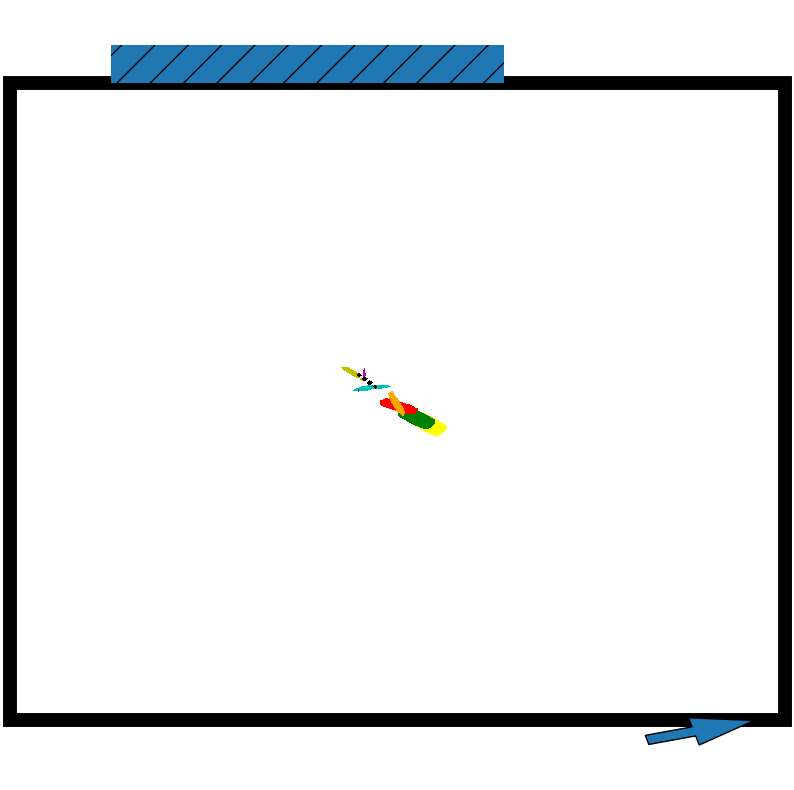

In [67]:
#env=sogym(mode='train',observation_type='box_dense',vol_constraint_type='soft')
#learner = learner.load('test_april23',env)
obs=train_env.reset()
dones=False

while dones== False:
    action, _states = model.policy.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones, info = train_env.step(action)
    #print(env.env_method('check_cTypeError: No loop matching the specified signature and casting was found for ufunc greateronnec'))
print("Reward:",rewards)
print('Connected:', train_env.check_connec())
#print('Desired volume:',env.out_conditions[6])
print('Actual volume:',train_env.volume)
fig=train_env.plot()
fig

--- 
### Training

In [13]:
#model = SAC.load("model_saved_march5",env =env) #Saved model is with soft volume constraint and 75 r
#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
#model.learn(20000000,callback=callback,tb_log_name='test_march14_SAC_hardvol')
model.save('model_saved_march15',)
model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

In [7]:
## Save the model:

# If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

# if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

# If the environment is normalized:
#env.save('env_saved.pkl')
# env = VecNormalize.load('env_saved.pkl',env)


---
### Let's visualize the agent's performance:

In [8]:
env=sogym(mode='train',observation_type='dense',vol_constraint_type='soft' )
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

Desired volume: 0.49 Obtained volume: 0.4933119210593657
Env reward: 0.2901929610515401 Compliance: 31.374107907038447


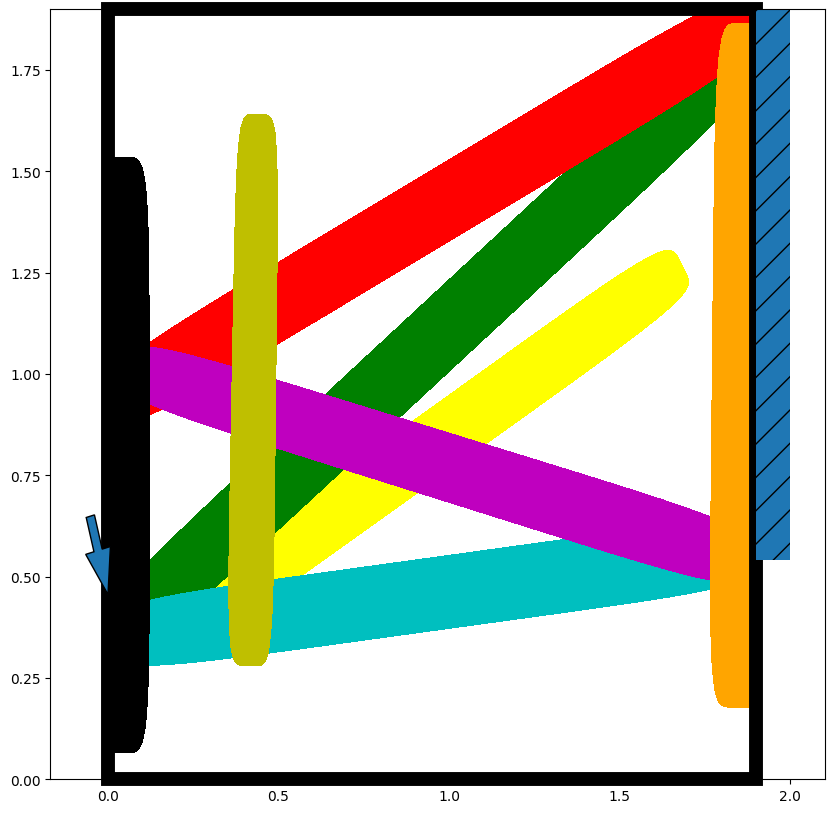

In [9]:
obs=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    # print(action)
    obs, rewards, dones, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
print("Env reward:",rewards, "Compliance:",np.exp(1/rewards))
env.plot()

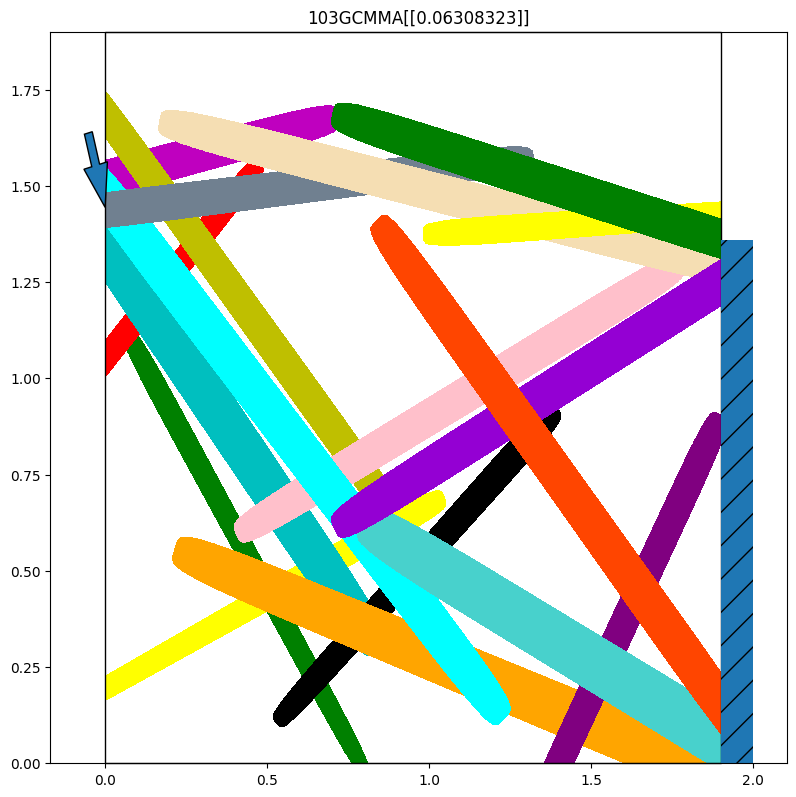

KeyboardInterrupt: 

In [10]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')


In [39]:
f0val

array(64.10951702)